# Regression of molecular properties with missing values
    - In this notebook, boiling temperature will be predicted by various imputers
    - Small compound database is used
    - x% of the data were replaced with NaN as missing values
    - GPU needed for some imputers

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import HuberRegressor
import xgboost as xgb
import sys

#custom librarires
sys.path.append("lib/")
sys.path.append("lib/MCFlowImputer/")
from data_util import prep_nan_df,prepare_dataset,visualize_result
from impute_funcs import imputation_MCFlow,imputation_missX


In [2]:
#load database with descriptors. all values are already normalized
path="../database/small_db_with_2d_descriptor_normalized.csv"
df=pd.read_csv(path, index_col=0)

#for faster calculation, you can limit records
df=df
df

,boiling temperature,melting temperature,density,viscosity,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_thiophene,fr_unbrch_alkane
0,0.266943,0.274337,0.039293,0.068301,0.184595,0.600490,0.184595,0.225833,0.452041,0.176519,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
1,0.386629,0.290087,0.062868,0.088320,0.185744,0.601015,0.185744,0.226852,0.472985,0.212844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667
2,0.491987,0.452397,0.081532,0.101120,0.186588,0.601332,0.186588,0.227466,0.479729,0.249169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000
3,0.313495,0.698365,0.156189,0.144176,0.124067,0.612961,0.124067,0.250000,0.388314,0.171298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.313495,0.694974,0.254420,0.126789,0.165422,0.655965,0.165422,0.333333,0.420167,0.155636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.515575,0.198442,0.373281,0.134327,0.777886,0.456473,0.777886,0.016204,0.303731,0.184070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
158,0.383543,0.951749,0.157171,0.083266,0.630672,0.537703,0.630672,0.104167,0.359300,0.095986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
159,0.463005,1.000000,0.186640,0.101763,0.646491,0.543676,0.646491,0.115741,0.439677,0.132311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
160,0.409788,0.894876,0.137525,0.093742,0.652881,0.500274,0.652881,0.031636,0.382321,0.132311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# introduce NaN to the database
    - boiling temperature will be predicted
    - 30% of the other variables will become NaN

In [3]:
target= "boiling temperature"
threshold=0.3

#extrapolation task
df=df.sort_values(by=target)

#interpolation task
#df=df.sample(frac=1)

    
col_to_id={k:v for v,k in enumerate(df.columns)}
nan_df=prep_nan_df(df,threshold,col_to_id[target])

nan_df

,boiling temperature,melting temperature,density,viscosity,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_thiophene,fr_unbrch_alkane
0,0.000000,0.000000,0.255403,0.059194,0.413428,0.546065,0.413428,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.042344,0.100524,NaN,0.045694,0.728317,0.548455,NaN,0.125000,0.282764,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.088905,0.456775,0.000000,NaN,NaN,NaN,0.183802,0.147377,0.423009,NaN,...,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0
3,0.093750,0.315769,0.311395,NaN,NaN,0.623712,0.379092,0.270833,0.425504,0.129638,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
4,0.111060,0.150076,0.092338,0.046881,0.399770,0.556518,0.399770,NaN,NaN,0.145300,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.843012,NaN,NaN,0.227525,1.000000,0.274501,1.000000,0.290509,0.663921,NaN,...,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN
158,0.863218,NaN,NaN,0.505414,0.827858,NaN,0.827858,0.008102,NaN,0.217723,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
159,0.886540,0.791783,NaN,0.187820,NaN,NaN,0.810454,NaN,NaN,0.181397,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
160,0.894420,0.757423,0.487230,NaN,NaN,0.501468,0.838024,0.033951,0.411083,0.173742,...,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0


# Split into train and test dataset
    - split ratio = 7/3
    - tr_df: dataframe of train dataset
    - te_df: dataframe of test dataset
        - NOTE: all variables are still maintained in the test dataset
            - All values in the boiling temperature column will be replaced with NaN before regression
            - NaN will be filled by imputers

In [4]:
split_ratio=0.7
tr_df,te_df=prepare_dataset(nan_df,target,split_ratio)
tr_df

,boiling temperature,melting temperature,density,viscosity,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_thiophene,fr_unbrch_alkane
0,0.000000,0.000000,0.255403,0.059194,0.413428,0.546065,0.413428,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.042344,0.100524,NaN,0.045694,0.728317,0.548455,NaN,0.125000,0.282764,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.088905,0.456775,0.000000,NaN,NaN,NaN,0.183802,0.147377,0.423009,NaN,...,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.000000
3,0.093750,0.315769,0.311395,NaN,NaN,0.623712,0.379092,0.270833,0.425504,0.129638,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
4,0.111060,0.150076,0.092338,0.046881,0.399770,0.556518,0.399770,NaN,NaN,0.145300,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.562037,NaN,NaN,0.510539,0.830485,0.461415,0.830485,0.043665,0.340602,NaN,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.083333
109,0.562037,0.564029,0.283890,0.127590,0.300318,0.584889,0.300318,0.195602,NaN,0.223065,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
110,0.565551,0.560120,0.281925,NaN,0.300318,0.584889,0.300318,NaN,NaN,0.223065,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.000000
111,0.565551,NaN,NaN,0.182399,0.423001,0.426078,NaN,NaN,0.552964,0.388021,...,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN


In [5]:
te_df

,boiling temperature,melting temperature,density,viscosity,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_thiophene,fr_unbrch_alkane
0,0.000000,0.000000,0.255403,0.059194,0.413428,0.546065,0.413428,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.042344,0.100524,NaN,0.045694,0.728317,0.548455,NaN,0.125000,0.282764,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.088905,0.456775,0.000000,NaN,NaN,NaN,0.183802,0.147377,0.423009,NaN,...,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0
3,0.093750,0.315769,0.311395,NaN,NaN,0.623712,0.379092,0.270833,0.425504,0.129638,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
4,0.111060,0.150076,0.092338,0.046881,0.399770,0.556518,0.399770,NaN,NaN,0.145300,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.843012,NaN,NaN,0.227525,1.000000,0.274501,1.000000,0.290509,0.663921,NaN,...,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN
158,0.863218,NaN,NaN,0.505414,0.827858,NaN,0.827858,0.008102,NaN,0.217723,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
159,0.886540,0.791783,NaN,0.187820,NaN,NaN,0.810454,NaN,NaN,0.181397,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
160,0.894420,0.757423,0.487230,NaN,NaN,0.501468,0.838024,0.033951,0.411083,0.173742,...,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0


# prediction by MCFLow
- Original code:  https://github.com/trevor-richardson/MCFlow
- An imputation class was made for the regression task (for details, see the library folder)

lib/MCFlowImputer/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  rw.append((value - mins[idx_v]) / (maxs[idx_v] - mins[idx_v]))



MAE for train:  0.0655687027068482
MAE for test:  0.18092991896263408


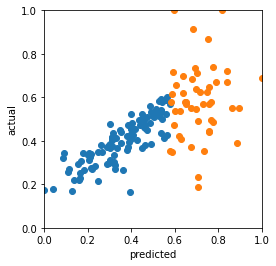

In [6]:
tr_y,pred_tr_y,te_y,pred_te_y=imputation_MCFlow(tr_df,te_df,target,n_epochs=128)
visualize_result(tr_y,pred_tr_y,te_y,pred_te_y)

# Imputation by Various algorithms
# MissHuber and MissXGB
    - Original code of MissForest: https://github.com/stekhoven/missForest
    - The imputer was modified so that...
        - It can be used for regression
        - Custom predictors can be used
        - Predictions are done in parallel (for faster calculation)

In [7]:
from MissParallelX import MissParallelX


MAE for train:  0.018990418192729563
MAE for test:  0.20329754853165918


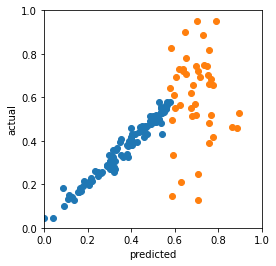

In [8]:
#MissHuber
tr_y,pred_tr_y,te_y,pred_te_y=imputation_missX(tr_df,te_df,target,imputer=MissParallelX(custom_regressor=HuberRegressor()))
visualize_result(tr_y,pred_tr_y,te_y,pred_te_y)


MAE for train:  0.016676901520027956
MAE for test:  0.24000209684070062


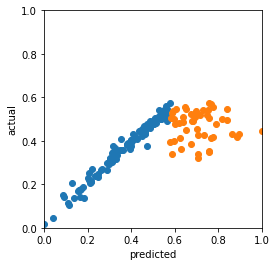

In [9]:
#MissXGB
tr_y,pred_tr_y,te_y,pred_te_y=imputation_missX(tr_df,te_df,target,imputer=MissParallelX(custom_regressor=xgb.XGBRegressor(objective="reg:squarederror")))
visualize_result(tr_y,pred_tr_y,te_y,pred_te_y)

# Imputation by other deep learning models (takes a long time!)
    - Autoencoder(AE) and Variational Autoencoder (VAE)
        - Originally implemented by K.H.
    - GAIN
        - Original codes: https://github.com/dhanajitb/GAIN-Pytorch

In [10]:
from GAIN import GAIN
from MissAE import MissAE

epoch 0 reconstruction diff 0.018694011960178614
epoch 1 reconstruction diff 0.009673191467300057
epoch 2 reconstruction diff 0.0011773141159210354
epoch 3 reconstruction diff 0.0004224578442517668
epoch 4 reconstruction diff 0.00209212998743169
epoch 5 reconstruction diff 0.0026432234153617173
epoch 6 reconstruction diff 0.0010655973455868661
epoch 7 reconstruction diff 0.0005002800389775075
epoch 8 reconstruction diff 0.0006433803209802136
epoch 9 reconstruction diff 0.000619282029219903
early stopping


epoch 0 reconstruction diff 0.00012820684059988707
epoch 1 reconstruction diff 3.423438829486258e-05
epoch 2 reconstruction diff 3.5265391034045024e-06
epoch 3 reconstruction diff 9.592108654032927e-06
epoch 4 reconstruction diff 3.7773647818539757e-06
epoch 5 reconstruction diff 1.2818954928661697e-06
epoch 6 reconstruction diff 1.6328888250427553e-06
epoch 7 reconstruction diff 4.110140707780374e-06
epoch 8 reconstruction diff 3.3561700547579676e-06
epoch 9 reconstruction diff 2.914693595812423e-06
epoch 10 reconstruction diff 1.2440111731848447e-06
epoch 11 reconstruction diff 1.3075037941234768e-06
epoch 12 reconstruction diff 1.2403753544276697e-06
epoch 13 reconstruction diff 9.456798011342471e-07
epoch 14 reconstruction diff 8.552861459065753e-07
epoch 15 reconstruction diff 2.461773362938402e-07
epoch 16 reconstruction diff 3.914051944775565e-07
epoch 17 reconstruction diff 9.68599010775506e-07
epoch 18 reconstruction diff 1.3259279967314797e-06
epoch 19 reconstruction diff 5.1

epoch 23 reconstruction diff 9.90816602097766e-07
epoch 24 reconstruction diff 2.1921405277680606e-06
epoch 25 reconstruction diff 1.2979367056686897e-06
epoch 26 reconstruction diff 9.340209885522199e-07
epoch 27 reconstruction diff 5.955873803031864e-07
early stopping
epoch 0 reconstruction diff 0.0002632140531204641
epoch 1 reconstruction diff 3.3730248105712235e-05
epoch 2 reconstruction diff 2.956670414278051e-06
epoch 3 reconstruction diff 1.592087937751785e-05
epoch 4 reconstruction diff 5.71251985093113e-06
epoch 5 reconstruction diff 4.984270162822213e-06
epoch 6 reconstruction diff 2.144461404895992e-06
epoch 7 reconstruction diff 2.6619359232427087e-06
epoch 8 reconstruction diff 8.21447520138463e-06
epoch 9 reconstruction diff 2.2492351945402334e-06
epoch 10 reconstruction diff 5.484667781274766e-06
epoch 11 reconstruction diff 3.29120371134195e-06
epoch 12 reconstruction diff 2.7905809929507086e-06
early stopping
epoch 0 reconstruction diff 0.0004256404936313629
epoch 1 re

epoch 1 reconstruction diff 7.263739826157689e-05
epoch 2 reconstruction diff 1.980073193408316e-06
epoch 3 reconstruction diff 3.327160811750218e-05
epoch 4 reconstruction diff 1.558519943500869e-05
epoch 5 reconstruction diff 5.113206043461105e-06
epoch 6 reconstruction diff 5.375097316573374e-06
epoch 7 reconstruction diff 1.0864692740142345e-05
epoch 8 reconstruction diff 2.9193295176810352e-06
early stopping
epoch 0 reconstruction diff 0.0003828369081020355
epoch 1 reconstruction diff 0.00013385916827246547
epoch 2 reconstruction diff 2.727791297729709e-06
epoch 3 reconstruction diff 1.951425838342402e-05
epoch 4 reconstruction diff 4.332472599344328e-05
epoch 5 reconstruction diff 7.1696217673888896e-06
epoch 6 reconstruction diff 3.7086333577462938e-06
epoch 7 reconstruction diff 6.874213340779534e-06
epoch 8 reconstruction diff 3.1716269859316526e-06
early stopping
epoch 0 reconstruction diff 0.0005474150530062616
epoch 1 reconstruction diff 5.515132943401113e-05
epoch 2 recons

epoch 10 reconstruction diff 3.3899057143571554e-06
epoch 11 reconstruction diff 3.3189999157912098e-06
epoch 12 reconstruction diff 1.993523801502306e-05
epoch 13 reconstruction diff 1.5131446161831263e-05
epoch 14 reconstruction diff 6.095938260841649e-06
early stopping
epoch 0 reconstruction diff 0.000323284330079332
epoch 1 reconstruction diff 7.751163502689451e-05
epoch 2 reconstruction diff 1.6904496078495868e-06
epoch 3 reconstruction diff 9.906361810863018e-06
epoch 4 reconstruction diff 8.301024536194745e-06
epoch 5 reconstruction diff 8.178310963558033e-06
epoch 6 reconstruction diff 1.2004447853541933e-05
epoch 7 reconstruction diff 2.115924189638463e-06
epoch 8 reconstruction diff 5.8484915825829376e-06
early stopping
epoch 0 reconstruction diff 0.0004470064304769039
epoch 1 reconstruction diff 4.255857857060619e-05
epoch 2 reconstruction diff 9.976669389288872e-06
epoch 3 reconstruction diff 7.296814874280244e-05
epoch 4 reconstruction diff 4.159063973929733e-05
epoch 5 re

epoch 4 reconstruction diff 1.8272618035553023e-05
epoch 5 reconstruction diff 1.4623140486946795e-05
epoch 6 reconstruction diff 5.66019480174873e-06
epoch 7 reconstruction diff 3.8684624996676575e-06
epoch 8 reconstruction diff 5.868111202289583e-06
epoch 9 reconstruction diff 9.313868758908939e-06
epoch 10 reconstruction diff 3.0788044114160584e-06
epoch 11 reconstruction diff 6.415186817321228e-06
epoch 12 reconstruction diff 9.855967846306157e-07
epoch 13 reconstruction diff 2.5317938252555905e-06
epoch 14 reconstruction diff 3.145781647617696e-06
epoch 15 reconstruction diff 3.0162038910930278e-06
epoch 16 reconstruction diff 2.2156698378239525e-06
epoch 17 reconstruction diff 2.797415845634532e-06
epoch 18 reconstruction diff 2.0306620172050316e-06
early stopping
epoch 0 reconstruction diff 0.00046666443813592196
epoch 1 reconstruction diff 5.561124999076128e-05
epoch 2 reconstruction diff 3.2250944059342146e-05
epoch 3 reconstruction diff 9.473439604334999e-06
epoch 4 reconstru

epoch 0 reconstruction diff 0.00029143402935005724
epoch 1 reconstruction diff 5.40590554010123e-05
epoch 2 reconstruction diff 1.7641459635342471e-06
epoch 3 reconstruction diff 2.719834265008103e-05
epoch 4 reconstruction diff 5.089281330583617e-06
epoch 5 reconstruction diff 2.7573494207899785e-06
epoch 6 reconstruction diff 5.899168172618374e-06
epoch 7 reconstruction diff 2.6081211217388045e-06
epoch 8 reconstruction diff 2.5100307539105415e-06
early stopping
epoch 0 reconstruction diff 0.000476429850095883
epoch 1 reconstruction diff 8.468606392852962e-05
epoch 2 reconstruction diff 1.439893253518676e-06
epoch 3 reconstruction diff 5.4722579079680145e-05
epoch 4 reconstruction diff 7.836251825210638e-06
epoch 5 reconstruction diff 9.962755029846448e-06
epoch 6 reconstruction diff 6.5182812249986455e-06
epoch 7 reconstruction diff 3.298500359960599e-06
epoch 8 reconstruction diff 2.6056568458443508e-06
early stopping
epoch 0 reconstruction diff 0.0004569235607050359
epoch 1 recons

epoch 9 reconstruction diff 2.0116801806580042e-06
epoch 10 reconstruction diff 1.8328253190702526e-06
epoch 11 reconstruction diff 2.283700723637594e-06
epoch 12 reconstruction diff 1.9802023416559678e-06
epoch 13 reconstruction diff 2.1338657916203374e-06
epoch 14 reconstruction diff 2.7754042548622238e-06
epoch 15 reconstruction diff 3.163404016959248e-06
epoch 16 reconstruction diff 2.9208260912128026e-06
early stopping
epoch 0 reconstruction diff 0.00029666078626178205
epoch 1 reconstruction diff 8.77648635650985e-05
epoch 2 reconstruction diff 4.17977707911632e-06
epoch 3 reconstruction diff 2.2373964384314604e-05
epoch 4 reconstruction diff 2.0035653506056406e-05
epoch 5 reconstruction diff 1.2614450497494545e-05
epoch 6 reconstruction diff 1.765713568602223e-05
epoch 7 reconstruction diff 5.525623691937653e-06
epoch 8 reconstruction diff 1.2183044418634381e-05
early stopping
epoch 0 reconstruction diff 0.0004405536164995283
epoch 1 reconstruction diff 8.861369133228436e-05
epoc

epoch 2 reconstruction diff 1.4448723959503695e-06
epoch 3 reconstruction diff 3.1380779546452686e-05
epoch 4 reconstruction diff 6.443024904001504e-05
epoch 5 reconstruction diff 1.806482396204956e-05
epoch 6 reconstruction diff 8.647863978694659e-06
epoch 7 reconstruction diff 3.6825254028372e-06
epoch 8 reconstruction diff 1.0529918654356152e-05
early stopping
epoch 0 reconstruction diff 0.00040907206130214036
epoch 1 reconstruction diff 9.006387699628249e-05
epoch 2 reconstruction diff 4.0166396502172574e-06
epoch 3 reconstruction diff 4.604169225785881e-05
epoch 4 reconstruction diff 8.625996997579932e-06
epoch 5 reconstruction diff 9.913486792356707e-06
epoch 6 reconstruction diff 1.5717236237833276e-05
epoch 7 reconstruction diff 9.886312000162434e-06
epoch 8 reconstruction diff 4.960631031281082e-06
early stopping
epoch 0 reconstruction diff 0.00013979244977235794
epoch 1 reconstruction diff 0.00010432991257403046
epoch 2 reconstruction diff 4.843523129238747e-06
epoch 3 recons

epoch 8 reconstruction diff 9.875231626210734e-06
epoch 9 reconstruction diff 4.403544153319672e-06
epoch 10 reconstruction diff 6.678138561255764e-06
epoch 11 reconstruction diff 9.350663276563864e-06
epoch 12 reconstruction diff 4.589915988617577e-06
epoch 13 reconstruction diff 1.1553954209375661e-05
early stopping
epoch 0 reconstruction diff 0.00027916874387301505
epoch 1 reconstruction diff 6.0422895330702886e-05
epoch 2 reconstruction diff 1.296761638513999e-05
epoch 3 reconstruction diff 5.589493866864359e-06
epoch 4 reconstruction diff 2.553717195041827e-06
epoch 5 reconstruction diff 2.9397047001111787e-06
epoch 6 reconstruction diff 1.3222215784480795e-06
epoch 7 reconstruction diff 3.900453521055169e-06
epoch 8 reconstruction diff 1.6244483731497894e-06
epoch 9 reconstruction diff 2.3263480670721037e-06
epoch 10 reconstruction diff 1.3657527233590372e-06
epoch 11 reconstruction diff 1.505565023762756e-06
epoch 12 reconstruction diff 1.9442927623458672e-06
early stopping
epoc

epoch 3 reconstruction diff 1.837861054809764e-05
epoch 4 reconstruction diff 0.00015128534869290888
epoch 5 reconstruction diff 3.41374943673145e-05
epoch 6 reconstruction diff 6.128654604253825e-06
epoch 7 reconstruction diff 6.817275334469741e-06
epoch 8 reconstruction diff 6.868644504720578e-06
epoch 9 reconstruction diff 3.813335297309095e-06
epoch 10 reconstruction diff 1.6569194940529997e-06
epoch 11 reconstruction diff 2.0574232166836737e-06
epoch 12 reconstruction diff 1.361666136290296e-06
epoch 13 reconstruction diff 2.2935926153877517e-06
epoch 14 reconstruction diff 2.036303158092778e-06
epoch 15 reconstruction diff 1.4031746786713484e-06
epoch 16 reconstruction diff 6.090579518058803e-06
epoch 17 reconstruction diff 1.7976234403249691e-06
epoch 18 reconstruction diff 3.538842520356411e-06
early stopping
epoch 0 reconstruction diff 0.00038478465285152197
epoch 1 reconstruction diff 5.906509613851085e-05
epoch 2 reconstruction diff 7.519591235904954e-06
epoch 3 reconstructi

epoch 1 reconstruction diff 8.995412645163015e-05
epoch 2 reconstruction diff 2.0244710867700633e-06
epoch 3 reconstruction diff 3.225914952054154e-06
epoch 4 reconstruction diff 1.1541044841578696e-05
epoch 5 reconstruction diff 7.357122285611695e-06
epoch 6 reconstruction diff 2.0212737581459805e-06
epoch 7 reconstruction diff 3.667827058961848e-06
epoch 8 reconstruction diff 4.134352820983622e-06
epoch 9 reconstruction diff 3.674308345580357e-06
epoch 10 reconstruction diff 5.955060260021128e-06
epoch 11 reconstruction diff 3.7908876038272865e-06
epoch 12 reconstruction diff 2.7477678941068007e-06
early stopping
epoch 0 reconstruction diff 0.0004425912629812956
epoch 1 reconstruction diff 0.00012680918734986335
epoch 2 reconstruction diff 4.8152560339076445e-06
epoch 3 reconstruction diff 0.00020880506781395525
epoch 4 reconstruction diff 2.8692680643871427e-05
epoch 5 reconstruction diff 9.502058674115688e-06
epoch 6 reconstruction diff 1.1869620720972307e-05
epoch 7 reconstruction

epoch 16 reconstruction diff 5.2108571253484115e-06
early stopping
epoch 0 reconstruction diff 0.00034032034454867244
epoch 1 reconstruction diff 0.00010635498620104045
epoch 2 reconstruction diff 7.514852768508717e-06
epoch 3 reconstruction diff 1.7294232748099603e-05
epoch 4 reconstruction diff 0.00010234423825750127
epoch 5 reconstruction diff 1.0531019142945297e-05
epoch 6 reconstruction diff 6.356362973747309e-06
epoch 7 reconstruction diff 6.748191935912473e-06
epoch 8 reconstruction diff 2.0308955299697118e-06
epoch 9 reconstruction diff 2.3487773432862014e-06
epoch 10 reconstruction diff 2.5987758363044122e-06
epoch 11 reconstruction diff 1.811600782275491e-06
epoch 12 reconstruction diff 1.4872334759274963e-06
epoch 13 reconstruction diff 2.1223102066869615e-06
epoch 14 reconstruction diff 1.6992561313600163e-06
epoch 15 reconstruction diff 5.240959239927179e-07
epoch 16 reconstruction diff 1.3954233963886509e-06
epoch 17 reconstruction diff 1.3643505099025788e-06
epoch 18 rec

epoch 24 reconstruction diff 3.0299549962364836e-06
epoch 25 reconstruction diff 2.2396275198843796e-06
early stopping
epoch 0 reconstruction diff 0.00044864631490781903
epoch 1 reconstruction diff 0.00011994371743639931
epoch 2 reconstruction diff 8.614746548119001e-06
epoch 3 reconstruction diff 1.3702935575565789e-05
epoch 4 reconstruction diff 1.8436991013004445e-05
epoch 5 reconstruction diff 1.0994045624102e-05
epoch 6 reconstruction diff 6.942125310160918e-06
epoch 7 reconstruction diff 3.152993258481729e-06
epoch 8 reconstruction diff 6.635261797782732e-06
epoch 9 reconstruction diff 6.341841526591452e-06
epoch 10 reconstruction diff 4.192450887785526e-06
epoch 11 reconstruction diff 4.2097799450857565e-06
epoch 12 reconstruction diff 2.178094973714906e-06
epoch 13 reconstruction diff 2.2310896383714862e-06
epoch 14 reconstruction diff 1.4427781707126996e-06
epoch 15 reconstruction diff 1.6260137272183783e-06
epoch 16 reconstruction diff 2.7072533157479484e-06
epoch 17 reconstr

epoch 6 reconstruction diff 9.685160875960719e-06
epoch 7 reconstruction diff 5.309406333253719e-06
epoch 8 reconstruction diff 4.3718873712350614e-06
epoch 9 reconstruction diff 2.93863331535249e-06
epoch 10 reconstruction diff 3.3735541364876553e-06
epoch 11 reconstruction diff 1.4092458968661958e-06
epoch 12 reconstruction diff 2.404583256065962e-06
epoch 13 reconstruction diff 2.8619163003895665e-06
epoch 14 reconstruction diff 3.3110109143308364e-06
epoch 15 reconstruction diff 3.3384815196768614e-06
epoch 16 reconstruction diff 2.638199475768488e-06
epoch 17 reconstruction diff 1.1519587133079767e-06
epoch 18 reconstruction diff 2.9254495075292652e-06
epoch 19 reconstruction diff 2.0218492409185274e-06
epoch 20 reconstruction diff 1.1346771771059139e-06
epoch 21 reconstruction diff 2.5535377972119022e-06
epoch 22 reconstruction diff 3.1904178285913076e-06
epoch 23 reconstruction diff 1.581281026119541e-06
epoch 24 reconstruction diff 9.708246579975821e-07
epoch 25 reconstruction 

epoch 1 reconstruction diff 0.00013858747843187302
epoch 2 reconstruction diff 8.369942406716291e-06
epoch 3 reconstruction diff 5.466562288347632e-05
epoch 4 reconstruction diff 2.489354847057257e-05
epoch 5 reconstruction diff 1.0310049219697248e-05
epoch 6 reconstruction diff 5.376150056690676e-06
epoch 7 reconstruction diff 4.640002316591563e-06
epoch 8 reconstruction diff 2.741363914537942e-06
epoch 9 reconstruction diff 3.1540610052616103e-06
epoch 10 reconstruction diff 6.122142622189131e-06
epoch 11 reconstruction diff 3.6935955449735047e-06
epoch 12 reconstruction diff 2.0014322217321023e-06
epoch 13 reconstruction diff 2.2934323169465642e-06
epoch 14 reconstruction diff 3.448874167588656e-06
epoch 15 reconstruction diff 4.8240553951472975e-06
epoch 16 reconstruction diff 3.8659673009533435e-06
epoch 17 reconstruction diff 1.3170846386856283e-06
epoch 18 reconstruction diff 4.60274259239668e-06
epoch 19 reconstruction diff 2.818905841195374e-06
epoch 20 reconstruction diff 2.2

epoch 17 reconstruction diff 1.832500061027531e-06
epoch 18 reconstruction diff 4.165566224401118e-06
epoch 19 reconstruction diff 4.812122824660037e-06
epoch 20 reconstruction diff 5.195976882532705e-06
epoch 21 reconstruction diff 3.837163149000844e-06
epoch 22 reconstruction diff 4.353681561042322e-06
epoch 23 reconstruction diff 4.321324468037346e-06
early stopping
epoch 0 reconstruction diff 0.0004017980245407671
epoch 1 reconstruction diff 8.028517186176032e-05
epoch 2 reconstruction diff 3.0286277251434512e-05
epoch 3 reconstruction diff 1.917394547490403e-05
epoch 4 reconstruction diff 2.4210714400396682e-05
epoch 5 reconstruction diff 6.867676347610541e-06
epoch 6 reconstruction diff 9.443998351343907e-06
epoch 7 reconstruction diff 8.784316378296353e-06
epoch 8 reconstruction diff 6.2088624872558285e-06
epoch 9 reconstruction diff 3.638957196017145e-06
epoch 10 reconstruction diff 5.705395778932143e-06
epoch 11 reconstruction diff 1.8935172647616128e-06
epoch 12 reconstructio

epoch 13 reconstruction diff 3.34526521328371e-06
epoch 14 reconstruction diff 8.380272447539028e-06
early stopping

MAE for train:  0.08286056601742993
MAE for test:  0.2717500102435856


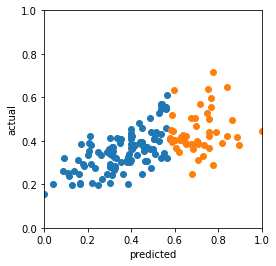

In [11]:
#AE
tr_y,pred_tr_y,te_y,pred_te_y=imputation_missX(tr_df,te_df,target,imputer=MissAE(mode="AE"))
visualize_result(tr_y,pred_tr_y,te_y,pred_te_y)

epoch 0 reconstruction diff 0.032806264236569405
epoch 1 reconstruction diff 0.0034474232816137373
epoch 2 reconstruction diff 0.0012814030633307993
epoch 3 reconstruction diff 0.00069413885648828
epoch 4 reconstruction diff 0.0005937665118835866
epoch 5 reconstruction diff 0.0010308438068022951
epoch 6 reconstruction diff 0.0021015771781094372
epoch 7 reconstruction diff 0.0019851409597322345
epoch 8 reconstruction diff 0.002765430515864864
epoch 9 reconstruction diff 0.002440297568682581
epoch 10 reconstruction diff 0.0023087517474777997
early stopping


epoch 0 reconstruction diff 0.00033376552164554596
epoch 1 reconstruction diff 1.0833005944732577e-05
epoch 2 reconstruction diff 9.285186024499126e-06
epoch 3 reconstruction diff 5.757734925282421e-06
epoch 4 reconstruction diff 6.301438133959891e-06
epoch 5 reconstruction diff 4.5809221774106845e-05
epoch 6 reconstruction diff 3.586924867704511e-05
epoch 7 reconstruction diff 2.452768512739567e-06
epoch 8 reconstruction diff 1.3209073586040176e-06
epoch 9 reconstruction diff 2.74135782092344e-05
epoch 10 reconstruction diff 5.389092621044256e-05
epoch 11 reconstruction diff 5.835553565702867e-06
epoch 12 reconstruction diff 1.2479373253881931e-05
epoch 13 reconstruction diff 1.824045648390893e-05
epoch 14 reconstruction diff 7.430074219882954e-06
early stopping
epoch 0 reconstruction diff 0.0005479521350935102
epoch 1 reconstruction diff 8.714114301255904e-06
epoch 2 reconstruction diff 4.826533313462278e-06
epoch 3 reconstruction diff 1.2003774827462621e-05
epoch 4 reconstruction di

epoch 12 reconstruction diff 8.439526027359534e-06
epoch 13 reconstruction diff 1.661521127971355e-05
epoch 14 reconstruction diff 9.504329682386015e-06
early stopping
epoch 0 reconstruction diff 0.00054085289593786
epoch 1 reconstruction diff 6.860694611532381e-06
epoch 2 reconstruction diff 1.7808266647989512e-06
epoch 3 reconstruction diff 1.832402517720766e-06
epoch 4 reconstruction diff 1.5490930309169926e-05
epoch 5 reconstruction diff 1.7679140000836924e-05
epoch 6 reconstruction diff 3.153804937028326e-05
epoch 7 reconstruction diff 8.96818601177074e-05
epoch 8 reconstruction diff 2.9449549401761033e-05
early stopping
epoch 0 reconstruction diff 0.000714194611646235
epoch 1 reconstruction diff 7.683683179493528e-06
epoch 2 reconstruction diff 2.979486816911958e-05
epoch 3 reconstruction diff 3.1602041417500004e-05
epoch 4 reconstruction diff 4.03835565521149e-06
epoch 5 reconstruction diff 2.0040639356011525e-05
epoch 6 reconstruction diff 3.631614163168706e-05
epoch 7 reconstr

epoch 10 reconstruction diff 3.971447586081922e-05
epoch 11 reconstruction diff 7.649341569049284e-06
early stopping
epoch 0 reconstruction diff 0.00027421547565609217
epoch 1 reconstruction diff 2.6814006560016423e-05
epoch 2 reconstruction diff 1.1718165069396491e-06
epoch 3 reconstruction diff 7.760819244140293e-06
epoch 4 reconstruction diff 5.0595244829310104e-05
epoch 5 reconstruction diff 1.8961809473694302e-05
epoch 6 reconstruction diff 2.95954268949572e-05
epoch 7 reconstruction diff 1.5792220438015647e-05
epoch 8 reconstruction diff 5.541441623790888e-06
early stopping
epoch 0 reconstruction diff 0.00043386482866480947
epoch 1 reconstruction diff 8.363015513168648e-05
epoch 2 reconstruction diff 1.6244706785073504e-05
epoch 3 reconstruction diff 3.1425777251570253e-06
epoch 4 reconstruction diff 1.70404546224745e-05
epoch 5 reconstruction diff 2.1266738258418627e-05
epoch 6 reconstruction diff 8.136988981277682e-06
epoch 7 reconstruction diff 2.2636579160462134e-05
epoch 8 r

epoch 6 reconstruction diff 8.038363375817426e-06
epoch 7 reconstruction diff 2.3884367692517117e-06
epoch 8 reconstruction diff 3.894342626153957e-06
epoch 9 reconstruction diff 1.9843288100673817e-05
epoch 10 reconstruction diff 1.599181132405647e-06
epoch 11 reconstruction diff 5.309463631419931e-06
epoch 12 reconstruction diff 1.8157328668166883e-05
epoch 13 reconstruction diff 4.600417469191598e-06
epoch 14 reconstruction diff 5.605244496109663e-06
epoch 15 reconstruction diff 1.3365005543164443e-05
epoch 16 reconstruction diff 8.095907105598599e-06
early stopping
epoch 0 reconstruction diff 0.0005083634750917554
epoch 1 reconstruction diff 1.7054191630450077e-05
epoch 2 reconstruction diff 3.581878263503313e-05
epoch 3 reconstruction diff 2.916566882049665e-05
epoch 4 reconstruction diff 1.5635681847925298e-05
epoch 5 reconstruction diff 7.995957275852561e-06
epoch 6 reconstruction diff 5.317349405231653e-06
epoch 7 reconstruction diff 3.65345681530016e-06
epoch 8 reconstruction 

epoch 1 reconstruction diff 1.3611879694508389e-05
epoch 2 reconstruction diff 5.09205301568727e-06
epoch 3 reconstruction diff 1.993200612560031e-06
epoch 4 reconstruction diff 3.2825322705321014e-05
epoch 5 reconstruction diff 7.84960047894856e-06
epoch 6 reconstruction diff 3.9122928683354985e-06
epoch 7 reconstruction diff 1.0303277122147847e-05
epoch 8 reconstruction diff 8.785876161709893e-06
epoch 9 reconstruction diff 1.064457592292456e-05
early stopping
epoch 0 reconstruction diff 0.0006264900439418852
epoch 1 reconstruction diff 0.00010112114978255704
epoch 2 reconstruction diff 4.09658014177694e-06
epoch 3 reconstruction diff 1.2201805475342553e-05
epoch 4 reconstruction diff 2.912992931669578e-05
epoch 5 reconstruction diff 2.2730196178599726e-06
epoch 6 reconstruction diff 1.8425833332003094e-05
epoch 7 reconstruction diff 4.213480860926211e-05
epoch 8 reconstruction diff 2.9212425943114795e-05
epoch 9 reconstruction diff 4.083031672053039e-05
epoch 10 reconstruction diff 

epoch 8 reconstruction diff 7.666178134968504e-06
epoch 9 reconstruction diff 5.334012257662835e-06
early stopping
epoch 0 reconstruction diff 0.0003154992882627994
epoch 1 reconstruction diff 1.6880681869224645e-05
epoch 2 reconstruction diff 7.134569841582561e-06
epoch 3 reconstruction diff 2.0856474293395877e-05
epoch 4 reconstruction diff 3.0120736482786015e-06
epoch 5 reconstruction diff 2.943206527561415e-05
epoch 6 reconstruction diff 2.2495600205729716e-05
epoch 7 reconstruction diff 4.3537736928556114e-05
epoch 8 reconstruction diff 3.2438343623653054e-05
epoch 9 reconstruction diff 4.201188858132809e-06
epoch 10 reconstruction diff 9.4498936960008e-06
early stopping
epoch 0 reconstruction diff 0.00041637010872364044
epoch 1 reconstruction diff 7.566915883217007e-06
epoch 2 reconstruction diff 4.655214070226066e-06
epoch 3 reconstruction diff 3.6019462186231976e-06
epoch 4 reconstruction diff 8.21209505375009e-06
epoch 5 reconstruction diff 2.6122654162463732e-05
epoch 6 recon

epoch 5 reconstruction diff 9.749956006999128e-06
epoch 6 reconstruction diff 3.3163287298521027e-06
epoch 7 reconstruction diff 2.5128998458967544e-05
epoch 8 reconstruction diff 1.1068382264056709e-05
epoch 9 reconstruction diff 6.570227014890406e-06
epoch 10 reconstruction diff 1.0397683581686579e-05
early stopping
epoch 0 reconstruction diff 0.0004676884855143726
epoch 1 reconstruction diff 5.747263912780909e-06
epoch 2 reconstruction diff 1.9110993889626116e-06
epoch 3 reconstruction diff 9.957038855645806e-06
epoch 4 reconstruction diff 4.769949555338826e-06
epoch 5 reconstruction diff 1.5993115084711462e-05
epoch 6 reconstruction diff 7.016667495918227e-06
epoch 7 reconstruction diff 1.1811899639724288e-05
epoch 8 reconstruction diff 1.4692382137582172e-05
early stopping
epoch 0 reconstruction diff 0.00030129673541523516
epoch 1 reconstruction diff 7.72222483647056e-06
epoch 2 reconstruction diff 1.1924093996640295e-06
epoch 3 reconstruction diff 1.7058317780538346e-06
epoch 4 r

epoch 7 reconstruction diff 1.6315365428454243e-05
epoch 8 reconstruction diff 3.1446426874026656e-05
epoch 9 reconstruction diff 2.927684545284137e-05
early stopping
epoch 0 reconstruction diff 0.0005079680704511702
epoch 1 reconstruction diff 1.2460493962862529e-05
epoch 2 reconstruction diff 8.164219252648763e-06
epoch 3 reconstruction diff 4.1147059164359234e-06
epoch 4 reconstruction diff 3.268492491770303e-06
epoch 5 reconstruction diff 6.97987197781913e-05
epoch 6 reconstruction diff 5.723744470742531e-05
epoch 7 reconstruction diff 6.44145839032717e-05
epoch 8 reconstruction diff 3.143601134070195e-05
epoch 9 reconstruction diff 1.889183113235049e-05
epoch 10 reconstruction diff 2.322746513527818e-05
early stopping
epoch 0 reconstruction diff 0.0005278572789393365
epoch 1 reconstruction diff 1.559019074193202e-05
epoch 2 reconstruction diff 1.3563511629399727e-06
epoch 3 reconstruction diff 2.8198101063026115e-06
epoch 4 reconstruction diff 1.0966172339976765e-05
epoch 5 recons

epoch 5 reconstruction diff 1.1200035260117147e-05
epoch 6 reconstruction diff 1.1395509318390395e-05
epoch 7 reconstruction diff 2.5690583242976572e-06
epoch 8 reconstruction diff 3.2880382150324294e-06
early stopping
epoch 0 reconstruction diff 0.000451014144346118
epoch 1 reconstruction diff 4.0640599763719365e-05
epoch 2 reconstruction diff 3.419051063247025e-05
epoch 3 reconstruction diff 2.666835098352749e-05
epoch 4 reconstruction diff 4.0819022615323775e-06
epoch 5 reconstruction diff 1.8700528698900598e-06
epoch 6 reconstruction diff 1.4188721252139658e-05
epoch 7 reconstruction diff 1.0700592611101456e-05
epoch 8 reconstruction diff 1.82676812983118e-05
epoch 9 reconstruction diff 9.180494089378044e-06
epoch 10 reconstruction diff 4.008873293059878e-05
epoch 11 reconstruction diff 2.2591017113882117e-05
early stopping
epoch 0 reconstruction diff 0.0005330831045284867
epoch 1 reconstruction diff 7.41861731512472e-06
epoch 2 reconstruction diff 1.7140681620730902e-06
epoch 3 re

epoch 8 reconstruction diff 4.102868388144998e-06
epoch 9 reconstruction diff 3.459208983258577e-06
epoch 10 reconstruction diff 8.061854714469519e-06
epoch 11 reconstruction diff 4.2538580601103604e-05
epoch 12 reconstruction diff 5.869973756489344e-05
epoch 13 reconstruction diff 2.9039008950348943e-05
epoch 14 reconstruction diff 2.4832684175635222e-06
epoch 15 reconstruction diff 8.856675776769407e-06
epoch 16 reconstruction diff 1.4378721971297637e-05
epoch 17 reconstruction diff 1.8896236042564851e-06
epoch 18 reconstruction diff 1.0534166904108133e-05
epoch 19 reconstruction diff 9.46644286159426e-06
epoch 20 reconstruction diff 2.389838527960819e-06
epoch 21 reconstruction diff 3.036950874957256e-05
epoch 22 reconstruction diff 1.8014674196820124e-06
epoch 23 reconstruction diff 1.613515632925555e-05
epoch 24 reconstruction diff 2.6795212761498988e-05
epoch 25 reconstruction diff 6.974585176067194e-06
epoch 26 reconstruction diff 3.135456790914759e-05
epoch 27 reconstruction di

epoch 14 reconstruction diff 2.383297760388814e-05
epoch 15 reconstruction diff 2.283975163663854e-06
epoch 16 reconstruction diff 1.3464244148053695e-05
epoch 17 reconstruction diff 7.218292921606917e-06
early stopping
epoch 0 reconstruction diff 0.00030413741478696465
epoch 1 reconstruction diff 1.3469251825881656e-05
epoch 2 reconstruction diff 1.2829043498641113e-06
epoch 3 reconstruction diff 2.7798862447525607e-06
epoch 4 reconstruction diff 8.007723226910457e-05
epoch 5 reconstruction diff 0.0001399597676936537
epoch 6 reconstruction diff 6.680317892460153e-05
epoch 7 reconstruction diff 3.1061422305356245e-06
epoch 8 reconstruction diff 1.879065348475706e-05
early stopping
epoch 0 reconstruction diff 0.00032916865893639624
epoch 1 reconstruction diff 4.985312443750445e-06
epoch 2 reconstruction diff 4.841634290642105e-05
epoch 3 reconstruction diff 2.752755790424999e-05
epoch 4 reconstruction diff 5.311125732987421e-06
epoch 5 reconstruction diff 3.209036367479712e-05
epoch 6 r

epoch 14 reconstruction diff 1.7233538528671488e-05
epoch 15 reconstruction diff 9.809613402467221e-06
epoch 16 reconstruction diff 4.179541974735912e-06
early stopping
epoch 0 reconstruction diff 0.00029930390883237123
epoch 1 reconstruction diff 7.52561163608334e-06
epoch 2 reconstruction diff 3.5677414871315705e-06
epoch 3 reconstruction diff 2.4598532490927028e-06
epoch 4 reconstruction diff 3.138808096991852e-05
epoch 5 reconstruction diff 2.6355286536272615e-05
epoch 6 reconstruction diff 1.8213348084827885e-05
epoch 7 reconstruction diff 3.335960400363547e-06
epoch 8 reconstruction diff 6.616001883230638e-06
epoch 9 reconstruction diff 1.8180664483224973e-05
early stopping
epoch 0 reconstruction diff 0.00037445256020873785
epoch 1 reconstruction diff 6.189055511640618e-06
epoch 2 reconstruction diff 6.151687102828873e-06
epoch 3 reconstruction diff 7.66589346312685e-06
epoch 4 reconstruction diff 1.3902990758651868e-05
epoch 5 reconstruction diff 1.728099050524179e-05
epoch 6 re

epoch 10 reconstruction diff 1.1635947885224596e-05
epoch 11 reconstruction diff 7.1072113314585295e-06
epoch 12 reconstruction diff 1.9816554868157255e-06
epoch 13 reconstruction diff 0.00025583876413293183
epoch 14 reconstruction diff 2.2211448595044203e-05
epoch 15 reconstruction diff 1.2587099263328128e-05
epoch 16 reconstruction diff 1.5325096683227457e-05
epoch 17 reconstruction diff 3.329117680550553e-05
epoch 18 reconstruction diff 3.114474384346977e-05
early stopping
epoch 0 reconstruction diff 0.00040062351035885513
epoch 1 reconstruction diff 4.621781499736244e-06
epoch 2 reconstruction diff 9.371407941216603e-06
epoch 3 reconstruction diff 3.453794306551572e-06
epoch 4 reconstruction diff 1.2760108802467585e-05
epoch 5 reconstruction diff 2.1288384232320823e-05
epoch 6 reconstruction diff 1.4420875231735408e-05
epoch 7 reconstruction diff 3.81233767257072e-05
epoch 8 reconstruction diff 1.6139738363563083e-05
epoch 9 reconstruction diff 1.640283880988136e-05
early stopping


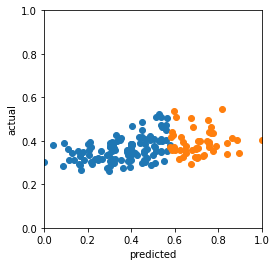

In [12]:
#VAE
tr_y,pred_tr_y,te_y,pred_te_y=imputation_missX(tr_df,te_df,target,imputer=MissAE(mode="VAE"))
visualize_result(tr_y,pred_tr_y,te_y,pred_te_y)

Iter: 0	Train_loss: 0.4748
Iter: 100	Train_loss: 0.1276
Iter: 200	Train_loss: 0.09415
Iter: 300	Train_loss: 0.06689
Iter: 400	Train_loss: 0.05896
Iter: 500	Train_loss: 0.05587
Iter: 600	Train_loss: 0.04778
Iter: 700	Train_loss: 0.0395
Iter: 800	Train_loss: 0.03844
Iter: 900	Train_loss: 0.0341
Iter: 1000	Train_loss: 0.04429
Iter: 1100	Train_loss: 0.04142
Iter: 1200	Train_loss: 0.04272
Iter: 1300	Train_loss: 0.04094
Iter: 1400	Train_loss: 0.03889
Iter: 1500	Train_loss: 0.02973
Iter: 1600	Train_loss: 0.04105
Iter: 1700	Train_loss: 0.02972
Iter: 1800	Train_loss: 0.04145
Iter: 1900	Train_loss: 0.03095
Iter: 2000	Train_loss: 0.0325
Iter: 2100	Train_loss: 0.04336
Iter: 2200	Train_loss: 0.02749
Iter: 2300	Train_loss: 0.03003
Iter: 2400	Train_loss: 0.03385
Iter: 2500	Train_loss: 0.02946
Iter: 2600	Train_loss: 0.03229
Iter: 2700	Train_loss: 0.02798
Iter: 2800	Train_loss: 0.03631
Iter: 2900	Train_loss: 0.03004
Iter: 3000	Train_loss: 0.02747
Iter: 3100	Train_loss: 0.02665
Iter: 3200	Train_loss: 0.

Iter: 0	Train_loss: 0.4848
Iter: 100	Train_loss: 0.1514
Iter: 200	Train_loss: 0.1444
Iter: 300	Train_loss: 0.1269
Iter: 400	Train_loss: 0.1264
Iter: 500	Train_loss: 0.1123
Iter: 600	Train_loss: 0.09749
Iter: 700	Train_loss: 0.08919
Iter: 800	Train_loss: 0.08886
Iter: 900	Train_loss: 0.07541
Iter: 1000	Train_loss: 0.07087
Iter: 1100	Train_loss: 0.06283
Iter: 1200	Train_loss: 0.0647
Iter: 1300	Train_loss: 0.05886
Iter: 1400	Train_loss: 0.05355
Iter: 1500	Train_loss: 0.05677
Iter: 1600	Train_loss: 0.05743
Iter: 1700	Train_loss: 0.05289
Iter: 1800	Train_loss: 0.05012
Iter: 1900	Train_loss: 0.0489
Iter: 2000	Train_loss: 0.0461
Iter: 2100	Train_loss: 0.04641
Iter: 2200	Train_loss: 0.04361
Iter: 2300	Train_loss: 0.04578
Iter: 2400	Train_loss: 0.04895
Iter: 2500	Train_loss: 0.05128
Iter: 2600	Train_loss: 0.04299
Iter: 2700	Train_loss: 0.0423
Iter: 2800	Train_loss: 0.03863
Iter: 2900	Train_loss: 0.04148
Iter: 3000	Train_loss: 0.04225
Iter: 3100	Train_loss: 0.0374
Iter: 3200	Train_loss: 0.04403


Iter: 0	Train_loss: 0.4883
Iter: 100	Train_loss: 0.1644
Iter: 200	Train_loss: 0.1536
Iter: 300	Train_loss: 0.1229
Iter: 400	Train_loss: 0.1091
Iter: 500	Train_loss: 0.1031
Iter: 600	Train_loss: 0.09322
Iter: 700	Train_loss: 0.08125
Iter: 800	Train_loss: 0.07963
Iter: 900	Train_loss: 0.07049
Iter: 1000	Train_loss: 0.06552
Iter: 1100	Train_loss: 0.05952
Iter: 1200	Train_loss: 0.06364
Iter: 1300	Train_loss: 0.05636
Iter: 1400	Train_loss: 0.05222
Iter: 1500	Train_loss: 0.05402
Iter: 1600	Train_loss: 0.05317
Iter: 1700	Train_loss: 0.05603
Iter: 1800	Train_loss: 0.04739
Iter: 1900	Train_loss: 0.04226
Iter: 2000	Train_loss: 0.04971
Iter: 2100	Train_loss: 0.04573
Iter: 2200	Train_loss: 0.04734
Iter: 2300	Train_loss: 0.0455
Iter: 2400	Train_loss: 0.04198
Iter: 2500	Train_loss: 0.03762
Iter: 2600	Train_loss: 0.04791
Iter: 2700	Train_loss: 0.03926
Iter: 2800	Train_loss: 0.04567
Iter: 2900	Train_loss: 0.04791
Iter: 3000	Train_loss: 0.04067
Iter: 3100	Train_loss: 0.0406
Iter: 3200	Train_loss: 0.040

Iter: 0	Train_loss: 0.5089
Iter: 100	Train_loss: 0.1527
Iter: 200	Train_loss: 0.1471
Iter: 300	Train_loss: 0.1469
Iter: 400	Train_loss: 0.1082
Iter: 500	Train_loss: 0.09821
Iter: 600	Train_loss: 0.08823
Iter: 700	Train_loss: 0.08499
Iter: 800	Train_loss: 0.07756
Iter: 900	Train_loss: 0.07087
Iter: 1000	Train_loss: 0.06913
Iter: 1100	Train_loss: 0.06006
Iter: 1200	Train_loss: 0.06895
Iter: 1300	Train_loss: 0.06621
Iter: 1400	Train_loss: 0.05098
Iter: 1500	Train_loss: 0.05548
Iter: 1600	Train_loss: 0.04944
Iter: 1700	Train_loss: 0.05137
Iter: 1800	Train_loss: 0.05608
Iter: 1900	Train_loss: 0.05314
Iter: 2000	Train_loss: 0.05342
Iter: 2100	Train_loss: 0.04817
Iter: 2200	Train_loss: 0.04472
Iter: 2300	Train_loss: 0.04369
Iter: 2400	Train_loss: 0.04504
Iter: 2500	Train_loss: 0.0431
Iter: 2600	Train_loss: 0.04837
Iter: 2700	Train_loss: 0.04954
Iter: 2800	Train_loss: 0.04219
Iter: 2900	Train_loss: 0.0441
Iter: 3000	Train_loss: 0.03853
Iter: 3100	Train_loss: 0.04066
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.4625
Iter: 100	Train_loss: 0.1652
Iter: 200	Train_loss: 0.1421
Iter: 300	Train_loss: 0.1297
Iter: 400	Train_loss: 0.1192
Iter: 500	Train_loss: 0.1022
Iter: 600	Train_loss: 0.09338
Iter: 700	Train_loss: 0.0808
Iter: 800	Train_loss: 0.08088
Iter: 900	Train_loss: 0.07391
Iter: 1000	Train_loss: 0.06967
Iter: 1100	Train_loss: 0.06371
Iter: 1200	Train_loss: 0.06216
Iter: 1300	Train_loss: 0.05692
Iter: 1400	Train_loss: 0.05996
Iter: 1500	Train_loss: 0.05108
Iter: 1600	Train_loss: 0.05662
Iter: 1700	Train_loss: 0.04654
Iter: 1800	Train_loss: 0.0516
Iter: 1900	Train_loss: 0.05089
Iter: 2000	Train_loss: 0.04609
Iter: 2100	Train_loss: 0.04799
Iter: 2200	Train_loss: 0.04185
Iter: 2300	Train_loss: 0.05078
Iter: 2400	Train_loss: 0.04938
Iter: 2500	Train_loss: 0.03871
Iter: 2600	Train_loss: 0.04405
Iter: 2700	Train_loss: 0.04208
Iter: 2800	Train_loss: 0.04686
Iter: 2900	Train_loss: 0.04202
Iter: 3000	Train_loss: 0.03486
Iter: 3100	Train_loss: 0.04326
Iter: 3200	Train_loss: 0.040

Iter: 0	Train_loss: 0.5011
Iter: 100	Train_loss: 0.1498
Iter: 200	Train_loss: 0.154
Iter: 300	Train_loss: 0.1295
Iter: 400	Train_loss: 0.1138
Iter: 500	Train_loss: 0.1067
Iter: 600	Train_loss: 0.09821
Iter: 700	Train_loss: 0.08571
Iter: 800	Train_loss: 0.07933
Iter: 900	Train_loss: 0.07638
Iter: 1000	Train_loss: 0.073
Iter: 1100	Train_loss: 0.06499
Iter: 1200	Train_loss: 0.05783
Iter: 1300	Train_loss: 0.05965
Iter: 1400	Train_loss: 0.06066
Iter: 1500	Train_loss: 0.05205
Iter: 1600	Train_loss: 0.05519
Iter: 1700	Train_loss: 0.04963
Iter: 1800	Train_loss: 0.05805
Iter: 1900	Train_loss: 0.05213
Iter: 2000	Train_loss: 0.05001
Iter: 2100	Train_loss: 0.05037
Iter: 2200	Train_loss: 0.04968
Iter: 2300	Train_loss: 0.05147
Iter: 2400	Train_loss: 0.04697
Iter: 2500	Train_loss: 0.05427
Iter: 2600	Train_loss: 0.03631
Iter: 2700	Train_loss: 0.0435
Iter: 2800	Train_loss: 0.0372
Iter: 2900	Train_loss: 0.04686
Iter: 3000	Train_loss: 0.04474
Iter: 3100	Train_loss: 0.04177
Iter: 3200	Train_loss: 0.04084


Iter: 0	Train_loss: 0.4981
Iter: 100	Train_loss: 0.1617
Iter: 200	Train_loss: 0.1396
Iter: 300	Train_loss: 0.127
Iter: 400	Train_loss: 0.1102
Iter: 500	Train_loss: 0.1035
Iter: 600	Train_loss: 0.08946
Iter: 700	Train_loss: 0.07866
Iter: 800	Train_loss: 0.07356
Iter: 900	Train_loss: 0.06602
Iter: 1000	Train_loss: 0.06695
Iter: 1100	Train_loss: 0.06266
Iter: 1200	Train_loss: 0.06311
Iter: 1300	Train_loss: 0.06017
Iter: 1400	Train_loss: 0.04865
Iter: 1500	Train_loss: 0.05096
Iter: 1600	Train_loss: 0.0533
Iter: 1700	Train_loss: 0.04418
Iter: 1800	Train_loss: 0.04829
Iter: 1900	Train_loss: 0.04676
Iter: 2000	Train_loss: 0.0521
Iter: 2100	Train_loss: 0.04639
Iter: 2200	Train_loss: 0.03985
Iter: 2300	Train_loss: 0.04797
Iter: 2400	Train_loss: 0.0431
Iter: 2500	Train_loss: 0.04629
Iter: 2600	Train_loss: 0.03654
Iter: 2700	Train_loss: 0.04086
Iter: 2800	Train_loss: 0.04296
Iter: 2900	Train_loss: 0.04157
Iter: 3000	Train_loss: 0.03744
Iter: 3100	Train_loss: 0.04284
Iter: 3200	Train_loss: 0.03783

Iter: 0	Train_loss: 0.5189
Iter: 100	Train_loss: 0.1695
Iter: 200	Train_loss: 0.1454
Iter: 300	Train_loss: 0.1339
Iter: 400	Train_loss: 0.1265
Iter: 500	Train_loss: 0.1094
Iter: 600	Train_loss: 0.09639
Iter: 700	Train_loss: 0.09175
Iter: 800	Train_loss: 0.07745
Iter: 900	Train_loss: 0.07397
Iter: 1000	Train_loss: 0.07074
Iter: 1100	Train_loss: 0.07277
Iter: 1200	Train_loss: 0.06211
Iter: 1300	Train_loss: 0.0651
Iter: 1400	Train_loss: 0.0618
Iter: 1500	Train_loss: 0.05921
Iter: 1600	Train_loss: 0.05426
Iter: 1700	Train_loss: 0.04697
Iter: 1800	Train_loss: 0.05255
Iter: 1900	Train_loss: 0.04451
Iter: 2000	Train_loss: 0.04937
Iter: 2100	Train_loss: 0.05027
Iter: 2200	Train_loss: 0.04763
Iter: 2300	Train_loss: 0.05009
Iter: 2400	Train_loss: 0.04985
Iter: 2500	Train_loss: 0.04412
Iter: 2600	Train_loss: 0.04513
Iter: 2700	Train_loss: 0.04361
Iter: 2800	Train_loss: 0.04158
Iter: 2900	Train_loss: 0.04499
Iter: 3000	Train_loss: 0.04598
Iter: 3100	Train_loss: 0.03899
Iter: 3200	Train_loss: 0.041

Iter: 0	Train_loss: 0.5088
Iter: 100	Train_loss: 0.1543
Iter: 200	Train_loss: 0.1419
Iter: 300	Train_loss: 0.1246
Iter: 400	Train_loss: 0.1166
Iter: 500	Train_loss: 0.1026
Iter: 600	Train_loss: 0.09317
Iter: 700	Train_loss: 0.08978
Iter: 800	Train_loss: 0.07507
Iter: 900	Train_loss: 0.07253
Iter: 1000	Train_loss: 0.07221
Iter: 1100	Train_loss: 0.05395
Iter: 1200	Train_loss: 0.06047
Iter: 1300	Train_loss: 0.04576
Iter: 1400	Train_loss: 0.05097
Iter: 1500	Train_loss: 0.05258
Iter: 1600	Train_loss: 0.0526
Iter: 1700	Train_loss: 0.05324
Iter: 1800	Train_loss: 0.05213
Iter: 1900	Train_loss: 0.0472
Iter: 2000	Train_loss: 0.04236
Iter: 2100	Train_loss: 0.04377
Iter: 2200	Train_loss: 0.04895
Iter: 2300	Train_loss: 0.04365
Iter: 2400	Train_loss: 0.04989
Iter: 2500	Train_loss: 0.04679
Iter: 2600	Train_loss: 0.04297
Iter: 2700	Train_loss: 0.03828
Iter: 2800	Train_loss: 0.04271
Iter: 2900	Train_loss: 0.04175
Iter: 3000	Train_loss: 0.0393
Iter: 3100	Train_loss: 0.04054
Iter: 3200	Train_loss: 0.0407

Iter: 0	Train_loss: 0.5091
Iter: 100	Train_loss: 0.1582
Iter: 200	Train_loss: 0.1437
Iter: 300	Train_loss: 0.1295
Iter: 400	Train_loss: 0.1187
Iter: 500	Train_loss: 0.1026
Iter: 600	Train_loss: 0.09318
Iter: 700	Train_loss: 0.08546
Iter: 800	Train_loss: 0.07822
Iter: 900	Train_loss: 0.07438
Iter: 1000	Train_loss: 0.0663
Iter: 1100	Train_loss: 0.06765
Iter: 1200	Train_loss: 0.06253
Iter: 1300	Train_loss: 0.05743
Iter: 1400	Train_loss: 0.05502
Iter: 1500	Train_loss: 0.05667
Iter: 1600	Train_loss: 0.05703
Iter: 1700	Train_loss: 0.04422
Iter: 1800	Train_loss: 0.0511
Iter: 1900	Train_loss: 0.04976
Iter: 2000	Train_loss: 0.04619
Iter: 2100	Train_loss: 0.0526
Iter: 2200	Train_loss: 0.0506
Iter: 2300	Train_loss: 0.05167
Iter: 2400	Train_loss: 0.04791
Iter: 2500	Train_loss: 0.04398
Iter: 2600	Train_loss: 0.04054
Iter: 2700	Train_loss: 0.04326
Iter: 2800	Train_loss: 0.04746
Iter: 2900	Train_loss: 0.04709
Iter: 3000	Train_loss: 0.03421
Iter: 3100	Train_loss: 0.04425
Iter: 3200	Train_loss: 0.03459

Iter: 0	Train_loss: 0.5226
Iter: 100	Train_loss: 0.1468
Iter: 200	Train_loss: 0.155
Iter: 300	Train_loss: 0.1293
Iter: 400	Train_loss: 0.1127
Iter: 500	Train_loss: 0.1048
Iter: 600	Train_loss: 0.08722
Iter: 700	Train_loss: 0.08643
Iter: 800	Train_loss: 0.07843
Iter: 900	Train_loss: 0.0779
Iter: 1000	Train_loss: 0.07206
Iter: 1100	Train_loss: 0.07263
Iter: 1200	Train_loss: 0.06222
Iter: 1300	Train_loss: 0.06359
Iter: 1400	Train_loss: 0.0567
Iter: 1500	Train_loss: 0.06068
Iter: 1600	Train_loss: 0.05969
Iter: 1700	Train_loss: 0.05477
Iter: 1800	Train_loss: 0.05008
Iter: 1900	Train_loss: 0.05058
Iter: 2000	Train_loss: 0.04432
Iter: 2100	Train_loss: 0.05038
Iter: 2200	Train_loss: 0.04735
Iter: 2300	Train_loss: 0.05111
Iter: 2400	Train_loss: 0.04672
Iter: 2500	Train_loss: 0.04144
Iter: 2600	Train_loss: 0.05578
Iter: 2700	Train_loss: 0.03919
Iter: 2800	Train_loss: 0.03736
Iter: 2900	Train_loss: 0.0528
Iter: 3000	Train_loss: 0.0422
Iter: 3100	Train_loss: 0.04455
Iter: 3200	Train_loss: 0.03601


Iter: 0	Train_loss: 0.5037
Iter: 100	Train_loss: 0.1593
Iter: 200	Train_loss: 0.1452
Iter: 300	Train_loss: 0.1311
Iter: 400	Train_loss: 0.1208
Iter: 500	Train_loss: 0.09807
Iter: 600	Train_loss: 0.08345
Iter: 700	Train_loss: 0.08568
Iter: 800	Train_loss: 0.08789
Iter: 900	Train_loss: 0.07511
Iter: 1000	Train_loss: 0.07357
Iter: 1100	Train_loss: 0.06695
Iter: 1200	Train_loss: 0.06993
Iter: 1300	Train_loss: 0.05762
Iter: 1400	Train_loss: 0.05699
Iter: 1500	Train_loss: 0.05157
Iter: 1600	Train_loss: 0.05617
Iter: 1700	Train_loss: 0.05694
Iter: 1800	Train_loss: 0.04995
Iter: 1900	Train_loss: 0.05524
Iter: 2000	Train_loss: 0.0511
Iter: 2100	Train_loss: 0.04465
Iter: 2200	Train_loss: 0.04671
Iter: 2300	Train_loss: 0.04248
Iter: 2400	Train_loss: 0.04161
Iter: 2500	Train_loss: 0.03745
Iter: 2600	Train_loss: 0.04912
Iter: 2700	Train_loss: 0.04695
Iter: 2800	Train_loss: 0.04015
Iter: 2900	Train_loss: 0.04977
Iter: 3000	Train_loss: 0.03978
Iter: 3100	Train_loss: 0.04261
Iter: 3200	Train_loss: 0.0

Iter: 0	Train_loss: 0.4897
Iter: 100	Train_loss: 0.1686
Iter: 200	Train_loss: 0.1424
Iter: 300	Train_loss: 0.1247
Iter: 400	Train_loss: 0.1144
Iter: 500	Train_loss: 0.09809
Iter: 600	Train_loss: 0.08652
Iter: 700	Train_loss: 0.07783
Iter: 800	Train_loss: 0.06926
Iter: 900	Train_loss: 0.07019
Iter: 1000	Train_loss: 0.07015
Iter: 1100	Train_loss: 0.06231
Iter: 1200	Train_loss: 0.05655
Iter: 1300	Train_loss: 0.05915
Iter: 1400	Train_loss: 0.06069
Iter: 1500	Train_loss: 0.05663
Iter: 1600	Train_loss: 0.05974
Iter: 1700	Train_loss: 0.05264
Iter: 1800	Train_loss: 0.04274
Iter: 1900	Train_loss: 0.05009
Iter: 2000	Train_loss: 0.04301
Iter: 2100	Train_loss: 0.05138
Iter: 2200	Train_loss: 0.04598
Iter: 2300	Train_loss: 0.04671
Iter: 2400	Train_loss: 0.04314
Iter: 2500	Train_loss: 0.041
Iter: 2600	Train_loss: 0.04736
Iter: 2700	Train_loss: 0.04399
Iter: 2800	Train_loss: 0.0395
Iter: 2900	Train_loss: 0.03553
Iter: 3000	Train_loss: 0.04017
Iter: 3100	Train_loss: 0.04068
Iter: 3200	Train_loss: 0.033

Iter: 0	Train_loss: 0.4908
Iter: 100	Train_loss: 0.1621
Iter: 200	Train_loss: 0.1413
Iter: 300	Train_loss: 0.1267
Iter: 400	Train_loss: 0.1084
Iter: 500	Train_loss: 0.09826
Iter: 600	Train_loss: 0.08536
Iter: 700	Train_loss: 0.08654
Iter: 800	Train_loss: 0.0769
Iter: 900	Train_loss: 0.07521
Iter: 1000	Train_loss: 0.06197
Iter: 1100	Train_loss: 0.06481
Iter: 1200	Train_loss: 0.06123
Iter: 1300	Train_loss: 0.05577
Iter: 1400	Train_loss: 0.06107
Iter: 1500	Train_loss: 0.06114
Iter: 1600	Train_loss: 0.06015
Iter: 1700	Train_loss: 0.05378
Iter: 1800	Train_loss: 0.05642
Iter: 1900	Train_loss: 0.04669
Iter: 2000	Train_loss: 0.04985
Iter: 2100	Train_loss: 0.04883
Iter: 2200	Train_loss: 0.05274
Iter: 2300	Train_loss: 0.04967
Iter: 2400	Train_loss: 0.04619
Iter: 2500	Train_loss: 0.04341
Iter: 2600	Train_loss: 0.04932
Iter: 2700	Train_loss: 0.03829
Iter: 2800	Train_loss: 0.04389
Iter: 2900	Train_loss: 0.04815
Iter: 3000	Train_loss: 0.04332
Iter: 3100	Train_loss: 0.0459
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.522
Iter: 100	Train_loss: 0.1493
Iter: 200	Train_loss: 0.1468
Iter: 300	Train_loss: 0.127
Iter: 400	Train_loss: 0.1123
Iter: 500	Train_loss: 0.0994
Iter: 600	Train_loss: 0.0947
Iter: 700	Train_loss: 0.0804
Iter: 800	Train_loss: 0.07387
Iter: 900	Train_loss: 0.06919
Iter: 1000	Train_loss: 0.07074
Iter: 1100	Train_loss: 0.06409
Iter: 1200	Train_loss: 0.06461
Iter: 1300	Train_loss: 0.06032
Iter: 1400	Train_loss: 0.04833
Iter: 1500	Train_loss: 0.04787
Iter: 1600	Train_loss: 0.05734
Iter: 1700	Train_loss: 0.05547
Iter: 1800	Train_loss: 0.04755
Iter: 1900	Train_loss: 0.05167
Iter: 2000	Train_loss: 0.04482
Iter: 2100	Train_loss: 0.04833
Iter: 2200	Train_loss: 0.05141
Iter: 2300	Train_loss: 0.05215
Iter: 2400	Train_loss: 0.0455
Iter: 2500	Train_loss: 0.04888
Iter: 2600	Train_loss: 0.04595
Iter: 2700	Train_loss: 0.04535
Iter: 2800	Train_loss: 0.04815
Iter: 2900	Train_loss: 0.03591
Iter: 3000	Train_loss: 0.04433
Iter: 3100	Train_loss: 0.04343
Iter: 3200	Train_loss: 0.03673


Iter: 0	Train_loss: 0.4916
Iter: 100	Train_loss: 0.1594
Iter: 200	Train_loss: 0.1426
Iter: 300	Train_loss: 0.124
Iter: 400	Train_loss: 0.1111
Iter: 500	Train_loss: 0.107
Iter: 600	Train_loss: 0.08929
Iter: 700	Train_loss: 0.08426
Iter: 800	Train_loss: 0.07585
Iter: 900	Train_loss: 0.07554
Iter: 1000	Train_loss: 0.07041
Iter: 1100	Train_loss: 0.06519
Iter: 1200	Train_loss: 0.06145
Iter: 1300	Train_loss: 0.06443
Iter: 1400	Train_loss: 0.04993
Iter: 1500	Train_loss: 0.05462
Iter: 1600	Train_loss: 0.05311
Iter: 1700	Train_loss: 0.05573
Iter: 1800	Train_loss: 0.04892
Iter: 1900	Train_loss: 0.04786
Iter: 2000	Train_loss: 0.04921
Iter: 2100	Train_loss: 0.05402
Iter: 2200	Train_loss: 0.04991
Iter: 2300	Train_loss: 0.04006
Iter: 2400	Train_loss: 0.04487
Iter: 2500	Train_loss: 0.04867
Iter: 2600	Train_loss: 0.04045
Iter: 2700	Train_loss: 0.04326
Iter: 2800	Train_loss: 0.04152
Iter: 2900	Train_loss: 0.04296
Iter: 3000	Train_loss: 0.04174
Iter: 3100	Train_loss: 0.04984
Iter: 3200	Train_loss: 0.040

Iter: 0	Train_loss: 0.4989
Iter: 100	Train_loss: 0.1429
Iter: 200	Train_loss: 0.1405
Iter: 300	Train_loss: 0.1269
Iter: 400	Train_loss: 0.1117
Iter: 500	Train_loss: 0.09879
Iter: 600	Train_loss: 0.09776
Iter: 700	Train_loss: 0.08236
Iter: 800	Train_loss: 0.08044
Iter: 900	Train_loss: 0.07304
Iter: 1000	Train_loss: 0.06439
Iter: 1100	Train_loss: 0.06374
Iter: 1200	Train_loss: 0.05946
Iter: 1300	Train_loss: 0.05908
Iter: 1400	Train_loss: 0.0592
Iter: 1500	Train_loss: 0.05917
Iter: 1600	Train_loss: 0.05375
Iter: 1700	Train_loss: 0.05221
Iter: 1800	Train_loss: 0.05354
Iter: 1900	Train_loss: 0.05055
Iter: 2000	Train_loss: 0.05354
Iter: 2100	Train_loss: 0.04726
Iter: 2200	Train_loss: 0.04909
Iter: 2300	Train_loss: 0.04869
Iter: 2400	Train_loss: 0.04625
Iter: 2500	Train_loss: 0.04122
Iter: 2600	Train_loss: 0.04954
Iter: 2700	Train_loss: 0.04331
Iter: 2800	Train_loss: 0.05215
Iter: 2900	Train_loss: 0.05018
Iter: 3000	Train_loss: 0.04197
Iter: 3100	Train_loss: 0.04705
Iter: 3200	Train_loss: 0.0

Iter: 0	Train_loss: 0.5229
Iter: 100	Train_loss: 0.164
Iter: 200	Train_loss: 0.1624
Iter: 300	Train_loss: 0.1359
Iter: 400	Train_loss: 0.1181
Iter: 500	Train_loss: 0.111
Iter: 600	Train_loss: 0.09426
Iter: 700	Train_loss: 0.08359
Iter: 800	Train_loss: 0.07953
Iter: 900	Train_loss: 0.08189
Iter: 1000	Train_loss: 0.06675
Iter: 1100	Train_loss: 0.06243
Iter: 1200	Train_loss: 0.06297
Iter: 1300	Train_loss: 0.05783
Iter: 1400	Train_loss: 0.05336
Iter: 1500	Train_loss: 0.05597
Iter: 1600	Train_loss: 0.0554
Iter: 1700	Train_loss: 0.04902
Iter: 1800	Train_loss: 0.04735
Iter: 1900	Train_loss: 0.05082
Iter: 2000	Train_loss: 0.04545
Iter: 2100	Train_loss: 0.04104
Iter: 2200	Train_loss: 0.0525
Iter: 2300	Train_loss: 0.04975
Iter: 2400	Train_loss: 0.05261
Iter: 2500	Train_loss: 0.03838
Iter: 2600	Train_loss: 0.04312
Iter: 2700	Train_loss: 0.04644
Iter: 2800	Train_loss: 0.04029
Iter: 2900	Train_loss: 0.03828
Iter: 3000	Train_loss: 0.04334
Iter: 3100	Train_loss: 0.03831
Iter: 3200	Train_loss: 0.04243

Iter: 0	Train_loss: 0.4919
Iter: 100	Train_loss: 0.1481
Iter: 200	Train_loss: 0.1555
Iter: 300	Train_loss: 0.1278
Iter: 400	Train_loss: 0.1241
Iter: 500	Train_loss: 0.09801
Iter: 600	Train_loss: 0.092
Iter: 700	Train_loss: 0.07842
Iter: 800	Train_loss: 0.07733
Iter: 900	Train_loss: 0.07087
Iter: 1000	Train_loss: 0.06338
Iter: 1100	Train_loss: 0.05685
Iter: 1200	Train_loss: 0.05455
Iter: 1300	Train_loss: 0.05908
Iter: 1400	Train_loss: 0.05935
Iter: 1500	Train_loss: 0.04999
Iter: 1600	Train_loss: 0.04841
Iter: 1700	Train_loss: 0.05316
Iter: 1800	Train_loss: 0.0481
Iter: 1900	Train_loss: 0.04879
Iter: 2000	Train_loss: 0.04819
Iter: 2100	Train_loss: 0.03996
Iter: 2200	Train_loss: 0.03981
Iter: 2300	Train_loss: 0.03881
Iter: 2400	Train_loss: 0.04215
Iter: 2500	Train_loss: 0.03879
Iter: 2600	Train_loss: 0.03604
Iter: 2700	Train_loss: 0.0446
Iter: 2800	Train_loss: 0.03585
Iter: 2900	Train_loss: 0.04383
Iter: 3000	Train_loss: 0.04161
Iter: 3100	Train_loss: 0.03609
Iter: 3200	Train_loss: 0.0422

Iter: 0	Train_loss: 0.4905
Iter: 100	Train_loss: 0.1589
Iter: 200	Train_loss: 0.1536
Iter: 300	Train_loss: 0.1185
Iter: 400	Train_loss: 0.1157
Iter: 500	Train_loss: 0.09911
Iter: 600	Train_loss: 0.09691
Iter: 700	Train_loss: 0.08933
Iter: 800	Train_loss: 0.07225
Iter: 900	Train_loss: 0.07442
Iter: 1000	Train_loss: 0.07054
Iter: 1100	Train_loss: 0.06379
Iter: 1200	Train_loss: 0.0604
Iter: 1300	Train_loss: 0.0544
Iter: 1400	Train_loss: 0.05787
Iter: 1500	Train_loss: 0.05705
Iter: 1600	Train_loss: 0.05638
Iter: 1700	Train_loss: 0.05158
Iter: 1800	Train_loss: 0.0557
Iter: 1900	Train_loss: 0.04743
Iter: 2000	Train_loss: 0.04693
Iter: 2100	Train_loss: 0.05084
Iter: 2200	Train_loss: 0.05154
Iter: 2300	Train_loss: 0.04154
Iter: 2400	Train_loss: 0.04219
Iter: 2500	Train_loss: 0.04614
Iter: 2600	Train_loss: 0.04848
Iter: 2700	Train_loss: 0.04144
Iter: 2800	Train_loss: 0.04721
Iter: 2900	Train_loss: 0.04175
Iter: 3000	Train_loss: 0.05125
Iter: 3100	Train_loss: 0.03729
Iter: 3200	Train_loss: 0.038

Iter: 0	Train_loss: 0.5107
Iter: 100	Train_loss: 0.1645
Iter: 200	Train_loss: 0.1404
Iter: 300	Train_loss: 0.1292
Iter: 400	Train_loss: 0.121
Iter: 500	Train_loss: 0.1129
Iter: 600	Train_loss: 0.09989
Iter: 700	Train_loss: 0.09452
Iter: 800	Train_loss: 0.0844
Iter: 900	Train_loss: 0.07816
Iter: 1000	Train_loss: 0.07496
Iter: 1100	Train_loss: 0.0684
Iter: 1200	Train_loss: 0.06092
Iter: 1300	Train_loss: 0.06822
Iter: 1400	Train_loss: 0.06247
Iter: 1500	Train_loss: 0.06526
Iter: 1600	Train_loss: 0.04997
Iter: 1700	Train_loss: 0.06053
Iter: 1800	Train_loss: 0.05747
Iter: 1900	Train_loss: 0.049
Iter: 2000	Train_loss: 0.04717
Iter: 2100	Train_loss: 0.05743
Iter: 2200	Train_loss: 0.05494
Iter: 2300	Train_loss: 0.04589
Iter: 2400	Train_loss: 0.05176
Iter: 2500	Train_loss: 0.04696
Iter: 2600	Train_loss: 0.04568
Iter: 2700	Train_loss: 0.04883
Iter: 2800	Train_loss: 0.05061
Iter: 2900	Train_loss: 0.04775
Iter: 3000	Train_loss: 0.04214
Iter: 3100	Train_loss: 0.04216
Iter: 3200	Train_loss: 0.0388
I

Iter: 0	Train_loss: 0.5025
Iter: 100	Train_loss: 0.1678
Iter: 200	Train_loss: 0.1583
Iter: 300	Train_loss: 0.1385
Iter: 400	Train_loss: 0.1292
Iter: 500	Train_loss: 0.1105
Iter: 600	Train_loss: 0.09934
Iter: 700	Train_loss: 0.0885
Iter: 800	Train_loss: 0.08334
Iter: 900	Train_loss: 0.07896
Iter: 1000	Train_loss: 0.07495
Iter: 1100	Train_loss: 0.0731
Iter: 1200	Train_loss: 0.06778
Iter: 1300	Train_loss: 0.05632
Iter: 1400	Train_loss: 0.0576
Iter: 1500	Train_loss: 0.05497
Iter: 1600	Train_loss: 0.05758
Iter: 1700	Train_loss: 0.05323
Iter: 1800	Train_loss: 0.05293
Iter: 1900	Train_loss: 0.05107
Iter: 2000	Train_loss: 0.04531
Iter: 2100	Train_loss: 0.05069
Iter: 2200	Train_loss: 0.04834
Iter: 2300	Train_loss: 0.04481
Iter: 2400	Train_loss: 0.04142
Iter: 2500	Train_loss: 0.04307
Iter: 2600	Train_loss: 0.03888
Iter: 2700	Train_loss: 0.05054
Iter: 2800	Train_loss: 0.04498
Iter: 2900	Train_loss: 0.04984
Iter: 3000	Train_loss: 0.0369
Iter: 3100	Train_loss: 0.04601
Iter: 3200	Train_loss: 0.04674

Iter: 0	Train_loss: 0.4907
Iter: 100	Train_loss: 0.1519
Iter: 200	Train_loss: 0.1356
Iter: 300	Train_loss: 0.1306
Iter: 400	Train_loss: 0.1112
Iter: 500	Train_loss: 0.1017
Iter: 600	Train_loss: 0.09013
Iter: 700	Train_loss: 0.08695
Iter: 800	Train_loss: 0.08053
Iter: 900	Train_loss: 0.0715
Iter: 1000	Train_loss: 0.06777
Iter: 1100	Train_loss: 0.0705
Iter: 1200	Train_loss: 0.06386
Iter: 1300	Train_loss: 0.05792
Iter: 1400	Train_loss: 0.05922
Iter: 1500	Train_loss: 0.05916
Iter: 1600	Train_loss: 0.05579
Iter: 1700	Train_loss: 0.05012
Iter: 1800	Train_loss: 0.05498
Iter: 1900	Train_loss: 0.05837
Iter: 2000	Train_loss: 0.04769
Iter: 2100	Train_loss: 0.0451
Iter: 2200	Train_loss: 0.05294
Iter: 2300	Train_loss: 0.0437
Iter: 2400	Train_loss: 0.0415
Iter: 2500	Train_loss: 0.04546
Iter: 2600	Train_loss: 0.04771
Iter: 2700	Train_loss: 0.04694
Iter: 2800	Train_loss: 0.04487
Iter: 2900	Train_loss: 0.03676
Iter: 3000	Train_loss: 0.0366
Iter: 3100	Train_loss: 0.03891
Iter: 3200	Train_loss: 0.042
Ite

Iter: 0	Train_loss: 0.5218
Iter: 100	Train_loss: 0.1569
Iter: 200	Train_loss: 0.1603
Iter: 300	Train_loss: 0.1308
Iter: 400	Train_loss: 0.1309
Iter: 500	Train_loss: 0.104
Iter: 600	Train_loss: 0.1065
Iter: 700	Train_loss: 0.09438
Iter: 800	Train_loss: 0.08175
Iter: 900	Train_loss: 0.07286
Iter: 1000	Train_loss: 0.08257
Iter: 1100	Train_loss: 0.07157
Iter: 1200	Train_loss: 0.06234
Iter: 1300	Train_loss: 0.06589
Iter: 1400	Train_loss: 0.06325
Iter: 1500	Train_loss: 0.05866
Iter: 1600	Train_loss: 0.05864
Iter: 1700	Train_loss: 0.05297
Iter: 1800	Train_loss: 0.05534
Iter: 1900	Train_loss: 0.05138
Iter: 2000	Train_loss: 0.04733
Iter: 2100	Train_loss: 0.05454
Iter: 2200	Train_loss: 0.04848
Iter: 2300	Train_loss: 0.05494
Iter: 2400	Train_loss: 0.04864
Iter: 2500	Train_loss: 0.04593
Iter: 2600	Train_loss: 0.04706
Iter: 2700	Train_loss: 0.0444
Iter: 2800	Train_loss: 0.04028
Iter: 2900	Train_loss: 0.04811
Iter: 3000	Train_loss: 0.04081
Iter: 3100	Train_loss: 0.05422
Iter: 3200	Train_loss: 0.0461

Iter: 0	Train_loss: 0.5085
Iter: 100	Train_loss: 0.1575
Iter: 200	Train_loss: 0.1418
Iter: 300	Train_loss: 0.1206
Iter: 400	Train_loss: 0.1157
Iter: 500	Train_loss: 0.09729
Iter: 600	Train_loss: 0.09252
Iter: 700	Train_loss: 0.08348
Iter: 800	Train_loss: 0.08616
Iter: 900	Train_loss: 0.07241
Iter: 1000	Train_loss: 0.07102
Iter: 1100	Train_loss: 0.06343
Iter: 1200	Train_loss: 0.06028
Iter: 1300	Train_loss: 0.05787
Iter: 1400	Train_loss: 0.05273
Iter: 1500	Train_loss: 0.05871
Iter: 1600	Train_loss: 0.0609
Iter: 1700	Train_loss: 0.05133
Iter: 1800	Train_loss: 0.04792
Iter: 1900	Train_loss: 0.05014
Iter: 2000	Train_loss: 0.05268
Iter: 2100	Train_loss: 0.04347
Iter: 2200	Train_loss: 0.04331
Iter: 2300	Train_loss: 0.04786
Iter: 2400	Train_loss: 0.04997
Iter: 2500	Train_loss: 0.04285
Iter: 2600	Train_loss: 0.0429
Iter: 2700	Train_loss: 0.04898
Iter: 2800	Train_loss: 0.03759
Iter: 2900	Train_loss: 0.04269
Iter: 3000	Train_loss: 0.04128
Iter: 3100	Train_loss: 0.03971
Iter: 3200	Train_loss: 0.03

Iter: 0	Train_loss: 0.4914
Iter: 100	Train_loss: 0.1572
Iter: 200	Train_loss: 0.15
Iter: 300	Train_loss: 0.1225
Iter: 400	Train_loss: 0.117
Iter: 500	Train_loss: 0.1089
Iter: 600	Train_loss: 0.09552
Iter: 700	Train_loss: 0.08466
Iter: 800	Train_loss: 0.07642
Iter: 900	Train_loss: 0.07648
Iter: 1000	Train_loss: 0.07224
Iter: 1100	Train_loss: 0.06739
Iter: 1200	Train_loss: 0.06289
Iter: 1300	Train_loss: 0.0566
Iter: 1400	Train_loss: 0.06301
Iter: 1500	Train_loss: 0.05981
Iter: 1600	Train_loss: 0.05552
Iter: 1700	Train_loss: 0.05195
Iter: 1800	Train_loss: 0.0495
Iter: 1900	Train_loss: 0.05056
Iter: 2000	Train_loss: 0.05099
Iter: 2100	Train_loss: 0.05017
Iter: 2200	Train_loss: 0.05067
Iter: 2300	Train_loss: 0.04601
Iter: 2400	Train_loss: 0.04712
Iter: 2500	Train_loss: 0.04108
Iter: 2600	Train_loss: 0.04702
Iter: 2700	Train_loss: 0.04147
Iter: 2800	Train_loss: 0.04306
Iter: 2900	Train_loss: 0.04163
Iter: 3000	Train_loss: 0.04232
Iter: 3100	Train_loss: 0.03567
Iter: 3200	Train_loss: 0.04277


Iter: 0	Train_loss: 0.5131
Iter: 100	Train_loss: 0.1667
Iter: 200	Train_loss: 0.1387
Iter: 300	Train_loss: 0.1426
Iter: 400	Train_loss: 0.1089
Iter: 500	Train_loss: 0.1051
Iter: 600	Train_loss: 0.0878
Iter: 700	Train_loss: 0.08655
Iter: 800	Train_loss: 0.07362
Iter: 900	Train_loss: 0.06863
Iter: 1000	Train_loss: 0.06683
Iter: 1100	Train_loss: 0.06265
Iter: 1200	Train_loss: 0.0595
Iter: 1300	Train_loss: 0.05755
Iter: 1400	Train_loss: 0.05617
Iter: 1500	Train_loss: 0.0538
Iter: 1600	Train_loss: 0.04967
Iter: 1700	Train_loss: 0.05476
Iter: 1800	Train_loss: 0.04699
Iter: 1900	Train_loss: 0.04538
Iter: 2000	Train_loss: 0.04875
Iter: 2100	Train_loss: 0.05081
Iter: 2200	Train_loss: 0.04615
Iter: 2300	Train_loss: 0.05033
Iter: 2400	Train_loss: 0.04326
Iter: 2500	Train_loss: 0.04551
Iter: 2600	Train_loss: 0.04715
Iter: 2700	Train_loss: 0.04845
Iter: 2800	Train_loss: 0.05326
Iter: 2900	Train_loss: 0.0517
Iter: 3000	Train_loss: 0.03401
Iter: 3100	Train_loss: 0.0356
Iter: 3200	Train_loss: 0.041
It

Iter: 0	Train_loss: 0.5
Iter: 100	Train_loss: 0.1588
Iter: 200	Train_loss: 0.1483
Iter: 300	Train_loss: 0.1313
Iter: 400	Train_loss: 0.1122
Iter: 500	Train_loss: 0.1041
Iter: 600	Train_loss: 0.08743
Iter: 700	Train_loss: 0.0757
Iter: 800	Train_loss: 0.07402
Iter: 900	Train_loss: 0.06884
Iter: 1000	Train_loss: 0.05968
Iter: 1100	Train_loss: 0.05461
Iter: 1200	Train_loss: 0.06145
Iter: 1300	Train_loss: 0.06271
Iter: 1400	Train_loss: 0.05903
Iter: 1500	Train_loss: 0.0602
Iter: 1600	Train_loss: 0.05167
Iter: 1700	Train_loss: 0.05211
Iter: 1800	Train_loss: 0.05014
Iter: 1900	Train_loss: 0.04365
Iter: 2000	Train_loss: 0.0489
Iter: 2100	Train_loss: 0.04569
Iter: 2200	Train_loss: 0.04521
Iter: 2300	Train_loss: 0.04382
Iter: 2400	Train_loss: 0.04915
Iter: 2500	Train_loss: 0.0425
Iter: 2600	Train_loss: 0.0455
Iter: 2700	Train_loss: 0.04488
Iter: 2800	Train_loss: 0.03944
Iter: 2900	Train_loss: 0.04236
Iter: 3000	Train_loss: 0.04146
Iter: 3100	Train_loss: 0.03709
Iter: 3200	Train_loss: 0.03787
Ite

Iter: 0	Train_loss: 0.4716
Iter: 100	Train_loss: 0.1683
Iter: 200	Train_loss: 0.1396
Iter: 300	Train_loss: 0.1291
Iter: 400	Train_loss: 0.1199
Iter: 500	Train_loss: 0.1042
Iter: 600	Train_loss: 0.09157
Iter: 700	Train_loss: 0.0799
Iter: 800	Train_loss: 0.07387
Iter: 900	Train_loss: 0.07117
Iter: 1000	Train_loss: 0.06926
Iter: 1100	Train_loss: 0.06654
Iter: 1200	Train_loss: 0.06257
Iter: 1300	Train_loss: 0.06261
Iter: 1400	Train_loss: 0.05832
Iter: 1500	Train_loss: 0.05169
Iter: 1600	Train_loss: 0.06135
Iter: 1700	Train_loss: 0.0524
Iter: 1800	Train_loss: 0.0515
Iter: 1900	Train_loss: 0.04943
Iter: 2000	Train_loss: 0.04532
Iter: 2100	Train_loss: 0.039
Iter: 2200	Train_loss: 0.04285
Iter: 2300	Train_loss: 0.04318
Iter: 2400	Train_loss: 0.04482
Iter: 2500	Train_loss: 0.04029
Iter: 2600	Train_loss: 0.04435
Iter: 2700	Train_loss: 0.042
Iter: 2800	Train_loss: 0.05164
Iter: 2900	Train_loss: 0.04461
Iter: 3000	Train_loss: 0.04205
Iter: 3100	Train_loss: 0.03878
Iter: 3200	Train_loss: 0.04643
It

Iter: 0	Train_loss: 0.5081
Iter: 100	Train_loss: 0.166
Iter: 200	Train_loss: 0.1333
Iter: 300	Train_loss: 0.1338
Iter: 400	Train_loss: 0.1135
Iter: 500	Train_loss: 0.09929
Iter: 600	Train_loss: 0.08687
Iter: 700	Train_loss: 0.08108
Iter: 800	Train_loss: 0.07316
Iter: 900	Train_loss: 0.06689
Iter: 1000	Train_loss: 0.06557
Iter: 1100	Train_loss: 0.0613
Iter: 1200	Train_loss: 0.06282
Iter: 1300	Train_loss: 0.06021
Iter: 1400	Train_loss: 0.05749
Iter: 1500	Train_loss: 0.05541
Iter: 1600	Train_loss: 0.05193
Iter: 1700	Train_loss: 0.04801
Iter: 1800	Train_loss: 0.05129
Iter: 1900	Train_loss: 0.05868
Iter: 2000	Train_loss: 0.04748
Iter: 2100	Train_loss: 0.04254
Iter: 2200	Train_loss: 0.04593
Iter: 2300	Train_loss: 0.04174
Iter: 2400	Train_loss: 0.04549
Iter: 2500	Train_loss: 0.04926
Iter: 2600	Train_loss: 0.04846
Iter: 2700	Train_loss: 0.04027
Iter: 2800	Train_loss: 0.0376
Iter: 2900	Train_loss: 0.04595
Iter: 3000	Train_loss: 0.04019
Iter: 3100	Train_loss: 0.03704
Iter: 3200	Train_loss: 0.036

Iter: 0	Train_loss: 0.4824
Iter: 100	Train_loss: 0.1723
Iter: 200	Train_loss: 0.159
Iter: 300	Train_loss: 0.1276
Iter: 400	Train_loss: 0.1179
Iter: 500	Train_loss: 0.1137
Iter: 600	Train_loss: 0.1015
Iter: 700	Train_loss: 0.08776
Iter: 800	Train_loss: 0.08167
Iter: 900	Train_loss: 0.07658
Iter: 1000	Train_loss: 0.06767
Iter: 1100	Train_loss: 0.06722
Iter: 1200	Train_loss: 0.0634
Iter: 1300	Train_loss: 0.05858
Iter: 1400	Train_loss: 0.05795
Iter: 1500	Train_loss: 0.05434
Iter: 1600	Train_loss: 0.05338
Iter: 1700	Train_loss: 0.04737
Iter: 1800	Train_loss: 0.05779
Iter: 1900	Train_loss: 0.04987
Iter: 2000	Train_loss: 0.04738
Iter: 2100	Train_loss: 0.05022
Iter: 2200	Train_loss: 0.05073
Iter: 2300	Train_loss: 0.04533
Iter: 2400	Train_loss: 0.04219
Iter: 2500	Train_loss: 0.04367
Iter: 2600	Train_loss: 0.04203
Iter: 2700	Train_loss: 0.05251
Iter: 2800	Train_loss: 0.04443
Iter: 2900	Train_loss: 0.04009
Iter: 3000	Train_loss: 0.0489
Iter: 3100	Train_loss: 0.04778
Iter: 3200	Train_loss: 0.04969

Iter: 0	Train_loss: 0.5019
Iter: 100	Train_loss: 0.1785
Iter: 200	Train_loss: 0.1492
Iter: 300	Train_loss: 0.1277
Iter: 400	Train_loss: 0.1162
Iter: 500	Train_loss: 0.1065
Iter: 600	Train_loss: 0.0885
Iter: 700	Train_loss: 0.08715
Iter: 800	Train_loss: 0.07769
Iter: 900	Train_loss: 0.07497
Iter: 1000	Train_loss: 0.068
Iter: 1100	Train_loss: 0.05994
Iter: 1200	Train_loss: 0.06159
Iter: 1300	Train_loss: 0.05163
Iter: 1400	Train_loss: 0.05198
Iter: 1500	Train_loss: 0.05562
Iter: 1600	Train_loss: 0.05155
Iter: 1700	Train_loss: 0.05081
Iter: 1800	Train_loss: 0.04686
Iter: 1900	Train_loss: 0.04469
Iter: 2000	Train_loss: 0.05445
Iter: 2100	Train_loss: 0.04697
Iter: 2200	Train_loss: 0.04583
Iter: 2300	Train_loss: 0.05134
Iter: 2400	Train_loss: 0.0509
Iter: 2500	Train_loss: 0.04624
Iter: 2600	Train_loss: 0.04778
Iter: 2700	Train_loss: 0.04345
Iter: 2800	Train_loss: 0.042
Iter: 2900	Train_loss: 0.0385
Iter: 3000	Train_loss: 0.04127
Iter: 3100	Train_loss: 0.04208
Iter: 3200	Train_loss: 0.03686
It

Iter: 0	Train_loss: 0.5254
Iter: 100	Train_loss: 0.1534
Iter: 200	Train_loss: 0.1478
Iter: 300	Train_loss: 0.119
Iter: 400	Train_loss: 0.1082
Iter: 500	Train_loss: 0.102
Iter: 600	Train_loss: 0.09891
Iter: 700	Train_loss: 0.09003
Iter: 800	Train_loss: 0.08422
Iter: 900	Train_loss: 0.07372
Iter: 1000	Train_loss: 0.07026
Iter: 1100	Train_loss: 0.0687
Iter: 1200	Train_loss: 0.06393
Iter: 1300	Train_loss: 0.05825
Iter: 1400	Train_loss: 0.05931
Iter: 1500	Train_loss: 0.0555
Iter: 1600	Train_loss: 0.05913
Iter: 1700	Train_loss: 0.05844
Iter: 1800	Train_loss: 0.04942
Iter: 1900	Train_loss: 0.05628
Iter: 2000	Train_loss: 0.0456
Iter: 2100	Train_loss: 0.05157
Iter: 2200	Train_loss: 0.04883
Iter: 2300	Train_loss: 0.04635
Iter: 2400	Train_loss: 0.04672
Iter: 2500	Train_loss: 0.04967
Iter: 2600	Train_loss: 0.04673
Iter: 2700	Train_loss: 0.04389
Iter: 2800	Train_loss: 0.04256
Iter: 2900	Train_loss: 0.0372
Iter: 3000	Train_loss: 0.03873
Iter: 3100	Train_loss: 0.04528
Iter: 3200	Train_loss: 0.04959
I

Iter: 0	Train_loss: 0.4925
Iter: 100	Train_loss: 0.1537
Iter: 200	Train_loss: 0.1411
Iter: 300	Train_loss: 0.132
Iter: 400	Train_loss: 0.1241
Iter: 500	Train_loss: 0.1025
Iter: 600	Train_loss: 0.09509
Iter: 700	Train_loss: 0.08786
Iter: 800	Train_loss: 0.07688
Iter: 900	Train_loss: 0.06987
Iter: 1000	Train_loss: 0.06913
Iter: 1100	Train_loss: 0.06505
Iter: 1200	Train_loss: 0.06653
Iter: 1300	Train_loss: 0.05708
Iter: 1400	Train_loss: 0.05565
Iter: 1500	Train_loss: 0.05386
Iter: 1600	Train_loss: 0.05164
Iter: 1700	Train_loss: 0.04996
Iter: 1800	Train_loss: 0.05998
Iter: 1900	Train_loss: 0.05346
Iter: 2000	Train_loss: 0.0532
Iter: 2100	Train_loss: 0.05056
Iter: 2200	Train_loss: 0.04504
Iter: 2300	Train_loss: 0.04847
Iter: 2400	Train_loss: 0.05089
Iter: 2500	Train_loss: 0.04581
Iter: 2600	Train_loss: 0.04178
Iter: 2700	Train_loss: 0.04364
Iter: 2800	Train_loss: 0.0544
Iter: 2900	Train_loss: 0.0389
Iter: 3000	Train_loss: 0.04192
Iter: 3100	Train_loss: 0.0382
Iter: 3200	Train_loss: 0.04071


Iter: 0	Train_loss: 0.494
Iter: 100	Train_loss: 0.1594
Iter: 200	Train_loss: 0.1458
Iter: 300	Train_loss: 0.1175
Iter: 400	Train_loss: 0.1104
Iter: 500	Train_loss: 0.113
Iter: 600	Train_loss: 0.08615
Iter: 700	Train_loss: 0.08589
Iter: 800	Train_loss: 0.07804
Iter: 900	Train_loss: 0.0808
Iter: 1000	Train_loss: 0.07451
Iter: 1100	Train_loss: 0.07306
Iter: 1200	Train_loss: 0.06238
Iter: 1300	Train_loss: 0.06035
Iter: 1400	Train_loss: 0.06173
Iter: 1500	Train_loss: 0.06032
Iter: 1600	Train_loss: 0.05569
Iter: 1700	Train_loss: 0.05432
Iter: 1800	Train_loss: 0.05263
Iter: 1900	Train_loss: 0.05828
Iter: 2000	Train_loss: 0.06141
Iter: 2100	Train_loss: 0.05601
Iter: 2200	Train_loss: 0.05491
Iter: 2300	Train_loss: 0.04935
Iter: 2400	Train_loss: 0.06083
Iter: 2500	Train_loss: 0.04585
Iter: 2600	Train_loss: 0.05195
Iter: 2700	Train_loss: 0.0499
Iter: 2800	Train_loss: 0.04988
Iter: 2900	Train_loss: 0.04218
Iter: 3000	Train_loss: 0.04823
Iter: 3100	Train_loss: 0.04108
Iter: 3200	Train_loss: 0.04401

Iter: 0	Train_loss: 0.5132
Iter: 100	Train_loss: 0.1551
Iter: 200	Train_loss: 0.1322
Iter: 300	Train_loss: 0.1263
Iter: 400	Train_loss: 0.1194
Iter: 500	Train_loss: 0.09713
Iter: 600	Train_loss: 0.08663
Iter: 700	Train_loss: 0.07849
Iter: 800	Train_loss: 0.08069
Iter: 900	Train_loss: 0.07922
Iter: 1000	Train_loss: 0.06946
Iter: 1100	Train_loss: 0.06421
Iter: 1200	Train_loss: 0.06336
Iter: 1300	Train_loss: 0.05993
Iter: 1400	Train_loss: 0.05611
Iter: 1500	Train_loss: 0.05224
Iter: 1600	Train_loss: 0.0532
Iter: 1700	Train_loss: 0.05274
Iter: 1800	Train_loss: 0.05356
Iter: 1900	Train_loss: 0.05082
Iter: 2000	Train_loss: 0.04053
Iter: 2100	Train_loss: 0.05087
Iter: 2200	Train_loss: 0.04835
Iter: 2300	Train_loss: 0.0481
Iter: 2400	Train_loss: 0.04475
Iter: 2500	Train_loss: 0.04605
Iter: 2600	Train_loss: 0.04836
Iter: 2700	Train_loss: 0.04112
Iter: 2800	Train_loss: 0.04199
Iter: 2900	Train_loss: 0.04054
Iter: 3000	Train_loss: 0.04026
Iter: 3100	Train_loss: 0.04167
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.5061
Iter: 100	Train_loss: 0.1684
Iter: 200	Train_loss: 0.1457
Iter: 300	Train_loss: 0.1327
Iter: 400	Train_loss: 0.1123
Iter: 500	Train_loss: 0.1034
Iter: 600	Train_loss: 0.09701
Iter: 700	Train_loss: 0.08457
Iter: 800	Train_loss: 0.07881
Iter: 900	Train_loss: 0.07629
Iter: 1000	Train_loss: 0.0664
Iter: 1100	Train_loss: 0.06545
Iter: 1200	Train_loss: 0.05407
Iter: 1300	Train_loss: 0.05514
Iter: 1400	Train_loss: 0.05649
Iter: 1500	Train_loss: 0.05148
Iter: 1600	Train_loss: 0.05685
Iter: 1700	Train_loss: 0.05504
Iter: 1800	Train_loss: 0.05224
Iter: 1900	Train_loss: 0.0566
Iter: 2000	Train_loss: 0.04577
Iter: 2100	Train_loss: 0.05299
Iter: 2200	Train_loss: 0.04843
Iter: 2300	Train_loss: 0.04886
Iter: 2400	Train_loss: 0.04694
Iter: 2500	Train_loss: 0.03673
Iter: 2600	Train_loss: 0.04274
Iter: 2700	Train_loss: 0.04163
Iter: 2800	Train_loss: 0.03751
Iter: 2900	Train_loss: 0.0375
Iter: 3000	Train_loss: 0.04175
Iter: 3100	Train_loss: 0.03912
Iter: 3200	Train_loss: 0.0453

Iter: 0	Train_loss: 0.4751
Iter: 100	Train_loss: 0.1634
Iter: 200	Train_loss: 0.1446
Iter: 300	Train_loss: 0.1237
Iter: 400	Train_loss: 0.1165
Iter: 500	Train_loss: 0.1023
Iter: 600	Train_loss: 0.08653
Iter: 700	Train_loss: 0.07947
Iter: 800	Train_loss: 0.07829
Iter: 900	Train_loss: 0.07171
Iter: 1000	Train_loss: 0.06778
Iter: 1100	Train_loss: 0.06098
Iter: 1200	Train_loss: 0.0616
Iter: 1300	Train_loss: 0.06319
Iter: 1400	Train_loss: 0.06324
Iter: 1500	Train_loss: 0.05291
Iter: 1600	Train_loss: 0.0586
Iter: 1700	Train_loss: 0.05336
Iter: 1800	Train_loss: 0.05096
Iter: 1900	Train_loss: 0.05202
Iter: 2000	Train_loss: 0.04525
Iter: 2100	Train_loss: 0.04151
Iter: 2200	Train_loss: 0.04495
Iter: 2300	Train_loss: 0.05366
Iter: 2400	Train_loss: 0.04334
Iter: 2500	Train_loss: 0.04649
Iter: 2600	Train_loss: 0.04655
Iter: 2700	Train_loss: 0.0443
Iter: 2800	Train_loss: 0.04192
Iter: 2900	Train_loss: 0.03754
Iter: 3000	Train_loss: 0.03801
Iter: 3100	Train_loss: 0.04089
Iter: 3200	Train_loss: 0.0439

Iter: 0	Train_loss: 0.5281
Iter: 100	Train_loss: 0.16
Iter: 200	Train_loss: 0.1522
Iter: 300	Train_loss: 0.1344
Iter: 400	Train_loss: 0.1215
Iter: 500	Train_loss: 0.1085
Iter: 600	Train_loss: 0.09873
Iter: 700	Train_loss: 0.08773
Iter: 800	Train_loss: 0.08704
Iter: 900	Train_loss: 0.07341
Iter: 1000	Train_loss: 0.0713
Iter: 1100	Train_loss: 0.06776
Iter: 1200	Train_loss: 0.06083
Iter: 1300	Train_loss: 0.05656
Iter: 1400	Train_loss: 0.05789
Iter: 1500	Train_loss: 0.058
Iter: 1600	Train_loss: 0.05677
Iter: 1700	Train_loss: 0.06019
Iter: 1800	Train_loss: 0.04767
Iter: 1900	Train_loss: 0.05689
Iter: 2000	Train_loss: 0.05245
Iter: 2100	Train_loss: 0.04623
Iter: 2200	Train_loss: 0.05042
Iter: 2300	Train_loss: 0.04743
Iter: 2400	Train_loss: 0.04193
Iter: 2500	Train_loss: 0.05064
Iter: 2600	Train_loss: 0.03688
Iter: 2700	Train_loss: 0.04289
Iter: 2800	Train_loss: 0.04065
Iter: 2900	Train_loss: 0.04721
Iter: 3000	Train_loss: 0.05025
Iter: 3100	Train_loss: 0.04028
Iter: 3200	Train_loss: 0.03792


Iter: 0	Train_loss: 0.4884
Iter: 100	Train_loss: 0.1751
Iter: 200	Train_loss: 0.139
Iter: 300	Train_loss: 0.1306
Iter: 400	Train_loss: 0.1153
Iter: 500	Train_loss: 0.1034
Iter: 600	Train_loss: 0.08867
Iter: 700	Train_loss: 0.08609
Iter: 800	Train_loss: 0.07256
Iter: 900	Train_loss: 0.07181
Iter: 1000	Train_loss: 0.06395
Iter: 1100	Train_loss: 0.06525
Iter: 1200	Train_loss: 0.06058
Iter: 1300	Train_loss: 0.06117
Iter: 1400	Train_loss: 0.05424
Iter: 1500	Train_loss: 0.04666
Iter: 1600	Train_loss: 0.05697
Iter: 1700	Train_loss: 0.04905
Iter: 1800	Train_loss: 0.04614
Iter: 1900	Train_loss: 0.05315
Iter: 2000	Train_loss: 0.04642
Iter: 2100	Train_loss: 0.04218
Iter: 2200	Train_loss: 0.04174
Iter: 2300	Train_loss: 0.04545
Iter: 2400	Train_loss: 0.04412
Iter: 2500	Train_loss: 0.04194
Iter: 2600	Train_loss: 0.04315
Iter: 2700	Train_loss: 0.04157
Iter: 2800	Train_loss: 0.04064
Iter: 2900	Train_loss: 0.04585
Iter: 3000	Train_loss: 0.03966
Iter: 3100	Train_loss: 0.03713
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.4727
Iter: 100	Train_loss: 0.1494
Iter: 200	Train_loss: 0.1324
Iter: 300	Train_loss: 0.1278
Iter: 400	Train_loss: 0.117
Iter: 500	Train_loss: 0.09837
Iter: 600	Train_loss: 0.09098
Iter: 700	Train_loss: 0.07966
Iter: 800	Train_loss: 0.07463
Iter: 900	Train_loss: 0.06986
Iter: 1000	Train_loss: 0.07069
Iter: 1100	Train_loss: 0.06358
Iter: 1200	Train_loss: 0.05605
Iter: 1300	Train_loss: 0.05815
Iter: 1400	Train_loss: 0.06007
Iter: 1500	Train_loss: 0.05556
Iter: 1600	Train_loss: 0.06094
Iter: 1700	Train_loss: 0.05002
Iter: 1800	Train_loss: 0.05267
Iter: 1900	Train_loss: 0.05299
Iter: 2000	Train_loss: 0.05034
Iter: 2100	Train_loss: 0.04458
Iter: 2200	Train_loss: 0.04767
Iter: 2300	Train_loss: 0.03926
Iter: 2400	Train_loss: 0.04691
Iter: 2500	Train_loss: 0.04865
Iter: 2600	Train_loss: 0.04003
Iter: 2700	Train_loss: 0.03544
Iter: 2800	Train_loss: 0.0452
Iter: 2900	Train_loss: 0.04345
Iter: 3000	Train_loss: 0.04677
Iter: 3100	Train_loss: 0.04546
Iter: 3200	Train_loss: 0.03

Iter: 0	Train_loss: 0.5015
Iter: 100	Train_loss: 0.1576
Iter: 200	Train_loss: 0.1497
Iter: 300	Train_loss: 0.1328
Iter: 400	Train_loss: 0.1268
Iter: 500	Train_loss: 0.1053
Iter: 600	Train_loss: 0.1035
Iter: 700	Train_loss: 0.08977
Iter: 800	Train_loss: 0.0809
Iter: 900	Train_loss: 0.07814
Iter: 1000	Train_loss: 0.07183
Iter: 1100	Train_loss: 0.06599
Iter: 1200	Train_loss: 0.0668
Iter: 1300	Train_loss: 0.05852
Iter: 1400	Train_loss: 0.05571
Iter: 1500	Train_loss: 0.0652
Iter: 1600	Train_loss: 0.0532
Iter: 1700	Train_loss: 0.05636
Iter: 1800	Train_loss: 0.05467
Iter: 1900	Train_loss: 0.05187
Iter: 2000	Train_loss: 0.0482
Iter: 2100	Train_loss: 0.04684
Iter: 2200	Train_loss: 0.05087
Iter: 2300	Train_loss: 0.04432
Iter: 2400	Train_loss: 0.04887
Iter: 2500	Train_loss: 0.04841
Iter: 2600	Train_loss: 0.04639
Iter: 2700	Train_loss: 0.04156
Iter: 2800	Train_loss: 0.04286
Iter: 2900	Train_loss: 0.04302
Iter: 3000	Train_loss: 0.0463
Iter: 3100	Train_loss: 0.04442
Iter: 3200	Train_loss: 0.04198
It

Iter: 0	Train_loss: 0.4908
Iter: 100	Train_loss: 0.1481
Iter: 200	Train_loss: 0.1454
Iter: 300	Train_loss: 0.1303
Iter: 400	Train_loss: 0.116
Iter: 500	Train_loss: 0.1053
Iter: 600	Train_loss: 0.09307
Iter: 700	Train_loss: 0.07993
Iter: 800	Train_loss: 0.08147
Iter: 900	Train_loss: 0.06861
Iter: 1000	Train_loss: 0.06934
Iter: 1100	Train_loss: 0.06258
Iter: 1200	Train_loss: 0.05594
Iter: 1300	Train_loss: 0.05941
Iter: 1400	Train_loss: 0.05643
Iter: 1500	Train_loss: 0.05606
Iter: 1600	Train_loss: 0.05481
Iter: 1700	Train_loss: 0.04748
Iter: 1800	Train_loss: 0.0528
Iter: 1900	Train_loss: 0.04666
Iter: 2000	Train_loss: 0.04398
Iter: 2100	Train_loss: 0.04263
Iter: 2200	Train_loss: 0.0483
Iter: 2300	Train_loss: 0.04875
Iter: 2400	Train_loss: 0.04679
Iter: 2500	Train_loss: 0.04265
Iter: 2600	Train_loss: 0.04085
Iter: 2700	Train_loss: 0.04508
Iter: 2800	Train_loss: 0.03958
Iter: 2900	Train_loss: 0.04759
Iter: 3000	Train_loss: 0.04208
Iter: 3100	Train_loss: 0.04798
Iter: 3200	Train_loss: 0.0378

Iter: 0	Train_loss: 0.5111
Iter: 100	Train_loss: 0.1721
Iter: 200	Train_loss: 0.1382
Iter: 300	Train_loss: 0.125
Iter: 400	Train_loss: 0.1167
Iter: 500	Train_loss: 0.1037
Iter: 600	Train_loss: 0.103
Iter: 700	Train_loss: 0.08017
Iter: 800	Train_loss: 0.0763
Iter: 900	Train_loss: 0.07066
Iter: 1000	Train_loss: 0.06991
Iter: 1100	Train_loss: 0.0638
Iter: 1200	Train_loss: 0.06428
Iter: 1300	Train_loss: 0.06075
Iter: 1400	Train_loss: 0.05394
Iter: 1500	Train_loss: 0.05584
Iter: 1600	Train_loss: 0.05277
Iter: 1700	Train_loss: 0.04723
Iter: 1800	Train_loss: 0.05256
Iter: 1900	Train_loss: 0.05384
Iter: 2000	Train_loss: 0.04394
Iter: 2100	Train_loss: 0.05107
Iter: 2200	Train_loss: 0.04722
Iter: 2300	Train_loss: 0.04675
Iter: 2400	Train_loss: 0.04624
Iter: 2500	Train_loss: 0.04554
Iter: 2600	Train_loss: 0.04756
Iter: 2700	Train_loss: 0.04479
Iter: 2800	Train_loss: 0.04795
Iter: 2900	Train_loss: 0.04426
Iter: 3000	Train_loss: 0.03636
Iter: 3100	Train_loss: 0.0498
Iter: 3200	Train_loss: 0.05028
I

Iter: 0	Train_loss: 0.5107
Iter: 100	Train_loss: 0.1685
Iter: 200	Train_loss: 0.1421
Iter: 300	Train_loss: 0.123
Iter: 400	Train_loss: 0.1128
Iter: 500	Train_loss: 0.09749
Iter: 600	Train_loss: 0.09255
Iter: 700	Train_loss: 0.07974
Iter: 800	Train_loss: 0.07648
Iter: 900	Train_loss: 0.06865
Iter: 1000	Train_loss: 0.07076
Iter: 1100	Train_loss: 0.06722
Iter: 1200	Train_loss: 0.06285
Iter: 1300	Train_loss: 0.05307
Iter: 1400	Train_loss: 0.05655
Iter: 1500	Train_loss: 0.0608
Iter: 1600	Train_loss: 0.05118
Iter: 1700	Train_loss: 0.05623
Iter: 1800	Train_loss: 0.05035
Iter: 1900	Train_loss: 0.05196
Iter: 2000	Train_loss: 0.04345
Iter: 2100	Train_loss: 0.05003
Iter: 2200	Train_loss: 0.04806
Iter: 2300	Train_loss: 0.04252
Iter: 2400	Train_loss: 0.0438
Iter: 2500	Train_loss: 0.04847
Iter: 2600	Train_loss: 0.04956
Iter: 2700	Train_loss: 0.04376
Iter: 2800	Train_loss: 0.03979
Iter: 2900	Train_loss: 0.04473
Iter: 3000	Train_loss: 0.0438
Iter: 3100	Train_loss: 0.04257
Iter: 3200	Train_loss: 0.0355

Iter: 0	Train_loss: 0.4987
Iter: 100	Train_loss: 0.1691
Iter: 200	Train_loss: 0.1552
Iter: 300	Train_loss: 0.1346
Iter: 400	Train_loss: 0.1144
Iter: 500	Train_loss: 0.1092
Iter: 600	Train_loss: 0.1048
Iter: 700	Train_loss: 0.09237
Iter: 800	Train_loss: 0.08227
Iter: 900	Train_loss: 0.07835
Iter: 1000	Train_loss: 0.07763
Iter: 1100	Train_loss: 0.07789
Iter: 1200	Train_loss: 0.07355
Iter: 1300	Train_loss: 0.06404
Iter: 1400	Train_loss: 0.05558
Iter: 1500	Train_loss: 0.05654
Iter: 1600	Train_loss: 0.05278
Iter: 1700	Train_loss: 0.06341
Iter: 1800	Train_loss: 0.05287
Iter: 1900	Train_loss: 0.05285
Iter: 2000	Train_loss: 0.05041
Iter: 2100	Train_loss: 0.05112
Iter: 2200	Train_loss: 0.05455
Iter: 2300	Train_loss: 0.0523
Iter: 2400	Train_loss: 0.04425
Iter: 2500	Train_loss: 0.05334
Iter: 2600	Train_loss: 0.05264
Iter: 2700	Train_loss: 0.0458
Iter: 2800	Train_loss: 0.04948
Iter: 2900	Train_loss: 0.04964
Iter: 3000	Train_loss: 0.0401
Iter: 3100	Train_loss: 0.04092
Iter: 3200	Train_loss: 0.04159

Iter: 0	Train_loss: 0.5018
Iter: 100	Train_loss: 0.1574
Iter: 200	Train_loss: 0.146
Iter: 300	Train_loss: 0.1271
Iter: 400	Train_loss: 0.1172
Iter: 500	Train_loss: 0.1026
Iter: 600	Train_loss: 0.09443
Iter: 700	Train_loss: 0.08664
Iter: 800	Train_loss: 0.08056
Iter: 900	Train_loss: 0.07472
Iter: 1000	Train_loss: 0.07031
Iter: 1100	Train_loss: 0.06703
Iter: 1200	Train_loss: 0.06412
Iter: 1300	Train_loss: 0.0536
Iter: 1400	Train_loss: 0.05782
Iter: 1500	Train_loss: 0.06744
Iter: 1600	Train_loss: 0.05624
Iter: 1700	Train_loss: 0.05488
Iter: 1800	Train_loss: 0.06069
Iter: 1900	Train_loss: 0.06208
Iter: 2000	Train_loss: 0.0538
Iter: 2100	Train_loss: 0.04115
Iter: 2200	Train_loss: 0.05761
Iter: 2300	Train_loss: 0.04961
Iter: 2400	Train_loss: 0.05516
Iter: 2500	Train_loss: 0.05131
Iter: 2600	Train_loss: 0.04734
Iter: 2700	Train_loss: 0.04949
Iter: 2800	Train_loss: 0.04464
Iter: 2900	Train_loss: 0.04433
Iter: 3000	Train_loss: 0.04707
Iter: 3100	Train_loss: 0.03844
Iter: 3200	Train_loss: 0.0481

Iter: 0	Train_loss: 0.5177
Iter: 100	Train_loss: 0.1593
Iter: 200	Train_loss: 0.1455
Iter: 300	Train_loss: 0.1192
Iter: 400	Train_loss: 0.103
Iter: 500	Train_loss: 0.1056
Iter: 600	Train_loss: 0.09585
Iter: 700	Train_loss: 0.08171
Iter: 800	Train_loss: 0.07717
Iter: 900	Train_loss: 0.06896
Iter: 1000	Train_loss: 0.07153
Iter: 1100	Train_loss: 0.07001
Iter: 1200	Train_loss: 0.05641
Iter: 1300	Train_loss: 0.05689
Iter: 1400	Train_loss: 0.05436
Iter: 1500	Train_loss: 0.05818
Iter: 1600	Train_loss: 0.04819
Iter: 1700	Train_loss: 0.05141
Iter: 1800	Train_loss: 0.04903
Iter: 1900	Train_loss: 0.05658
Iter: 2000	Train_loss: 0.04501
Iter: 2100	Train_loss: 0.04711
Iter: 2200	Train_loss: 0.04413
Iter: 2300	Train_loss: 0.04328
Iter: 2400	Train_loss: 0.045
Iter: 2500	Train_loss: 0.05205
Iter: 2600	Train_loss: 0.04114
Iter: 2700	Train_loss: 0.0383
Iter: 2800	Train_loss: 0.04419
Iter: 2900	Train_loss: 0.04438
Iter: 3000	Train_loss: 0.03713
Iter: 3100	Train_loss: 0.04455
Iter: 3200	Train_loss: 0.03775

Iter: 0	Train_loss: 0.5103
Iter: 100	Train_loss: 0.1665
Iter: 200	Train_loss: 0.1581
Iter: 300	Train_loss: 0.1366
Iter: 400	Train_loss: 0.1239
Iter: 500	Train_loss: 0.1048
Iter: 600	Train_loss: 0.09254
Iter: 700	Train_loss: 0.0884
Iter: 800	Train_loss: 0.07505
Iter: 900	Train_loss: 0.07226
Iter: 1000	Train_loss: 0.07156
Iter: 1100	Train_loss: 0.06224
Iter: 1200	Train_loss: 0.06108
Iter: 1300	Train_loss: 0.06203
Iter: 1400	Train_loss: 0.06439
Iter: 1500	Train_loss: 0.05483
Iter: 1600	Train_loss: 0.05734
Iter: 1700	Train_loss: 0.05718
Iter: 1800	Train_loss: 0.04984
Iter: 1900	Train_loss: 0.04679
Iter: 2000	Train_loss: 0.04859
Iter: 2100	Train_loss: 0.05536
Iter: 2200	Train_loss: 0.04792
Iter: 2300	Train_loss: 0.04823
Iter: 2400	Train_loss: 0.04881
Iter: 2500	Train_loss: 0.04356
Iter: 2600	Train_loss: 0.04364
Iter: 2700	Train_loss: 0.04656
Iter: 2800	Train_loss: 0.05597
Iter: 2900	Train_loss: 0.04289
Iter: 3000	Train_loss: 0.04704
Iter: 3100	Train_loss: 0.04538
Iter: 3200	Train_loss: 0.03

Iter: 0	Train_loss: 0.4882
Iter: 100	Train_loss: 0.1421
Iter: 200	Train_loss: 0.1457
Iter: 300	Train_loss: 0.1251
Iter: 400	Train_loss: 0.114
Iter: 500	Train_loss: 0.1028
Iter: 600	Train_loss: 0.08603
Iter: 700	Train_loss: 0.0856
Iter: 800	Train_loss: 0.07511
Iter: 900	Train_loss: 0.06877
Iter: 1000	Train_loss: 0.06831
Iter: 1100	Train_loss: 0.06049
Iter: 1200	Train_loss: 0.05839
Iter: 1300	Train_loss: 0.06077
Iter: 1400	Train_loss: 0.05385
Iter: 1500	Train_loss: 0.05863
Iter: 1600	Train_loss: 0.04783
Iter: 1700	Train_loss: 0.04806
Iter: 1800	Train_loss: 0.04428
Iter: 1900	Train_loss: 0.04826
Iter: 2000	Train_loss: 0.04661
Iter: 2100	Train_loss: 0.03949
Iter: 2200	Train_loss: 0.0437
Iter: 2300	Train_loss: 0.04842
Iter: 2400	Train_loss: 0.047
Iter: 2500	Train_loss: 0.04686
Iter: 2600	Train_loss: 0.04632
Iter: 2700	Train_loss: 0.04346
Iter: 2800	Train_loss: 0.04351
Iter: 2900	Train_loss: 0.04067
Iter: 3000	Train_loss: 0.04221
Iter: 3100	Train_loss: 0.0475
Iter: 3200	Train_loss: 0.03992
I

Iter: 0	Train_loss: 0.4986
Iter: 100	Train_loss: 0.1549
Iter: 200	Train_loss: 0.1421
Iter: 300	Train_loss: 0.1283
Iter: 400	Train_loss: 0.1043
Iter: 500	Train_loss: 0.0923
Iter: 600	Train_loss: 0.08845
Iter: 700	Train_loss: 0.08288
Iter: 800	Train_loss: 0.07134
Iter: 900	Train_loss: 0.06913
Iter: 1000	Train_loss: 0.06696
Iter: 1100	Train_loss: 0.0551
Iter: 1200	Train_loss: 0.06099
Iter: 1300	Train_loss: 0.05364
Iter: 1400	Train_loss: 0.05803
Iter: 1500	Train_loss: 0.04722
Iter: 1600	Train_loss: 0.05409
Iter: 1700	Train_loss: 0.04839
Iter: 1800	Train_loss: 0.0448
Iter: 1900	Train_loss: 0.0509
Iter: 2000	Train_loss: 0.04597
Iter: 2100	Train_loss: 0.04427
Iter: 2200	Train_loss: 0.04063
Iter: 2300	Train_loss: 0.03964
Iter: 2400	Train_loss: 0.0449
Iter: 2500	Train_loss: 0.03968
Iter: 2600	Train_loss: 0.05269
Iter: 2700	Train_loss: 0.04401
Iter: 2800	Train_loss: 0.04277
Iter: 2900	Train_loss: 0.03982
Iter: 3000	Train_loss: 0.04155
Iter: 3100	Train_loss: 0.04336
Iter: 3200	Train_loss: 0.0402


Iter: 0	Train_loss: 0.4868
Iter: 100	Train_loss: 0.1527
Iter: 200	Train_loss: 0.1501
Iter: 300	Train_loss: 0.1276
Iter: 400	Train_loss: 0.1151
Iter: 500	Train_loss: 0.1061
Iter: 600	Train_loss: 0.08943
Iter: 700	Train_loss: 0.08858
Iter: 800	Train_loss: 0.08264
Iter: 900	Train_loss: 0.07047
Iter: 1000	Train_loss: 0.07048
Iter: 1100	Train_loss: 0.06647
Iter: 1200	Train_loss: 0.06253
Iter: 1300	Train_loss: 0.05606
Iter: 1400	Train_loss: 0.06383
Iter: 1500	Train_loss: 0.04853
Iter: 1600	Train_loss: 0.0525
Iter: 1700	Train_loss: 0.04986
Iter: 1800	Train_loss: 0.04975
Iter: 1900	Train_loss: 0.04965
Iter: 2000	Train_loss: 0.04795
Iter: 2100	Train_loss: 0.04473
Iter: 2200	Train_loss: 0.04718
Iter: 2300	Train_loss: 0.05008
Iter: 2400	Train_loss: 0.04825
Iter: 2500	Train_loss: 0.04882
Iter: 2600	Train_loss: 0.04143
Iter: 2700	Train_loss: 0.04247
Iter: 2800	Train_loss: 0.04755
Iter: 2900	Train_loss: 0.04796
Iter: 3000	Train_loss: 0.03989
Iter: 3100	Train_loss: 0.04422
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.5195
Iter: 100	Train_loss: 0.1606
Iter: 200	Train_loss: 0.1519
Iter: 300	Train_loss: 0.1258
Iter: 400	Train_loss: 0.1093
Iter: 500	Train_loss: 0.1083
Iter: 600	Train_loss: 0.09034
Iter: 700	Train_loss: 0.08161
Iter: 800	Train_loss: 0.07191
Iter: 900	Train_loss: 0.07122
Iter: 1000	Train_loss: 0.06476
Iter: 1100	Train_loss: 0.06375
Iter: 1200	Train_loss: 0.05797
Iter: 1300	Train_loss: 0.05789
Iter: 1400	Train_loss: 0.05747
Iter: 1500	Train_loss: 0.04949
Iter: 1600	Train_loss: 0.05612
Iter: 1700	Train_loss: 0.05357
Iter: 1800	Train_loss: 0.05409
Iter: 1900	Train_loss: 0.04663
Iter: 2000	Train_loss: 0.0483
Iter: 2100	Train_loss: 0.0518
Iter: 2200	Train_loss: 0.05461
Iter: 2300	Train_loss: 0.05269
Iter: 2400	Train_loss: 0.04139
Iter: 2500	Train_loss: 0.04003
Iter: 2600	Train_loss: 0.04346
Iter: 2700	Train_loss: 0.04398
Iter: 2800	Train_loss: 0.04006
Iter: 2900	Train_loss: 0.03602
Iter: 3000	Train_loss: 0.04505
Iter: 3100	Train_loss: 0.03824
Iter: 3200	Train_loss: 0.040

Iter: 0	Train_loss: 0.5171
Iter: 100	Train_loss: 0.1394
Iter: 200	Train_loss: 0.1408
Iter: 300	Train_loss: 0.1288
Iter: 400	Train_loss: 0.1122
Iter: 500	Train_loss: 0.09591
Iter: 600	Train_loss: 0.0894
Iter: 700	Train_loss: 0.07994
Iter: 800	Train_loss: 0.07418
Iter: 900	Train_loss: 0.0643
Iter: 1000	Train_loss: 0.06556
Iter: 1100	Train_loss: 0.06153
Iter: 1200	Train_loss: 0.05943
Iter: 1300	Train_loss: 0.05696
Iter: 1400	Train_loss: 0.05502
Iter: 1500	Train_loss: 0.05287
Iter: 1600	Train_loss: 0.05743
Iter: 1700	Train_loss: 0.04807
Iter: 1800	Train_loss: 0.04788
Iter: 1900	Train_loss: 0.05001
Iter: 2000	Train_loss: 0.04327
Iter: 2100	Train_loss: 0.0438
Iter: 2200	Train_loss: 0.04321
Iter: 2300	Train_loss: 0.0441
Iter: 2400	Train_loss: 0.04062
Iter: 2500	Train_loss: 0.04132
Iter: 2600	Train_loss: 0.03605
Iter: 2700	Train_loss: 0.04892
Iter: 2800	Train_loss: 0.04852
Iter: 2900	Train_loss: 0.03499
Iter: 3000	Train_loss: 0.04812
Iter: 3100	Train_loss: 0.04463
Iter: 3200	Train_loss: 0.0343

Iter: 0	Train_loss: 0.5132
Iter: 100	Train_loss: 0.1627
Iter: 200	Train_loss: 0.1434
Iter: 300	Train_loss: 0.1228
Iter: 400	Train_loss: 0.1153
Iter: 500	Train_loss: 0.1057
Iter: 600	Train_loss: 0.08773
Iter: 700	Train_loss: 0.07964
Iter: 800	Train_loss: 0.07557
Iter: 900	Train_loss: 0.06954
Iter: 1000	Train_loss: 0.07104
Iter: 1100	Train_loss: 0.06587
Iter: 1200	Train_loss: 0.06271
Iter: 1300	Train_loss: 0.05775
Iter: 1400	Train_loss: 0.05475
Iter: 1500	Train_loss: 0.05713
Iter: 1600	Train_loss: 0.0569
Iter: 1700	Train_loss: 0.04403
Iter: 1800	Train_loss: 0.04859
Iter: 1900	Train_loss: 0.05248
Iter: 2000	Train_loss: 0.04894
Iter: 2100	Train_loss: 0.04649
Iter: 2200	Train_loss: 0.0481
Iter: 2300	Train_loss: 0.04542
Iter: 2400	Train_loss: 0.0479
Iter: 2500	Train_loss: 0.04379
Iter: 2600	Train_loss: 0.05106
Iter: 2700	Train_loss: 0.04871
Iter: 2800	Train_loss: 0.0435
Iter: 2900	Train_loss: 0.04431
Iter: 3000	Train_loss: 0.03731
Iter: 3100	Train_loss: 0.03923
Iter: 3200	Train_loss: 0.04288

Iter: 0	Train_loss: 0.5307
Iter: 100	Train_loss: 0.1539
Iter: 200	Train_loss: 0.1482
Iter: 300	Train_loss: 0.1397
Iter: 400	Train_loss: 0.1199
Iter: 500	Train_loss: 0.117
Iter: 600	Train_loss: 0.1038
Iter: 700	Train_loss: 0.08885
Iter: 800	Train_loss: 0.08709
Iter: 900	Train_loss: 0.07071
Iter: 1000	Train_loss: 0.07161
Iter: 1100	Train_loss: 0.07058
Iter: 1200	Train_loss: 0.06477
Iter: 1300	Train_loss: 0.0691
Iter: 1400	Train_loss: 0.06623
Iter: 1500	Train_loss: 0.05852
Iter: 1600	Train_loss: 0.05344
Iter: 1700	Train_loss: 0.05131
Iter: 1800	Train_loss: 0.05535
Iter: 1900	Train_loss: 0.0534
Iter: 2000	Train_loss: 0.0538
Iter: 2100	Train_loss: 0.04638
Iter: 2200	Train_loss: 0.04468
Iter: 2300	Train_loss: 0.04701
Iter: 2400	Train_loss: 0.05668
Iter: 2500	Train_loss: 0.04851
Iter: 2600	Train_loss: 0.04837
Iter: 2700	Train_loss: 0.04686
Iter: 2800	Train_loss: 0.04285
Iter: 2900	Train_loss: 0.04769
Iter: 3000	Train_loss: 0.04066
Iter: 3100	Train_loss: 0.03765
Iter: 3200	Train_loss: 0.04129


Iter: 0	Train_loss: 0.5117
Iter: 100	Train_loss: 0.156
Iter: 200	Train_loss: 0.1352
Iter: 300	Train_loss: 0.1355
Iter: 400	Train_loss: 0.1178
Iter: 500	Train_loss: 0.1045
Iter: 600	Train_loss: 0.08909
Iter: 700	Train_loss: 0.08009
Iter: 800	Train_loss: 0.08247
Iter: 900	Train_loss: 0.07783
Iter: 1000	Train_loss: 0.0643
Iter: 1100	Train_loss: 0.07362
Iter: 1200	Train_loss: 0.06735
Iter: 1300	Train_loss: 0.06093
Iter: 1400	Train_loss: 0.06454
Iter: 1500	Train_loss: 0.05711
Iter: 1600	Train_loss: 0.06052
Iter: 1700	Train_loss: 0.06136
Iter: 1800	Train_loss: 0.05222
Iter: 1900	Train_loss: 0.05539
Iter: 2000	Train_loss: 0.04759
Iter: 2100	Train_loss: 0.05243
Iter: 2200	Train_loss: 0.05313
Iter: 2300	Train_loss: 0.04464
Iter: 2400	Train_loss: 0.04557
Iter: 2500	Train_loss: 0.05197
Iter: 2600	Train_loss: 0.04631
Iter: 2700	Train_loss: 0.04269
Iter: 2800	Train_loss: 0.04703
Iter: 2900	Train_loss: 0.04436
Iter: 3000	Train_loss: 0.03887
Iter: 3100	Train_loss: 0.03732
Iter: 3200	Train_loss: 0.038

Iter: 0	Train_loss: 0.4888
Iter: 100	Train_loss: 0.1657
Iter: 200	Train_loss: 0.141
Iter: 300	Train_loss: 0.1264
Iter: 400	Train_loss: 0.1073
Iter: 500	Train_loss: 0.1008
Iter: 600	Train_loss: 0.1016
Iter: 700	Train_loss: 0.0899
Iter: 800	Train_loss: 0.07771
Iter: 900	Train_loss: 0.07483
Iter: 1000	Train_loss: 0.07509
Iter: 1100	Train_loss: 0.06835
Iter: 1200	Train_loss: 0.0649
Iter: 1300	Train_loss: 0.0601
Iter: 1400	Train_loss: 0.05961
Iter: 1500	Train_loss: 0.05115
Iter: 1600	Train_loss: 0.05642
Iter: 1700	Train_loss: 0.05623
Iter: 1800	Train_loss: 0.05934
Iter: 1900	Train_loss: 0.04998
Iter: 2000	Train_loss: 0.05302
Iter: 2100	Train_loss: 0.05065
Iter: 2200	Train_loss: 0.04402
Iter: 2300	Train_loss: 0.046
Iter: 2400	Train_loss: 0.04337
Iter: 2500	Train_loss: 0.0468
Iter: 2600	Train_loss: 0.05134
Iter: 2700	Train_loss: 0.04656
Iter: 2800	Train_loss: 0.04178
Iter: 2900	Train_loss: 0.03823
Iter: 3000	Train_loss: 0.04462
Iter: 3100	Train_loss: 0.03968
Iter: 3200	Train_loss: 0.03527
Ite

Iter: 0	Train_loss: 0.5076
Iter: 100	Train_loss: 0.163
Iter: 200	Train_loss: 0.1501
Iter: 300	Train_loss: 0.1373
Iter: 400	Train_loss: 0.1233
Iter: 500	Train_loss: 0.1008
Iter: 600	Train_loss: 0.09138
Iter: 700	Train_loss: 0.08602
Iter: 800	Train_loss: 0.08092
Iter: 900	Train_loss: 0.07053
Iter: 1000	Train_loss: 0.0677
Iter: 1100	Train_loss: 0.06599
Iter: 1200	Train_loss: 0.06209
Iter: 1300	Train_loss: 0.06132
Iter: 1400	Train_loss: 0.06226
Iter: 1500	Train_loss: 0.06056
Iter: 1600	Train_loss: 0.05779
Iter: 1700	Train_loss: 0.05012
Iter: 1800	Train_loss: 0.05386
Iter: 1900	Train_loss: 0.04663
Iter: 2000	Train_loss: 0.04596
Iter: 2100	Train_loss: 0.04897
Iter: 2200	Train_loss: 0.04637
Iter: 2300	Train_loss: 0.04447
Iter: 2400	Train_loss: 0.04333
Iter: 2500	Train_loss: 0.04142
Iter: 2600	Train_loss: 0.04327
Iter: 2700	Train_loss: 0.04467
Iter: 2800	Train_loss: 0.04862
Iter: 2900	Train_loss: 0.03905
Iter: 3000	Train_loss: 0.04225
Iter: 3100	Train_loss: 0.04502
Iter: 3200	Train_loss: 0.041

Iter: 0	Train_loss: 0.4698
Iter: 100	Train_loss: 0.1482
Iter: 200	Train_loss: 0.1324
Iter: 300	Train_loss: 0.1292
Iter: 400	Train_loss: 0.1158
Iter: 500	Train_loss: 0.1102
Iter: 600	Train_loss: 0.1003
Iter: 700	Train_loss: 0.09186
Iter: 800	Train_loss: 0.07943
Iter: 900	Train_loss: 0.08341
Iter: 1000	Train_loss: 0.07603
Iter: 1100	Train_loss: 0.06696
Iter: 1200	Train_loss: 0.06252
Iter: 1300	Train_loss: 0.06273
Iter: 1400	Train_loss: 0.05843
Iter: 1500	Train_loss: 0.05837
Iter: 1600	Train_loss: 0.05636
Iter: 1700	Train_loss: 0.05196
Iter: 1800	Train_loss: 0.0489
Iter: 1900	Train_loss: 0.051
Iter: 2000	Train_loss: 0.05295
Iter: 2100	Train_loss: 0.05617
Iter: 2200	Train_loss: 0.05187
Iter: 2300	Train_loss: 0.04541
Iter: 2400	Train_loss: 0.04352
Iter: 2500	Train_loss: 0.04169
Iter: 2600	Train_loss: 0.04696
Iter: 2700	Train_loss: 0.04015
Iter: 2800	Train_loss: 0.04639
Iter: 2900	Train_loss: 0.04163
Iter: 3000	Train_loss: 0.05044
Iter: 3100	Train_loss: 0.03727
Iter: 3200	Train_loss: 0.04162

Iter: 0	Train_loss: 0.4786
Iter: 100	Train_loss: 0.1618
Iter: 200	Train_loss: 0.1485
Iter: 300	Train_loss: 0.132
Iter: 400	Train_loss: 0.1237
Iter: 500	Train_loss: 0.1105
Iter: 600	Train_loss: 0.09665
Iter: 700	Train_loss: 0.08959
Iter: 800	Train_loss: 0.08589
Iter: 900	Train_loss: 0.07592
Iter: 1000	Train_loss: 0.07166
Iter: 1100	Train_loss: 0.06416
Iter: 1200	Train_loss: 0.06263
Iter: 1300	Train_loss: 0.06385
Iter: 1400	Train_loss: 0.05805
Iter: 1500	Train_loss: 0.06039
Iter: 1600	Train_loss: 0.05911
Iter: 1700	Train_loss: 0.06194
Iter: 1800	Train_loss: 0.0576
Iter: 1900	Train_loss: 0.05622
Iter: 2000	Train_loss: 0.05569
Iter: 2100	Train_loss: 0.04754
Iter: 2200	Train_loss: 0.04725
Iter: 2300	Train_loss: 0.05616
Iter: 2400	Train_loss: 0.04482
Iter: 2500	Train_loss: 0.05081
Iter: 2600	Train_loss: 0.04741
Iter: 2700	Train_loss: 0.04625
Iter: 2800	Train_loss: 0.04818
Iter: 2900	Train_loss: 0.04765
Iter: 3000	Train_loss: 0.04706
Iter: 3100	Train_loss: 0.04403
Iter: 3200	Train_loss: 0.047

Iter: 0	Train_loss: 0.4992
Iter: 100	Train_loss: 0.1561
Iter: 200	Train_loss: 0.1411
Iter: 300	Train_loss: 0.1232
Iter: 400	Train_loss: 0.1155
Iter: 500	Train_loss: 0.09768
Iter: 600	Train_loss: 0.08462
Iter: 700	Train_loss: 0.08054
Iter: 800	Train_loss: 0.07665
Iter: 900	Train_loss: 0.0744
Iter: 1000	Train_loss: 0.06221
Iter: 1100	Train_loss: 0.06645
Iter: 1200	Train_loss: 0.05793
Iter: 1300	Train_loss: 0.05625
Iter: 1400	Train_loss: 0.0577
Iter: 1500	Train_loss: 0.05553
Iter: 1600	Train_loss: 0.05009
Iter: 1700	Train_loss: 0.05956
Iter: 1800	Train_loss: 0.04708
Iter: 1900	Train_loss: 0.04634
Iter: 2000	Train_loss: 0.05206
Iter: 2100	Train_loss: 0.05022
Iter: 2200	Train_loss: 0.03759
Iter: 2300	Train_loss: 0.04319
Iter: 2400	Train_loss: 0.03658
Iter: 2500	Train_loss: 0.04912
Iter: 2600	Train_loss: 0.04297
Iter: 2700	Train_loss: 0.04253
Iter: 2800	Train_loss: 0.0442
Iter: 2900	Train_loss: 0.04006
Iter: 3000	Train_loss: 0.0324
Iter: 3100	Train_loss: 0.03692
Iter: 3200	Train_loss: 0.0410

Iter: 0	Train_loss: 0.5127
Iter: 100	Train_loss: 0.1487
Iter: 200	Train_loss: 0.1428
Iter: 300	Train_loss: 0.1249
Iter: 400	Train_loss: 0.1174
Iter: 500	Train_loss: 0.09906
Iter: 600	Train_loss: 0.08881
Iter: 700	Train_loss: 0.08251
Iter: 800	Train_loss: 0.07326
Iter: 900	Train_loss: 0.07238
Iter: 1000	Train_loss: 0.06567
Iter: 1100	Train_loss: 0.06291
Iter: 1200	Train_loss: 0.05704
Iter: 1300	Train_loss: 0.06322
Iter: 1400	Train_loss: 0.05462
Iter: 1500	Train_loss: 0.05274
Iter: 1600	Train_loss: 0.05442
Iter: 1700	Train_loss: 0.05479
Iter: 1800	Train_loss: 0.04968
Iter: 1900	Train_loss: 0.04973
Iter: 2000	Train_loss: 0.054
Iter: 2100	Train_loss: 0.04851
Iter: 2200	Train_loss: 0.04661
Iter: 2300	Train_loss: 0.04753
Iter: 2400	Train_loss: 0.04733
Iter: 2500	Train_loss: 0.04451
Iter: 2600	Train_loss: 0.04427
Iter: 2700	Train_loss: 0.04399
Iter: 2800	Train_loss: 0.04218
Iter: 2900	Train_loss: 0.03376
Iter: 3000	Train_loss: 0.03851
Iter: 3100	Train_loss: 0.04698
Iter: 3200	Train_loss: 0.03

Iter: 0	Train_loss: 0.5053
Iter: 100	Train_loss: 0.1544
Iter: 200	Train_loss: 0.1455
Iter: 300	Train_loss: 0.1414
Iter: 400	Train_loss: 0.1165
Iter: 500	Train_loss: 0.1105
Iter: 600	Train_loss: 0.09663
Iter: 700	Train_loss: 0.0917
Iter: 800	Train_loss: 0.0765
Iter: 900	Train_loss: 0.07819
Iter: 1000	Train_loss: 0.0729
Iter: 1100	Train_loss: 0.07111
Iter: 1200	Train_loss: 0.07071
Iter: 1300	Train_loss: 0.071
Iter: 1400	Train_loss: 0.06565
Iter: 1500	Train_loss: 0.05729
Iter: 1600	Train_loss: 0.06216
Iter: 1700	Train_loss: 0.05047
Iter: 1800	Train_loss: 0.05984
Iter: 1900	Train_loss: 0.0528
Iter: 2000	Train_loss: 0.05511
Iter: 2100	Train_loss: 0.05112
Iter: 2200	Train_loss: 0.05052
Iter: 2300	Train_loss: 0.05849
Iter: 2400	Train_loss: 0.04862
Iter: 2500	Train_loss: 0.04683
Iter: 2600	Train_loss: 0.04665
Iter: 2700	Train_loss: 0.04485
Iter: 2800	Train_loss: 0.05337
Iter: 2900	Train_loss: 0.04138
Iter: 3000	Train_loss: 0.05224
Iter: 3100	Train_loss: 0.04836
Iter: 3200	Train_loss: 0.03875
I

Iter: 0	Train_loss: 0.5309
Iter: 100	Train_loss: 0.1543
Iter: 200	Train_loss: 0.1471
Iter: 300	Train_loss: 0.1313
Iter: 400	Train_loss: 0.1185
Iter: 500	Train_loss: 0.1105
Iter: 600	Train_loss: 0.0948
Iter: 700	Train_loss: 0.08474
Iter: 800	Train_loss: 0.07925
Iter: 900	Train_loss: 0.0831
Iter: 1000	Train_loss: 0.07587
Iter: 1100	Train_loss: 0.06856
Iter: 1200	Train_loss: 0.05736
Iter: 1300	Train_loss: 0.05613
Iter: 1400	Train_loss: 0.05298
Iter: 1500	Train_loss: 0.05973
Iter: 1600	Train_loss: 0.05762
Iter: 1700	Train_loss: 0.04975
Iter: 1800	Train_loss: 0.04809
Iter: 1900	Train_loss: 0.04782
Iter: 2000	Train_loss: 0.05128
Iter: 2100	Train_loss: 0.04158
Iter: 2200	Train_loss: 0.0476
Iter: 2300	Train_loss: 0.04546
Iter: 2400	Train_loss: 0.05025
Iter: 2500	Train_loss: 0.04294
Iter: 2600	Train_loss: 0.0394
Iter: 2700	Train_loss: 0.04344
Iter: 2800	Train_loss: 0.03804
Iter: 2900	Train_loss: 0.03714
Iter: 3000	Train_loss: 0.04266
Iter: 3100	Train_loss: 0.04238
Iter: 3200	Train_loss: 0.03901

Iter: 0	Train_loss: 0.4953
Iter: 100	Train_loss: 0.1454
Iter: 200	Train_loss: 0.1485
Iter: 300	Train_loss: 0.1353
Iter: 400	Train_loss: 0.1165
Iter: 500	Train_loss: 0.1019
Iter: 600	Train_loss: 0.09037
Iter: 700	Train_loss: 0.08288
Iter: 800	Train_loss: 0.08153
Iter: 900	Train_loss: 0.07315
Iter: 1000	Train_loss: 0.06795
Iter: 1100	Train_loss: 0.06464
Iter: 1200	Train_loss: 0.06323
Iter: 1300	Train_loss: 0.05803
Iter: 1400	Train_loss: 0.05364
Iter: 1500	Train_loss: 0.06458
Iter: 1600	Train_loss: 0.05477
Iter: 1700	Train_loss: 0.0496
Iter: 1800	Train_loss: 0.04723
Iter: 1900	Train_loss: 0.04582
Iter: 2000	Train_loss: 0.05378
Iter: 2100	Train_loss: 0.04565
Iter: 2200	Train_loss: 0.05119
Iter: 2300	Train_loss: 0.04519
Iter: 2400	Train_loss: 0.0419
Iter: 2500	Train_loss: 0.04089
Iter: 2600	Train_loss: 0.04294
Iter: 2700	Train_loss: 0.04743
Iter: 2800	Train_loss: 0.04103
Iter: 2900	Train_loss: 0.04746
Iter: 3000	Train_loss: 0.03774
Iter: 3100	Train_loss: 0.03997
Iter: 3200	Train_loss: 0.044

Iter: 0	Train_loss: 0.5048
Iter: 100	Train_loss: 0.1673
Iter: 200	Train_loss: 0.1533
Iter: 300	Train_loss: 0.1238
Iter: 400	Train_loss: 0.1097
Iter: 500	Train_loss: 0.1076
Iter: 600	Train_loss: 0.09975
Iter: 700	Train_loss: 0.08165
Iter: 800	Train_loss: 0.07674
Iter: 900	Train_loss: 0.07112
Iter: 1000	Train_loss: 0.06748
Iter: 1100	Train_loss: 0.06332
Iter: 1200	Train_loss: 0.05707
Iter: 1300	Train_loss: 0.0588
Iter: 1400	Train_loss: 0.05653
Iter: 1500	Train_loss: 0.05495
Iter: 1600	Train_loss: 0.04968
Iter: 1700	Train_loss: 0.05455
Iter: 1800	Train_loss: 0.04832
Iter: 1900	Train_loss: 0.04685
Iter: 2000	Train_loss: 0.05227
Iter: 2100	Train_loss: 0.04871
Iter: 2200	Train_loss: 0.04571
Iter: 2300	Train_loss: 0.04697
Iter: 2400	Train_loss: 0.04464
Iter: 2500	Train_loss: 0.04248
Iter: 2600	Train_loss: 0.03945
Iter: 2700	Train_loss: 0.04116
Iter: 2800	Train_loss: 0.04516
Iter: 2900	Train_loss: 0.04448
Iter: 3000	Train_loss: 0.04009
Iter: 3100	Train_loss: 0.04432
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.4992
Iter: 100	Train_loss: 0.1735
Iter: 200	Train_loss: 0.1448
Iter: 300	Train_loss: 0.1234
Iter: 400	Train_loss: 0.1158
Iter: 500	Train_loss: 0.1015
Iter: 600	Train_loss: 0.09201
Iter: 700	Train_loss: 0.08689
Iter: 800	Train_loss: 0.08002
Iter: 900	Train_loss: 0.0747
Iter: 1000	Train_loss: 0.06749
Iter: 1100	Train_loss: 0.06331
Iter: 1200	Train_loss: 0.05643
Iter: 1300	Train_loss: 0.0583
Iter: 1400	Train_loss: 0.05738
Iter: 1500	Train_loss: 0.05623
Iter: 1600	Train_loss: 0.04999
Iter: 1700	Train_loss: 0.05042
Iter: 1800	Train_loss: 0.04585
Iter: 1900	Train_loss: 0.05094
Iter: 2000	Train_loss: 0.05513
Iter: 2100	Train_loss: 0.0479
Iter: 2200	Train_loss: 0.04063
Iter: 2300	Train_loss: 0.04148
Iter: 2400	Train_loss: 0.04007
Iter: 2500	Train_loss: 0.05011
Iter: 2600	Train_loss: 0.03692
Iter: 2700	Train_loss: 0.05048
Iter: 2800	Train_loss: 0.04137
Iter: 2900	Train_loss: 0.03926
Iter: 3000	Train_loss: 0.0362
Iter: 3100	Train_loss: 0.03593
Iter: 3200	Train_loss: 0.03586

Iter: 0	Train_loss: 0.5011
Iter: 100	Train_loss: 0.1532
Iter: 200	Train_loss: 0.1425
Iter: 300	Train_loss: 0.1387
Iter: 400	Train_loss: 0.1149
Iter: 500	Train_loss: 0.1078
Iter: 600	Train_loss: 0.09469
Iter: 700	Train_loss: 0.08364
Iter: 800	Train_loss: 0.07582
Iter: 900	Train_loss: 0.07561
Iter: 1000	Train_loss: 0.06552
Iter: 1100	Train_loss: 0.06597
Iter: 1200	Train_loss: 0.06355
Iter: 1300	Train_loss: 0.05803
Iter: 1400	Train_loss: 0.05843
Iter: 1500	Train_loss: 0.06053
Iter: 1600	Train_loss: 0.04894
Iter: 1700	Train_loss: 0.05161
Iter: 1800	Train_loss: 0.05722
Iter: 1900	Train_loss: 0.05129
Iter: 2000	Train_loss: 0.05686
Iter: 2100	Train_loss: 0.04507
Iter: 2200	Train_loss: 0.04239
Iter: 2300	Train_loss: 0.04876
Iter: 2400	Train_loss: 0.04812
Iter: 2500	Train_loss: 0.03785
Iter: 2600	Train_loss: 0.04075
Iter: 2700	Train_loss: 0.04734
Iter: 2800	Train_loss: 0.0493
Iter: 2900	Train_loss: 0.03845
Iter: 3000	Train_loss: 0.04267
Iter: 3100	Train_loss: 0.04167
Iter: 3200	Train_loss: 0.03

Iter: 0	Train_loss: 0.5279
Iter: 100	Train_loss: 0.1677
Iter: 200	Train_loss: 0.1483
Iter: 300	Train_loss: 0.126
Iter: 400	Train_loss: 0.115
Iter: 500	Train_loss: 0.1085
Iter: 600	Train_loss: 0.08827
Iter: 700	Train_loss: 0.07956
Iter: 800	Train_loss: 0.08057
Iter: 900	Train_loss: 0.0732
Iter: 1000	Train_loss: 0.06903
Iter: 1100	Train_loss: 0.0625
Iter: 1200	Train_loss: 0.06159
Iter: 1300	Train_loss: 0.05886
Iter: 1400	Train_loss: 0.05672
Iter: 1500	Train_loss: 0.06081
Iter: 1600	Train_loss: 0.05463
Iter: 1700	Train_loss: 0.05248
Iter: 1800	Train_loss: 0.04765
Iter: 1900	Train_loss: 0.05075
Iter: 2000	Train_loss: 0.04682
Iter: 2100	Train_loss: 0.04452
Iter: 2200	Train_loss: 0.04835
Iter: 2300	Train_loss: 0.04251
Iter: 2400	Train_loss: 0.04999
Iter: 2500	Train_loss: 0.04943
Iter: 2600	Train_loss: 0.05248
Iter: 2700	Train_loss: 0.04415
Iter: 2800	Train_loss: 0.04663
Iter: 2900	Train_loss: 0.04733
Iter: 3000	Train_loss: 0.04862
Iter: 3100	Train_loss: 0.04312
Iter: 3200	Train_loss: 0.03993

Iter: 0	Train_loss: 0.5134
Iter: 100	Train_loss: 0.1667
Iter: 200	Train_loss: 0.1496
Iter: 300	Train_loss: 0.1222
Iter: 400	Train_loss: 0.1121
Iter: 500	Train_loss: 0.1045
Iter: 600	Train_loss: 0.09251
Iter: 700	Train_loss: 0.08758
Iter: 800	Train_loss: 0.07652
Iter: 900	Train_loss: 0.0695
Iter: 1000	Train_loss: 0.06445
Iter: 1100	Train_loss: 0.0661
Iter: 1200	Train_loss: 0.05631
Iter: 1300	Train_loss: 0.06301
Iter: 1400	Train_loss: 0.05022
Iter: 1500	Train_loss: 0.05372
Iter: 1600	Train_loss: 0.05573
Iter: 1700	Train_loss: 0.05239
Iter: 1800	Train_loss: 0.04584
Iter: 1900	Train_loss: 0.04725
Iter: 2000	Train_loss: 0.04659
Iter: 2100	Train_loss: 0.05223
Iter: 2200	Train_loss: 0.05098
Iter: 2300	Train_loss: 0.05289
Iter: 2400	Train_loss: 0.04011
Iter: 2500	Train_loss: 0.03994
Iter: 2600	Train_loss: 0.03714
Iter: 2700	Train_loss: 0.03766
Iter: 2800	Train_loss: 0.0377
Iter: 2900	Train_loss: 0.03442
Iter: 3000	Train_loss: 0.03587
Iter: 3100	Train_loss: 0.04242
Iter: 3200	Train_loss: 0.0497

Iter: 0	Train_loss: 0.5334
Iter: 100	Train_loss: 0.1557
Iter: 200	Train_loss: 0.1489
Iter: 300	Train_loss: 0.1314
Iter: 400	Train_loss: 0.1193
Iter: 500	Train_loss: 0.122
Iter: 600	Train_loss: 0.09565
Iter: 700	Train_loss: 0.09519
Iter: 800	Train_loss: 0.08529
Iter: 900	Train_loss: 0.08448
Iter: 1000	Train_loss: 0.07651
Iter: 1100	Train_loss: 0.06902
Iter: 1200	Train_loss: 0.06786
Iter: 1300	Train_loss: 0.0647
Iter: 1400	Train_loss: 0.0635
Iter: 1500	Train_loss: 0.05663
Iter: 1600	Train_loss: 0.05371
Iter: 1700	Train_loss: 0.05853
Iter: 1800	Train_loss: 0.05715
Iter: 1900	Train_loss: 0.05764
Iter: 2000	Train_loss: 0.05079
Iter: 2100	Train_loss: 0.05604
Iter: 2200	Train_loss: 0.04708
Iter: 2300	Train_loss: 0.04828
Iter: 2400	Train_loss: 0.04931
Iter: 2500	Train_loss: 0.05539
Iter: 2600	Train_loss: 0.0464
Iter: 2700	Train_loss: 0.05121
Iter: 2800	Train_loss: 0.04688
Iter: 2900	Train_loss: 0.04865
Iter: 3000	Train_loss: 0.04875
Iter: 3100	Train_loss: 0.04339
Iter: 3200	Train_loss: 0.04628

Iter: 0	Train_loss: 0.5045
Iter: 100	Train_loss: 0.1481
Iter: 200	Train_loss: 0.136
Iter: 300	Train_loss: 0.1235
Iter: 400	Train_loss: 0.1056
Iter: 500	Train_loss: 0.09456
Iter: 600	Train_loss: 0.08079
Iter: 700	Train_loss: 0.08338
Iter: 800	Train_loss: 0.07421
Iter: 900	Train_loss: 0.07319
Iter: 1000	Train_loss: 0.06764
Iter: 1100	Train_loss: 0.05858
Iter: 1200	Train_loss: 0.05899
Iter: 1300	Train_loss: 0.05459
Iter: 1400	Train_loss: 0.05689
Iter: 1500	Train_loss: 0.04883
Iter: 1600	Train_loss: 0.04956
Iter: 1700	Train_loss: 0.04905
Iter: 1800	Train_loss: 0.05158
Iter: 1900	Train_loss: 0.04345
Iter: 2000	Train_loss: 0.04523
Iter: 2100	Train_loss: 0.04403
Iter: 2200	Train_loss: 0.04226
Iter: 2300	Train_loss: 0.04809
Iter: 2400	Train_loss: 0.04498
Iter: 2500	Train_loss: 0.05059
Iter: 2600	Train_loss: 0.04652
Iter: 2700	Train_loss: 0.04603
Iter: 2800	Train_loss: 0.04894
Iter: 2900	Train_loss: 0.04305
Iter: 3000	Train_loss: 0.05017
Iter: 3100	Train_loss: 0.04582
Iter: 3200	Train_loss: 0.0

Iter: 0	Train_loss: 0.4876
Iter: 100	Train_loss: 0.1386
Iter: 200	Train_loss: 0.1438
Iter: 300	Train_loss: 0.1324
Iter: 400	Train_loss: 0.1119
Iter: 500	Train_loss: 0.09724
Iter: 600	Train_loss: 0.08589
Iter: 700	Train_loss: 0.0797
Iter: 800	Train_loss: 0.0734
Iter: 900	Train_loss: 0.06753
Iter: 1000	Train_loss: 0.0608
Iter: 1100	Train_loss: 0.0653
Iter: 1200	Train_loss: 0.06266
Iter: 1300	Train_loss: 0.05459
Iter: 1400	Train_loss: 0.05722
Iter: 1500	Train_loss: 0.05145
Iter: 1600	Train_loss: 0.05337
Iter: 1700	Train_loss: 0.05121
Iter: 1800	Train_loss: 0.05133
Iter: 1900	Train_loss: 0.04659
Iter: 2000	Train_loss: 0.05092
Iter: 2100	Train_loss: 0.04532
Iter: 2200	Train_loss: 0.04626
Iter: 2300	Train_loss: 0.04071
Iter: 2400	Train_loss: 0.04124
Iter: 2500	Train_loss: 0.03732
Iter: 2600	Train_loss: 0.04412
Iter: 2700	Train_loss: 0.04106
Iter: 2800	Train_loss: 0.03882
Iter: 2900	Train_loss: 0.04003
Iter: 3000	Train_loss: 0.03684
Iter: 3100	Train_loss: 0.04855
Iter: 3200	Train_loss: 0.0431

Iter: 0	Train_loss: 0.4702
Iter: 100	Train_loss: 0.1629
Iter: 200	Train_loss: 0.1393
Iter: 300	Train_loss: 0.1233
Iter: 400	Train_loss: 0.1106
Iter: 500	Train_loss: 0.107
Iter: 600	Train_loss: 0.08791
Iter: 700	Train_loss: 0.08662
Iter: 800	Train_loss: 0.08392
Iter: 900	Train_loss: 0.07428
Iter: 1000	Train_loss: 0.0675
Iter: 1100	Train_loss: 0.06535
Iter: 1200	Train_loss: 0.0542
Iter: 1300	Train_loss: 0.0559
Iter: 1400	Train_loss: 0.06251
Iter: 1500	Train_loss: 0.06163
Iter: 1600	Train_loss: 0.0517
Iter: 1700	Train_loss: 0.05323
Iter: 1800	Train_loss: 0.05094
Iter: 1900	Train_loss: 0.04409
Iter: 2000	Train_loss: 0.04866
Iter: 2100	Train_loss: 0.04542
Iter: 2200	Train_loss: 0.04151
Iter: 2300	Train_loss: 0.04623
Iter: 2400	Train_loss: 0.04381
Iter: 2500	Train_loss: 0.04376
Iter: 2600	Train_loss: 0.04603
Iter: 2700	Train_loss: 0.04947
Iter: 2800	Train_loss: 0.03868
Iter: 2900	Train_loss: 0.04072
Iter: 3000	Train_loss: 0.04408
Iter: 3100	Train_loss: 0.04126
Iter: 3200	Train_loss: 0.04486


Iter: 0	Train_loss: 0.5315
Iter: 100	Train_loss: 0.1693
Iter: 200	Train_loss: 0.1537
Iter: 300	Train_loss: 0.1211
Iter: 400	Train_loss: 0.12
Iter: 500	Train_loss: 0.1005
Iter: 600	Train_loss: 0.09992
Iter: 700	Train_loss: 0.09783
Iter: 800	Train_loss: 0.07624
Iter: 900	Train_loss: 0.07721
Iter: 1000	Train_loss: 0.06843
Iter: 1100	Train_loss: 0.0667
Iter: 1200	Train_loss: 0.06592
Iter: 1300	Train_loss: 0.0656
Iter: 1400	Train_loss: 0.05766
Iter: 1500	Train_loss: 0.0565
Iter: 1600	Train_loss: 0.06191
Iter: 1700	Train_loss: 0.05784
Iter: 1800	Train_loss: 0.05419
Iter: 1900	Train_loss: 0.04766
Iter: 2000	Train_loss: 0.05301
Iter: 2100	Train_loss: 0.04777
Iter: 2200	Train_loss: 0.04622
Iter: 2300	Train_loss: 0.05271
Iter: 2400	Train_loss: 0.04358
Iter: 2500	Train_loss: 0.04785
Iter: 2600	Train_loss: 0.04997
Iter: 2700	Train_loss: 0.04353
Iter: 2800	Train_loss: 0.04856
Iter: 2900	Train_loss: 0.04309
Iter: 3000	Train_loss: 0.03829
Iter: 3100	Train_loss: 0.04565
Iter: 3200	Train_loss: 0.04398


Iter: 0	Train_loss: 0.4797
Iter: 100	Train_loss: 0.1581
Iter: 200	Train_loss: 0.1524
Iter: 300	Train_loss: 0.1322
Iter: 400	Train_loss: 0.1159
Iter: 500	Train_loss: 0.1006
Iter: 600	Train_loss: 0.0938
Iter: 700	Train_loss: 0.08604
Iter: 800	Train_loss: 0.07383
Iter: 900	Train_loss: 0.07349
Iter: 1000	Train_loss: 0.06651
Iter: 1100	Train_loss: 0.06374
Iter: 1200	Train_loss: 0.06164
Iter: 1300	Train_loss: 0.05606
Iter: 1400	Train_loss: 0.0566
Iter: 1500	Train_loss: 0.05481
Iter: 1600	Train_loss: 0.05449
Iter: 1700	Train_loss: 0.05151
Iter: 1800	Train_loss: 0.05274
Iter: 1900	Train_loss: 0.05188
Iter: 2000	Train_loss: 0.04913
Iter: 2100	Train_loss: 0.04718
Iter: 2200	Train_loss: 0.04883
Iter: 2300	Train_loss: 0.04122
Iter: 2400	Train_loss: 0.04871
Iter: 2500	Train_loss: 0.03889
Iter: 2600	Train_loss: 0.03996
Iter: 2700	Train_loss: 0.04443
Iter: 2800	Train_loss: 0.03667
Iter: 2900	Train_loss: 0.04797
Iter: 3000	Train_loss: 0.03973
Iter: 3100	Train_loss: 0.03745
Iter: 3200	Train_loss: 0.040

Iter: 0	Train_loss: 0.5186
Iter: 100	Train_loss: 0.1623
Iter: 200	Train_loss: 0.1464
Iter: 300	Train_loss: 0.1357
Iter: 400	Train_loss: 0.1173
Iter: 500	Train_loss: 0.1008
Iter: 600	Train_loss: 0.09455
Iter: 700	Train_loss: 0.07956
Iter: 800	Train_loss: 0.08118
Iter: 900	Train_loss: 0.07236
Iter: 1000	Train_loss: 0.06892
Iter: 1100	Train_loss: 0.06369
Iter: 1200	Train_loss: 0.0622
Iter: 1300	Train_loss: 0.06136
Iter: 1400	Train_loss: 0.05638
Iter: 1500	Train_loss: 0.05139
Iter: 1600	Train_loss: 0.05408
Iter: 1700	Train_loss: 0.04619
Iter: 1800	Train_loss: 0.05212
Iter: 1900	Train_loss: 0.0531
Iter: 2000	Train_loss: 0.03836
Iter: 2100	Train_loss: 0.04999
Iter: 2200	Train_loss: 0.04572
Iter: 2300	Train_loss: 0.04306
Iter: 2400	Train_loss: 0.0452
Iter: 2500	Train_loss: 0.04856
Iter: 2600	Train_loss: 0.03688
Iter: 2700	Train_loss: 0.05134
Iter: 2800	Train_loss: 0.04135
Iter: 2900	Train_loss: 0.04137
Iter: 3000	Train_loss: 0.04613
Iter: 3100	Train_loss: 0.04958
Iter: 3200	Train_loss: 0.0457

Iter: 0	Train_loss: 0.4598
Iter: 100	Train_loss: 0.1721
Iter: 200	Train_loss: 0.1327
Iter: 300	Train_loss: 0.1339
Iter: 400	Train_loss: 0.1071
Iter: 500	Train_loss: 0.1005
Iter: 600	Train_loss: 0.09741
Iter: 700	Train_loss: 0.07421
Iter: 800	Train_loss: 0.07856
Iter: 900	Train_loss: 0.07099
Iter: 1000	Train_loss: 0.06782
Iter: 1100	Train_loss: 0.06171
Iter: 1200	Train_loss: 0.05659
Iter: 1300	Train_loss: 0.05159
Iter: 1400	Train_loss: 0.05301
Iter: 1500	Train_loss: 0.05324
Iter: 1600	Train_loss: 0.05149
Iter: 1700	Train_loss: 0.05316
Iter: 1800	Train_loss: 0.04723
Iter: 1900	Train_loss: 0.04363
Iter: 2000	Train_loss: 0.03809
Iter: 2100	Train_loss: 0.04933
Iter: 2200	Train_loss: 0.04501
Iter: 2300	Train_loss: 0.0417
Iter: 2400	Train_loss: 0.04119
Iter: 2500	Train_loss: 0.0414
Iter: 2600	Train_loss: 0.04459
Iter: 2700	Train_loss: 0.0433
Iter: 2800	Train_loss: 0.04648
Iter: 2900	Train_loss: 0.03521
Iter: 3000	Train_loss: 0.03365
Iter: 3100	Train_loss: 0.04381
Iter: 3200	Train_loss: 0.0381

Iter: 0	Train_loss: 0.4738
Iter: 100	Train_loss: 0.1615
Iter: 200	Train_loss: 0.1324
Iter: 300	Train_loss: 0.1179
Iter: 400	Train_loss: 0.1111
Iter: 500	Train_loss: 0.09963
Iter: 600	Train_loss: 0.09291
Iter: 700	Train_loss: 0.0791
Iter: 800	Train_loss: 0.0782
Iter: 900	Train_loss: 0.06864
Iter: 1000	Train_loss: 0.06713
Iter: 1100	Train_loss: 0.06439
Iter: 1200	Train_loss: 0.07122
Iter: 1300	Train_loss: 0.06607
Iter: 1400	Train_loss: 0.06006
Iter: 1500	Train_loss: 0.05273
Iter: 1600	Train_loss: 0.04897
Iter: 1700	Train_loss: 0.05685
Iter: 1800	Train_loss: 0.05872
Iter: 1900	Train_loss: 0.05476
Iter: 2000	Train_loss: 0.04402
Iter: 2100	Train_loss: 0.05109
Iter: 2200	Train_loss: 0.04838
Iter: 2300	Train_loss: 0.04729
Iter: 2400	Train_loss: 0.04356
Iter: 2500	Train_loss: 0.04991
Iter: 2600	Train_loss: 0.04839
Iter: 2700	Train_loss: 0.04029
Iter: 2800	Train_loss: 0.04471
Iter: 2900	Train_loss: 0.03712
Iter: 3000	Train_loss: 0.04007
Iter: 3100	Train_loss: 0.05172
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.4961
Iter: 100	Train_loss: 0.1481
Iter: 200	Train_loss: 0.1427
Iter: 300	Train_loss: 0.1286
Iter: 400	Train_loss: 0.1159
Iter: 500	Train_loss: 0.1
Iter: 600	Train_loss: 0.1017
Iter: 700	Train_loss: 0.08491
Iter: 800	Train_loss: 0.07756
Iter: 900	Train_loss: 0.07093
Iter: 1000	Train_loss: 0.06917
Iter: 1100	Train_loss: 0.06553
Iter: 1200	Train_loss: 0.06691
Iter: 1300	Train_loss: 0.06323
Iter: 1400	Train_loss: 0.0574
Iter: 1500	Train_loss: 0.06621
Iter: 1600	Train_loss: 0.06189
Iter: 1700	Train_loss: 0.05974
Iter: 1800	Train_loss: 0.05319
Iter: 1900	Train_loss: 0.05282
Iter: 2000	Train_loss: 0.0584
Iter: 2100	Train_loss: 0.05135
Iter: 2200	Train_loss: 0.05301
Iter: 2300	Train_loss: 0.04911
Iter: 2400	Train_loss: 0.04657
Iter: 2500	Train_loss: 0.04171
Iter: 2600	Train_loss: 0.05553
Iter: 2700	Train_loss: 0.04597
Iter: 2800	Train_loss: 0.04497
Iter: 2900	Train_loss: 0.04645
Iter: 3000	Train_loss: 0.046
Iter: 3100	Train_loss: 0.04561
Iter: 3200	Train_loss: 0.04422
Ite

Iter: 0	Train_loss: 0.48
Iter: 100	Train_loss: 0.1653
Iter: 200	Train_loss: 0.1372
Iter: 300	Train_loss: 0.1203
Iter: 400	Train_loss: 0.1115
Iter: 500	Train_loss: 0.1002
Iter: 600	Train_loss: 0.0857
Iter: 700	Train_loss: 0.07696
Iter: 800	Train_loss: 0.07582
Iter: 900	Train_loss: 0.06769
Iter: 1000	Train_loss: 0.06959
Iter: 1100	Train_loss: 0.05954
Iter: 1200	Train_loss: 0.05936
Iter: 1300	Train_loss: 0.05435
Iter: 1400	Train_loss: 0.05463
Iter: 1500	Train_loss: 0.04756
Iter: 1600	Train_loss: 0.04915
Iter: 1700	Train_loss: 0.0425
Iter: 1800	Train_loss: 0.04522
Iter: 1900	Train_loss: 0.04841
Iter: 2000	Train_loss: 0.04128
Iter: 2100	Train_loss: 0.04186
Iter: 2200	Train_loss: 0.03719
Iter: 2300	Train_loss: 0.04241
Iter: 2400	Train_loss: 0.04643
Iter: 2500	Train_loss: 0.04456
Iter: 2600	Train_loss: 0.04141
Iter: 2700	Train_loss: 0.04551
Iter: 2800	Train_loss: 0.04897
Iter: 2900	Train_loss: 0.04544
Iter: 3000	Train_loss: 0.0402
Iter: 3100	Train_loss: 0.03777
Iter: 3200	Train_loss: 0.03445


Iter: 0	Train_loss: 0.4763
Iter: 100	Train_loss: 0.169
Iter: 200	Train_loss: 0.14
Iter: 300	Train_loss: 0.1327
Iter: 400	Train_loss: 0.1217
Iter: 500	Train_loss: 0.1032
Iter: 600	Train_loss: 0.09875
Iter: 700	Train_loss: 0.08484
Iter: 800	Train_loss: 0.07782
Iter: 900	Train_loss: 0.07315
Iter: 1000	Train_loss: 0.0685
Iter: 1100	Train_loss: 0.0579
Iter: 1200	Train_loss: 0.06077
Iter: 1300	Train_loss: 0.05512
Iter: 1400	Train_loss: 0.06114
Iter: 1500	Train_loss: 0.049
Iter: 1600	Train_loss: 0.04779
Iter: 1700	Train_loss: 0.05035
Iter: 1800	Train_loss: 0.05445
Iter: 1900	Train_loss: 0.04876
Iter: 2000	Train_loss: 0.05067
Iter: 2100	Train_loss: 0.04939
Iter: 2200	Train_loss: 0.05078
Iter: 2300	Train_loss: 0.04406
Iter: 2400	Train_loss: 0.04097
Iter: 2500	Train_loss: 0.05167
Iter: 2600	Train_loss: 0.0452
Iter: 2700	Train_loss: 0.04427
Iter: 2800	Train_loss: 0.04386
Iter: 2900	Train_loss: 0.03227
Iter: 3000	Train_loss: 0.04418
Iter: 3100	Train_loss: 0.03775
Iter: 3200	Train_loss: 0.04255
Ite

Iter: 0	Train_loss: 0.5171
Iter: 100	Train_loss: 0.1435
Iter: 200	Train_loss: 0.1418
Iter: 300	Train_loss: 0.1353
Iter: 400	Train_loss: 0.1124
Iter: 500	Train_loss: 0.09996
Iter: 600	Train_loss: 0.09505
Iter: 700	Train_loss: 0.08422
Iter: 800	Train_loss: 0.07533
Iter: 900	Train_loss: 0.0689
Iter: 1000	Train_loss: 0.06981
Iter: 1100	Train_loss: 0.06564
Iter: 1200	Train_loss: 0.06785
Iter: 1300	Train_loss: 0.0581
Iter: 1400	Train_loss: 0.05041
Iter: 1500	Train_loss: 0.05543
Iter: 1600	Train_loss: 0.05608
Iter: 1700	Train_loss: 0.05707
Iter: 1800	Train_loss: 0.05616
Iter: 1900	Train_loss: 0.0471
Iter: 2000	Train_loss: 0.04946
Iter: 2100	Train_loss: 0.04215
Iter: 2200	Train_loss: 0.04919
Iter: 2300	Train_loss: 0.05063
Iter: 2400	Train_loss: 0.04372
Iter: 2500	Train_loss: 0.04328
Iter: 2600	Train_loss: 0.04293
Iter: 2700	Train_loss: 0.04567
Iter: 2800	Train_loss: 0.03746
Iter: 2900	Train_loss: 0.04839
Iter: 3000	Train_loss: 0.04319
Iter: 3100	Train_loss: 0.04575
Iter: 3200	Train_loss: 0.050

Iter: 0	Train_loss: 0.5108
Iter: 100	Train_loss: 0.1552
Iter: 200	Train_loss: 0.1534
Iter: 300	Train_loss: 0.1321
Iter: 400	Train_loss: 0.1176
Iter: 500	Train_loss: 0.1042
Iter: 600	Train_loss: 0.09024
Iter: 700	Train_loss: 0.08499
Iter: 800	Train_loss: 0.08653
Iter: 900	Train_loss: 0.0764
Iter: 1000	Train_loss: 0.07041
Iter: 1100	Train_loss: 0.06356
Iter: 1200	Train_loss: 0.06032
Iter: 1300	Train_loss: 0.06074
Iter: 1400	Train_loss: 0.05639
Iter: 1500	Train_loss: 0.05118
Iter: 1600	Train_loss: 0.05851
Iter: 1700	Train_loss: 0.05895
Iter: 1800	Train_loss: 0.04699
Iter: 1900	Train_loss: 0.04894
Iter: 2000	Train_loss: 0.04826
Iter: 2100	Train_loss: 0.05053
Iter: 2200	Train_loss: 0.04679
Iter: 2300	Train_loss: 0.05043
Iter: 2400	Train_loss: 0.04407
Iter: 2500	Train_loss: 0.04129
Iter: 2600	Train_loss: 0.04685
Iter: 2700	Train_loss: 0.04303
Iter: 2800	Train_loss: 0.03984
Iter: 2900	Train_loss: 0.0413
Iter: 3000	Train_loss: 0.03923
Iter: 3100	Train_loss: 0.04235
Iter: 3200	Train_loss: 0.040

Iter: 0	Train_loss: 0.4984
Iter: 100	Train_loss: 0.1564
Iter: 200	Train_loss: 0.1393
Iter: 300	Train_loss: 0.1369
Iter: 400	Train_loss: 0.1136
Iter: 500	Train_loss: 0.1027
Iter: 600	Train_loss: 0.08924
Iter: 700	Train_loss: 0.09235
Iter: 800	Train_loss: 0.07988
Iter: 900	Train_loss: 0.08025
Iter: 1000	Train_loss: 0.06506
Iter: 1100	Train_loss: 0.06303
Iter: 1200	Train_loss: 0.06488
Iter: 1300	Train_loss: 0.06344
Iter: 1400	Train_loss: 0.06015
Iter: 1500	Train_loss: 0.06089
Iter: 1600	Train_loss: 0.05395
Iter: 1700	Train_loss: 0.04959
Iter: 1800	Train_loss: 0.04682
Iter: 1900	Train_loss: 0.04819
Iter: 2000	Train_loss: 0.04702
Iter: 2100	Train_loss: 0.04578
Iter: 2200	Train_loss: 0.04761
Iter: 2300	Train_loss: 0.04833
Iter: 2400	Train_loss: 0.04439
Iter: 2500	Train_loss: 0.0413
Iter: 2600	Train_loss: 0.04225
Iter: 2700	Train_loss: 0.04087
Iter: 2800	Train_loss: 0.04411
Iter: 2900	Train_loss: 0.04071
Iter: 3000	Train_loss: 0.03716
Iter: 3100	Train_loss: 0.04622
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.5207
Iter: 100	Train_loss: 0.1688
Iter: 200	Train_loss: 0.158
Iter: 300	Train_loss: 0.1356
Iter: 400	Train_loss: 0.1101
Iter: 500	Train_loss: 0.1066
Iter: 600	Train_loss: 0.09503
Iter: 700	Train_loss: 0.08683
Iter: 800	Train_loss: 0.07432
Iter: 900	Train_loss: 0.0766
Iter: 1000	Train_loss: 0.06668
Iter: 1100	Train_loss: 0.06368
Iter: 1200	Train_loss: 0.06238
Iter: 1300	Train_loss: 0.06283
Iter: 1400	Train_loss: 0.05825
Iter: 1500	Train_loss: 0.05324
Iter: 1600	Train_loss: 0.04911
Iter: 1700	Train_loss: 0.04796
Iter: 1800	Train_loss: 0.04247
Iter: 1900	Train_loss: 0.05863
Iter: 2000	Train_loss: 0.04773
Iter: 2100	Train_loss: 0.05504
Iter: 2200	Train_loss: 0.05131
Iter: 2300	Train_loss: 0.04453
Iter: 2400	Train_loss: 0.03746
Iter: 2500	Train_loss: 0.04528
Iter: 2600	Train_loss: 0.04864
Iter: 2700	Train_loss: 0.0375
Iter: 2800	Train_loss: 0.04835
Iter: 2900	Train_loss: 0.03938
Iter: 3000	Train_loss: 0.04263
Iter: 3100	Train_loss: 0.03841
Iter: 3200	Train_loss: 0.0357

Iter: 0	Train_loss: 0.5092
Iter: 100	Train_loss: 0.1537
Iter: 200	Train_loss: 0.1545
Iter: 300	Train_loss: 0.1349
Iter: 400	Train_loss: 0.1121
Iter: 500	Train_loss: 0.112
Iter: 600	Train_loss: 0.09425
Iter: 700	Train_loss: 0.08411
Iter: 800	Train_loss: 0.07325
Iter: 900	Train_loss: 0.07487
Iter: 1000	Train_loss: 0.07125
Iter: 1100	Train_loss: 0.06781
Iter: 1200	Train_loss: 0.05609
Iter: 1300	Train_loss: 0.05929
Iter: 1400	Train_loss: 0.05445
Iter: 1500	Train_loss: 0.05689
Iter: 1600	Train_loss: 0.05431
Iter: 1700	Train_loss: 0.04576
Iter: 1800	Train_loss: 0.04974
Iter: 1900	Train_loss: 0.05044
Iter: 2000	Train_loss: 0.04982
Iter: 2100	Train_loss: 0.04801
Iter: 2200	Train_loss: 0.04452
Iter: 2300	Train_loss: 0.03922
Iter: 2400	Train_loss: 0.04549
Iter: 2500	Train_loss: 0.04596
Iter: 2600	Train_loss: 0.03637
Iter: 2700	Train_loss: 0.04784
Iter: 2800	Train_loss: 0.04042
Iter: 2900	Train_loss: 0.04438
Iter: 3000	Train_loss: 0.04241
Iter: 3100	Train_loss: 0.04223
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.5062
Iter: 100	Train_loss: 0.1699
Iter: 200	Train_loss: 0.1462
Iter: 300	Train_loss: 0.1221
Iter: 400	Train_loss: 0.1244
Iter: 500	Train_loss: 0.09743
Iter: 600	Train_loss: 0.09387
Iter: 700	Train_loss: 0.07692
Iter: 800	Train_loss: 0.08543
Iter: 900	Train_loss: 0.06995
Iter: 1000	Train_loss: 0.07519
Iter: 1100	Train_loss: 0.06656
Iter: 1200	Train_loss: 0.06199
Iter: 1300	Train_loss: 0.06015
Iter: 1400	Train_loss: 0.06478
Iter: 1500	Train_loss: 0.05731
Iter: 1600	Train_loss: 0.05627
Iter: 1700	Train_loss: 0.05307
Iter: 1800	Train_loss: 0.04836
Iter: 1900	Train_loss: 0.05412
Iter: 2000	Train_loss: 0.05132
Iter: 2100	Train_loss: 0.04591
Iter: 2200	Train_loss: 0.04596
Iter: 2300	Train_loss: 0.04461
Iter: 2400	Train_loss: 0.05183
Iter: 2500	Train_loss: 0.042
Iter: 2600	Train_loss: 0.04982
Iter: 2700	Train_loss: 0.05157
Iter: 2800	Train_loss: 0.04218
Iter: 2900	Train_loss: 0.04771
Iter: 3000	Train_loss: 0.04155
Iter: 3100	Train_loss: 0.03781
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.481
Iter: 100	Train_loss: 0.1712
Iter: 200	Train_loss: 0.14
Iter: 300	Train_loss: 0.145
Iter: 400	Train_loss: 0.1132
Iter: 500	Train_loss: 0.1006
Iter: 600	Train_loss: 0.08386
Iter: 700	Train_loss: 0.07746
Iter: 800	Train_loss: 0.07027
Iter: 900	Train_loss: 0.0631
Iter: 1000	Train_loss: 0.07076
Iter: 1100	Train_loss: 0.06306
Iter: 1200	Train_loss: 0.0644
Iter: 1300	Train_loss: 0.05578
Iter: 1400	Train_loss: 0.05909
Iter: 1500	Train_loss: 0.05703
Iter: 1600	Train_loss: 0.0536
Iter: 1700	Train_loss: 0.05281
Iter: 1800	Train_loss: 0.04228
Iter: 1900	Train_loss: 0.05434
Iter: 2000	Train_loss: 0.04178
Iter: 2100	Train_loss: 0.04627
Iter: 2200	Train_loss: 0.04766
Iter: 2300	Train_loss: 0.04381
Iter: 2400	Train_loss: 0.04125
Iter: 2500	Train_loss: 0.04448
Iter: 2600	Train_loss: 0.048
Iter: 2700	Train_loss: 0.04125
Iter: 2800	Train_loss: 0.04077
Iter: 2900	Train_loss: 0.04426
Iter: 3000	Train_loss: 0.04715
Iter: 3100	Train_loss: 0.03817
Iter: 3200	Train_loss: 0.04274
Iter

Iter: 0	Train_loss: 0.5139
Iter: 100	Train_loss: 0.1663
Iter: 200	Train_loss: 0.1442
Iter: 300	Train_loss: 0.1385
Iter: 400	Train_loss: 0.1083
Iter: 500	Train_loss: 0.1044
Iter: 600	Train_loss: 0.09319
Iter: 700	Train_loss: 0.08413
Iter: 800	Train_loss: 0.07551
Iter: 900	Train_loss: 0.07465
Iter: 1000	Train_loss: 0.06764
Iter: 1100	Train_loss: 0.06481
Iter: 1200	Train_loss: 0.05437
Iter: 1300	Train_loss: 0.06127
Iter: 1400	Train_loss: 0.05353
Iter: 1500	Train_loss: 0.05613
Iter: 1600	Train_loss: 0.04943
Iter: 1700	Train_loss: 0.0462
Iter: 1800	Train_loss: 0.04896
Iter: 1900	Train_loss: 0.04884
Iter: 2000	Train_loss: 0.04659
Iter: 2100	Train_loss: 0.04407
Iter: 2200	Train_loss: 0.04751
Iter: 2300	Train_loss: 0.0471
Iter: 2400	Train_loss: 0.04389
Iter: 2500	Train_loss: 0.04387
Iter: 2600	Train_loss: 0.0404
Iter: 2700	Train_loss: 0.05051
Iter: 2800	Train_loss: 0.05253
Iter: 2900	Train_loss: 0.03654
Iter: 3000	Train_loss: 0.04483
Iter: 3100	Train_loss: 0.04038
Iter: 3200	Train_loss: 0.0466

Iter: 0	Train_loss: 0.5081
Iter: 100	Train_loss: 0.1669
Iter: 200	Train_loss: 0.1421
Iter: 300	Train_loss: 0.1357
Iter: 400	Train_loss: 0.1167
Iter: 500	Train_loss: 0.1071
Iter: 600	Train_loss: 0.0953
Iter: 700	Train_loss: 0.08596
Iter: 800	Train_loss: 0.07767
Iter: 900	Train_loss: 0.07292
Iter: 1000	Train_loss: 0.06785
Iter: 1100	Train_loss: 0.06765
Iter: 1200	Train_loss: 0.05924
Iter: 1300	Train_loss: 0.05949
Iter: 1400	Train_loss: 0.05942
Iter: 1500	Train_loss: 0.05484
Iter: 1600	Train_loss: 0.05543
Iter: 1700	Train_loss: 0.05135
Iter: 1800	Train_loss: 0.05296
Iter: 1900	Train_loss: 0.05542
Iter: 2000	Train_loss: 0.04609
Iter: 2100	Train_loss: 0.04476
Iter: 2200	Train_loss: 0.05125
Iter: 2300	Train_loss: 0.04757
Iter: 2400	Train_loss: 0.04821
Iter: 2500	Train_loss: 0.04997
Iter: 2600	Train_loss: 0.03744
Iter: 2700	Train_loss: 0.03897
Iter: 2800	Train_loss: 0.04037
Iter: 2900	Train_loss: 0.04009
Iter: 3000	Train_loss: 0.0363
Iter: 3100	Train_loss: 0.04067
Iter: 3200	Train_loss: 0.045

Iter: 0	Train_loss: 0.4808
Iter: 100	Train_loss: 0.1631
Iter: 200	Train_loss: 0.1266
Iter: 300	Train_loss: 0.1238
Iter: 400	Train_loss: 0.1188
Iter: 500	Train_loss: 0.1039
Iter: 600	Train_loss: 0.09069
Iter: 700	Train_loss: 0.08962
Iter: 800	Train_loss: 0.07465
Iter: 900	Train_loss: 0.0727
Iter: 1000	Train_loss: 0.06696
Iter: 1100	Train_loss: 0.06732
Iter: 1200	Train_loss: 0.05808
Iter: 1300	Train_loss: 0.06177
Iter: 1400	Train_loss: 0.06251
Iter: 1500	Train_loss: 0.05864
Iter: 1600	Train_loss: 0.04828
Iter: 1700	Train_loss: 0.04954
Iter: 1800	Train_loss: 0.05082
Iter: 1900	Train_loss: 0.05063
Iter: 2000	Train_loss: 0.04502
Iter: 2100	Train_loss: 0.05041
Iter: 2200	Train_loss: 0.04748
Iter: 2300	Train_loss: 0.04136
Iter: 2400	Train_loss: 0.04052
Iter: 2500	Train_loss: 0.04088
Iter: 2600	Train_loss: 0.04284
Iter: 2700	Train_loss: 0.0392
Iter: 2800	Train_loss: 0.03401
Iter: 2900	Train_loss: 0.03702
Iter: 3000	Train_loss: 0.04305
Iter: 3100	Train_loss: 0.0366
Iter: 3200	Train_loss: 0.0406

Iter: 0	Train_loss: 0.4846
Iter: 100	Train_loss: 0.1641
Iter: 200	Train_loss: 0.146
Iter: 300	Train_loss: 0.1338
Iter: 400	Train_loss: 0.1196
Iter: 500	Train_loss: 0.1062
Iter: 600	Train_loss: 0.09608
Iter: 700	Train_loss: 0.09086
Iter: 800	Train_loss: 0.07619
Iter: 900	Train_loss: 0.06705
Iter: 1000	Train_loss: 0.06975
Iter: 1100	Train_loss: 0.06285
Iter: 1200	Train_loss: 0.06014
Iter: 1300	Train_loss: 0.05827
Iter: 1400	Train_loss: 0.05541
Iter: 1500	Train_loss: 0.05686
Iter: 1600	Train_loss: 0.05172
Iter: 1700	Train_loss: 0.05317
Iter: 1800	Train_loss: 0.05331
Iter: 1900	Train_loss: 0.05037
Iter: 2000	Train_loss: 0.05106
Iter: 2100	Train_loss: 0.04988
Iter: 2200	Train_loss: 0.04323
Iter: 2300	Train_loss: 0.04363
Iter: 2400	Train_loss: 0.03832
Iter: 2500	Train_loss: 0.04736
Iter: 2600	Train_loss: 0.04494
Iter: 2700	Train_loss: 0.04267
Iter: 2800	Train_loss: 0.04263
Iter: 2900	Train_loss: 0.04375
Iter: 3000	Train_loss: 0.04198
Iter: 3100	Train_loss: 0.03386
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.4951
Iter: 100	Train_loss: 0.1669
Iter: 200	Train_loss: 0.1392
Iter: 300	Train_loss: 0.1234
Iter: 400	Train_loss: 0.1092
Iter: 500	Train_loss: 0.1069
Iter: 600	Train_loss: 0.09205
Iter: 700	Train_loss: 0.08036
Iter: 800	Train_loss: 0.07849
Iter: 900	Train_loss: 0.0727
Iter: 1000	Train_loss: 0.06458
Iter: 1100	Train_loss: 0.06878
Iter: 1200	Train_loss: 0.06466
Iter: 1300	Train_loss: 0.05954
Iter: 1400	Train_loss: 0.05797
Iter: 1500	Train_loss: 0.06043
Iter: 1600	Train_loss: 0.0547
Iter: 1700	Train_loss: 0.05783
Iter: 1800	Train_loss: 0.05228
Iter: 1900	Train_loss: 0.04265
Iter: 2000	Train_loss: 0.04952
Iter: 2100	Train_loss: 0.04735
Iter: 2200	Train_loss: 0.05103
Iter: 2300	Train_loss: 0.04475
Iter: 2400	Train_loss: 0.03767
Iter: 2500	Train_loss: 0.04471
Iter: 2600	Train_loss: 0.04653
Iter: 2700	Train_loss: 0.04828
Iter: 2800	Train_loss: 0.03951
Iter: 2900	Train_loss: 0.04164
Iter: 3000	Train_loss: 0.04135
Iter: 3100	Train_loss: 0.03912
Iter: 3200	Train_loss: 0.045

Iter: 0	Train_loss: 0.4995
Iter: 100	Train_loss: 0.1624
Iter: 200	Train_loss: 0.1468
Iter: 300	Train_loss: 0.1251
Iter: 400	Train_loss: 0.1063
Iter: 500	Train_loss: 0.09553
Iter: 600	Train_loss: 0.08771
Iter: 700	Train_loss: 0.07331
Iter: 800	Train_loss: 0.07544
Iter: 900	Train_loss: 0.07174
Iter: 1000	Train_loss: 0.05757
Iter: 1100	Train_loss: 0.057
Iter: 1200	Train_loss: 0.0565
Iter: 1300	Train_loss: 0.05913
Iter: 1400	Train_loss: 0.05086
Iter: 1500	Train_loss: 0.0552
Iter: 1600	Train_loss: 0.05
Iter: 1700	Train_loss: 0.05102
Iter: 1800	Train_loss: 0.05294
Iter: 1900	Train_loss: 0.04898
Iter: 2000	Train_loss: 0.04591
Iter: 2100	Train_loss: 0.04635
Iter: 2200	Train_loss: 0.03955
Iter: 2300	Train_loss: 0.03465
Iter: 2400	Train_loss: 0.04293
Iter: 2500	Train_loss: 0.04274
Iter: 2600	Train_loss: 0.03482
Iter: 2700	Train_loss: 0.03876
Iter: 2800	Train_loss: 0.03787
Iter: 2900	Train_loss: 0.03835
Iter: 3000	Train_loss: 0.03903
Iter: 3100	Train_loss: 0.04052
Iter: 3200	Train_loss: 0.03328
I

Iter: 0	Train_loss: 0.4948
Iter: 100	Train_loss: 0.1785
Iter: 200	Train_loss: 0.1473
Iter: 300	Train_loss: 0.1275
Iter: 400	Train_loss: 0.1246
Iter: 500	Train_loss: 0.09901
Iter: 600	Train_loss: 0.09276
Iter: 700	Train_loss: 0.08412
Iter: 800	Train_loss: 0.08353
Iter: 900	Train_loss: 0.07112
Iter: 1000	Train_loss: 0.0829
Iter: 1100	Train_loss: 0.06633
Iter: 1200	Train_loss: 0.0609
Iter: 1300	Train_loss: 0.06409
Iter: 1400	Train_loss: 0.05507
Iter: 1500	Train_loss: 0.05396
Iter: 1600	Train_loss: 0.05158
Iter: 1700	Train_loss: 0.0592
Iter: 1800	Train_loss: 0.05241
Iter: 1900	Train_loss: 0.05371
Iter: 2000	Train_loss: 0.04781
Iter: 2100	Train_loss: 0.0521
Iter: 2200	Train_loss: 0.04635
Iter: 2300	Train_loss: 0.04933
Iter: 2400	Train_loss: 0.05296
Iter: 2500	Train_loss: 0.04414
Iter: 2600	Train_loss: 0.04039
Iter: 2700	Train_loss: 0.04855
Iter: 2800	Train_loss: 0.04969
Iter: 2900	Train_loss: 0.04934
Iter: 3000	Train_loss: 0.03865
Iter: 3100	Train_loss: 0.04756
Iter: 3200	Train_loss: 0.0448

Iter: 0	Train_loss: 0.4956
Iter: 100	Train_loss: 0.1489
Iter: 200	Train_loss: 0.1593
Iter: 300	Train_loss: 0.1367
Iter: 400	Train_loss: 0.1164
Iter: 500	Train_loss: 0.09995
Iter: 600	Train_loss: 0.0975
Iter: 700	Train_loss: 0.0892
Iter: 800	Train_loss: 0.08617
Iter: 900	Train_loss: 0.07256
Iter: 1000	Train_loss: 0.07035
Iter: 1100	Train_loss: 0.06871
Iter: 1200	Train_loss: 0.06595
Iter: 1300	Train_loss: 0.06679
Iter: 1400	Train_loss: 0.0579
Iter: 1500	Train_loss: 0.05453
Iter: 1600	Train_loss: 0.05515
Iter: 1700	Train_loss: 0.04984
Iter: 1800	Train_loss: 0.04906
Iter: 1900	Train_loss: 0.04905
Iter: 2000	Train_loss: 0.04945
Iter: 2100	Train_loss: 0.04956
Iter: 2200	Train_loss: 0.05236
Iter: 2300	Train_loss: 0.05112
Iter: 2400	Train_loss: 0.04201
Iter: 2500	Train_loss: 0.04639
Iter: 2600	Train_loss: 0.05108
Iter: 2700	Train_loss: 0.04368
Iter: 2800	Train_loss: 0.04767
Iter: 2900	Train_loss: 0.04191
Iter: 3000	Train_loss: 0.04941
Iter: 3100	Train_loss: 0.04292
Iter: 3200	Train_loss: 0.044

Iter: 0	Train_loss: 0.4919
Iter: 100	Train_loss: 0.1527
Iter: 200	Train_loss: 0.141
Iter: 300	Train_loss: 0.1384
Iter: 400	Train_loss: 0.1162
Iter: 500	Train_loss: 0.1131
Iter: 600	Train_loss: 0.09287
Iter: 700	Train_loss: 0.0833
Iter: 800	Train_loss: 0.08062
Iter: 900	Train_loss: 0.0819
Iter: 1000	Train_loss: 0.06826
Iter: 1100	Train_loss: 0.06565
Iter: 1200	Train_loss: 0.06382
Iter: 1300	Train_loss: 0.05346
Iter: 1400	Train_loss: 0.06002
Iter: 1500	Train_loss: 0.05323
Iter: 1600	Train_loss: 0.06619
Iter: 1700	Train_loss: 0.05074
Iter: 1800	Train_loss: 0.05332
Iter: 1900	Train_loss: 0.05401
Iter: 2000	Train_loss: 0.05041
Iter: 2100	Train_loss: 0.04794
Iter: 2200	Train_loss: 0.04454
Iter: 2300	Train_loss: 0.04488
Iter: 2400	Train_loss: 0.04591
Iter: 2500	Train_loss: 0.0449
Iter: 2600	Train_loss: 0.04638
Iter: 2700	Train_loss: 0.04409
Iter: 2800	Train_loss: 0.0473
Iter: 2900	Train_loss: 0.04143
Iter: 3000	Train_loss: 0.04093
Iter: 3100	Train_loss: 0.04041
Iter: 3200	Train_loss: 0.04847


Iter: 0	Train_loss: 0.4973
Iter: 100	Train_loss: 0.1548
Iter: 200	Train_loss: 0.1451
Iter: 300	Train_loss: 0.1234
Iter: 400	Train_loss: 0.1138
Iter: 500	Train_loss: 0.1072
Iter: 600	Train_loss: 0.0846
Iter: 700	Train_loss: 0.08007
Iter: 800	Train_loss: 0.0751
Iter: 900	Train_loss: 0.07092
Iter: 1000	Train_loss: 0.06827
Iter: 1100	Train_loss: 0.06816
Iter: 1200	Train_loss: 0.05021
Iter: 1300	Train_loss: 0.05823
Iter: 1400	Train_loss: 0.0506
Iter: 1500	Train_loss: 0.05326
Iter: 1600	Train_loss: 0.05169
Iter: 1700	Train_loss: 0.05298
Iter: 1800	Train_loss: 0.04729
Iter: 1900	Train_loss: 0.05385
Iter: 2000	Train_loss: 0.04819
Iter: 2100	Train_loss: 0.04382
Iter: 2200	Train_loss: 0.04109
Iter: 2300	Train_loss: 0.04336
Iter: 2400	Train_loss: 0.04574
Iter: 2500	Train_loss: 0.04757
Iter: 2600	Train_loss: 0.04406
Iter: 2700	Train_loss: 0.03751
Iter: 2800	Train_loss: 0.04029
Iter: 2900	Train_loss: 0.04091
Iter: 3000	Train_loss: 0.039
Iter: 3100	Train_loss: 0.04818
Iter: 3200	Train_loss: 0.04096


Iter: 0	Train_loss: 0.5143
Iter: 100	Train_loss: 0.1612
Iter: 200	Train_loss: 0.1317
Iter: 300	Train_loss: 0.1258
Iter: 400	Train_loss: 0.1188
Iter: 500	Train_loss: 0.09685
Iter: 600	Train_loss: 0.08803
Iter: 700	Train_loss: 0.08132
Iter: 800	Train_loss: 0.0834
Iter: 900	Train_loss: 0.06743
Iter: 1000	Train_loss: 0.08035
Iter: 1100	Train_loss: 0.06983
Iter: 1200	Train_loss: 0.06273
Iter: 1300	Train_loss: 0.0697
Iter: 1400	Train_loss: 0.05847
Iter: 1500	Train_loss: 0.05384
Iter: 1600	Train_loss: 0.05833
Iter: 1700	Train_loss: 0.05653
Iter: 1800	Train_loss: 0.05186
Iter: 1900	Train_loss: 0.05311
Iter: 2000	Train_loss: 0.05489
Iter: 2100	Train_loss: 0.04673
Iter: 2200	Train_loss: 0.04832
Iter: 2300	Train_loss: 0.0428
Iter: 2400	Train_loss: 0.04309
Iter: 2500	Train_loss: 0.05074
Iter: 2600	Train_loss: 0.05152
Iter: 2700	Train_loss: 0.0468
Iter: 2800	Train_loss: 0.0382
Iter: 2900	Train_loss: 0.05163
Iter: 3000	Train_loss: 0.04433
Iter: 3100	Train_loss: 0.04342
Iter: 3200	Train_loss: 0.04056

Iter: 0	Train_loss: 0.5073
Iter: 100	Train_loss: 0.1672
Iter: 200	Train_loss: 0.1505
Iter: 300	Train_loss: 0.1276
Iter: 400	Train_loss: 0.1146
Iter: 500	Train_loss: 0.1083
Iter: 600	Train_loss: 0.1042
Iter: 700	Train_loss: 0.09184
Iter: 800	Train_loss: 0.08945
Iter: 900	Train_loss: 0.07923
Iter: 1000	Train_loss: 0.07629
Iter: 1100	Train_loss: 0.06254
Iter: 1200	Train_loss: 0.06219
Iter: 1300	Train_loss: 0.06048
Iter: 1400	Train_loss: 0.05875
Iter: 1500	Train_loss: 0.05957
Iter: 1600	Train_loss: 0.05558
Iter: 1700	Train_loss: 0.06067
Iter: 1800	Train_loss: 0.04889
Iter: 1900	Train_loss: 0.05344
Iter: 2000	Train_loss: 0.05568
Iter: 2100	Train_loss: 0.04686
Iter: 2200	Train_loss: 0.04867
Iter: 2300	Train_loss: 0.047
Iter: 2400	Train_loss: 0.05168
Iter: 2500	Train_loss: 0.04905
Iter: 2600	Train_loss: 0.053
Iter: 2700	Train_loss: 0.04697
Iter: 2800	Train_loss: 0.04273
Iter: 2900	Train_loss: 0.04155
Iter: 3000	Train_loss: 0.04254
Iter: 3100	Train_loss: 0.04229
Iter: 3200	Train_loss: 0.04741


Iter: 0	Train_loss: 0.4879
Iter: 100	Train_loss: 0.1585
Iter: 200	Train_loss: 0.1426
Iter: 300	Train_loss: 0.1286
Iter: 400	Train_loss: 0.1173
Iter: 500	Train_loss: 0.1066
Iter: 600	Train_loss: 0.0878
Iter: 700	Train_loss: 0.0813
Iter: 800	Train_loss: 0.07581
Iter: 900	Train_loss: 0.071
Iter: 1000	Train_loss: 0.07077
Iter: 1100	Train_loss: 0.06168
Iter: 1200	Train_loss: 0.0628
Iter: 1300	Train_loss: 0.05906
Iter: 1400	Train_loss: 0.05284
Iter: 1500	Train_loss: 0.05416
Iter: 1600	Train_loss: 0.06283
Iter: 1700	Train_loss: 0.05663
Iter: 1800	Train_loss: 0.05926
Iter: 1900	Train_loss: 0.05929
Iter: 2000	Train_loss: 0.04471
Iter: 2100	Train_loss: 0.05454
Iter: 2200	Train_loss: 0.05218
Iter: 2300	Train_loss: 0.04418
Iter: 2400	Train_loss: 0.04441
Iter: 2500	Train_loss: 0.044
Iter: 2600	Train_loss: 0.03831
Iter: 2700	Train_loss: 0.04052
Iter: 2800	Train_loss: 0.0369
Iter: 2900	Train_loss: 0.0432
Iter: 3000	Train_loss: 0.0504
Iter: 3100	Train_loss: 0.04179
Iter: 3200	Train_loss: 0.04052
Iter:

Iter: 0	Train_loss: 0.5247
Iter: 100	Train_loss: 0.1601
Iter: 200	Train_loss: 0.1483
Iter: 300	Train_loss: 0.1322
Iter: 400	Train_loss: 0.1251
Iter: 500	Train_loss: 0.1109
Iter: 600	Train_loss: 0.09754
Iter: 700	Train_loss: 0.09372
Iter: 800	Train_loss: 0.08378
Iter: 900	Train_loss: 0.07934
Iter: 1000	Train_loss: 0.07297
Iter: 1100	Train_loss: 0.06982
Iter: 1200	Train_loss: 0.06765
Iter: 1300	Train_loss: 0.06083
Iter: 1400	Train_loss: 0.06075
Iter: 1500	Train_loss: 0.05644
Iter: 1600	Train_loss: 0.05792
Iter: 1700	Train_loss: 0.05075
Iter: 1800	Train_loss: 0.05102
Iter: 1900	Train_loss: 0.05431
Iter: 2000	Train_loss: 0.05254
Iter: 2100	Train_loss: 0.04587
Iter: 2200	Train_loss: 0.05206
Iter: 2300	Train_loss: 0.05271
Iter: 2400	Train_loss: 0.05247
Iter: 2500	Train_loss: 0.0461
Iter: 2600	Train_loss: 0.05044
Iter: 2700	Train_loss: 0.0507
Iter: 2800	Train_loss: 0.04085
Iter: 2900	Train_loss: 0.04499
Iter: 3000	Train_loss: 0.04736
Iter: 3100	Train_loss: 0.0512
Iter: 3200	Train_loss: 0.0416

Iter: 0	Train_loss: 0.4989
Iter: 100	Train_loss: 0.1764
Iter: 200	Train_loss: 0.1428
Iter: 300	Train_loss: 0.1334
Iter: 400	Train_loss: 0.1198
Iter: 500	Train_loss: 0.1127
Iter: 600	Train_loss: 0.09654
Iter: 700	Train_loss: 0.08317
Iter: 800	Train_loss: 0.0767
Iter: 900	Train_loss: 0.08349
Iter: 1000	Train_loss: 0.06507
Iter: 1100	Train_loss: 0.06697
Iter: 1200	Train_loss: 0.06315
Iter: 1300	Train_loss: 0.06062
Iter: 1400	Train_loss: 0.06485
Iter: 1500	Train_loss: 0.05917
Iter: 1600	Train_loss: 0.05941
Iter: 1700	Train_loss: 0.05561
Iter: 1800	Train_loss: 0.05142
Iter: 1900	Train_loss: 0.0498
Iter: 2000	Train_loss: 0.05132
Iter: 2100	Train_loss: 0.05159
Iter: 2200	Train_loss: 0.04076
Iter: 2300	Train_loss: 0.03983
Iter: 2400	Train_loss: 0.04837
Iter: 2500	Train_loss: 0.04788
Iter: 2600	Train_loss: 0.04426
Iter: 2700	Train_loss: 0.0442
Iter: 2800	Train_loss: 0.04196
Iter: 2900	Train_loss: 0.04415
Iter: 3000	Train_loss: 0.04346
Iter: 3100	Train_loss: 0.04363
Iter: 3200	Train_loss: 0.0376

Iter: 0	Train_loss: 0.5215
Iter: 100	Train_loss: 0.1521
Iter: 200	Train_loss: 0.1472
Iter: 300	Train_loss: 0.1357
Iter: 400	Train_loss: 0.1239
Iter: 500	Train_loss: 0.1071
Iter: 600	Train_loss: 0.1007
Iter: 700	Train_loss: 0.08257
Iter: 800	Train_loss: 0.07935
Iter: 900	Train_loss: 0.06954
Iter: 1000	Train_loss: 0.06992
Iter: 1100	Train_loss: 0.06514
Iter: 1200	Train_loss: 0.0616
Iter: 1300	Train_loss: 0.05879
Iter: 1400	Train_loss: 0.05586
Iter: 1500	Train_loss: 0.05275
Iter: 1600	Train_loss: 0.04956
Iter: 1700	Train_loss: 0.05078
Iter: 1800	Train_loss: 0.05452
Iter: 1900	Train_loss: 0.04746
Iter: 2000	Train_loss: 0.04831
Iter: 2100	Train_loss: 0.04765
Iter: 2200	Train_loss: 0.0457
Iter: 2300	Train_loss: 0.04995
Iter: 2400	Train_loss: 0.03893
Iter: 2500	Train_loss: 0.04564
Iter: 2600	Train_loss: 0.04272
Iter: 2700	Train_loss: 0.04479
Iter: 2800	Train_loss: 0.04135
Iter: 2900	Train_loss: 0.04098
Iter: 3000	Train_loss: 0.04676
Iter: 3100	Train_loss: 0.04401
Iter: 3200	Train_loss: 0.0392

Iter: 0	Train_loss: 0.4845
Iter: 100	Train_loss: 0.1607
Iter: 200	Train_loss: 0.1563
Iter: 300	Train_loss: 0.1307
Iter: 400	Train_loss: 0.1188
Iter: 500	Train_loss: 0.1117
Iter: 600	Train_loss: 0.09752
Iter: 700	Train_loss: 0.081
Iter: 800	Train_loss: 0.07528
Iter: 900	Train_loss: 0.07016
Iter: 1000	Train_loss: 0.06321
Iter: 1100	Train_loss: 0.06555
Iter: 1200	Train_loss: 0.06455
Iter: 1300	Train_loss: 0.06162
Iter: 1400	Train_loss: 0.05417
Iter: 1500	Train_loss: 0.05543
Iter: 1600	Train_loss: 0.05316
Iter: 1700	Train_loss: 0.05303
Iter: 1800	Train_loss: 0.05165
Iter: 1900	Train_loss: 0.05296
Iter: 2000	Train_loss: 0.04779
Iter: 2100	Train_loss: 0.04656
Iter: 2200	Train_loss: 0.05068
Iter: 2300	Train_loss: 0.04176
Iter: 2400	Train_loss: 0.04219
Iter: 2500	Train_loss: 0.03961
Iter: 2600	Train_loss: 0.04352
Iter: 2700	Train_loss: 0.04232
Iter: 2800	Train_loss: 0.04302
Iter: 2900	Train_loss: 0.0467
Iter: 3000	Train_loss: 0.04006
Iter: 3100	Train_loss: 0.03586
Iter: 3200	Train_loss: 0.0361

Iter: 0	Train_loss: 0.4895
Iter: 100	Train_loss: 0.1687
Iter: 200	Train_loss: 0.1452
Iter: 300	Train_loss: 0.1257
Iter: 400	Train_loss: 0.118
Iter: 500	Train_loss: 0.1201
Iter: 600	Train_loss: 0.09947
Iter: 700	Train_loss: 0.08923
Iter: 800	Train_loss: 0.08748
Iter: 900	Train_loss: 0.07575
Iter: 1000	Train_loss: 0.07153
Iter: 1100	Train_loss: 0.06158
Iter: 1200	Train_loss: 0.06099
Iter: 1300	Train_loss: 0.06165
Iter: 1400	Train_loss: 0.0574
Iter: 1500	Train_loss: 0.05609
Iter: 1600	Train_loss: 0.05377
Iter: 1700	Train_loss: 0.05476
Iter: 1800	Train_loss: 0.0512
Iter: 1900	Train_loss: 0.04741
Iter: 2000	Train_loss: 0.05231
Iter: 2100	Train_loss: 0.05053
Iter: 2200	Train_loss: 0.04361
Iter: 2300	Train_loss: 0.05092
Iter: 2400	Train_loss: 0.04572
Iter: 2500	Train_loss: 0.04027
Iter: 2600	Train_loss: 0.04639
Iter: 2700	Train_loss: 0.04979
Iter: 2800	Train_loss: 0.04459
Iter: 2900	Train_loss: 0.03986
Iter: 3000	Train_loss: 0.03539
Iter: 3100	Train_loss: 0.04694
Iter: 3200	Train_loss: 0.0487

Iter: 0	Train_loss: 0.5059
Iter: 100	Train_loss: 0.1598
Iter: 200	Train_loss: 0.1519
Iter: 300	Train_loss: 0.1292
Iter: 400	Train_loss: 0.1148
Iter: 500	Train_loss: 0.106
Iter: 600	Train_loss: 0.09501
Iter: 700	Train_loss: 0.08228
Iter: 800	Train_loss: 0.07569
Iter: 900	Train_loss: 0.08451
Iter: 1000	Train_loss: 0.0742
Iter: 1100	Train_loss: 0.06907
Iter: 1200	Train_loss: 0.0637
Iter: 1300	Train_loss: 0.05521
Iter: 1400	Train_loss: 0.05358
Iter: 1500	Train_loss: 0.05552
Iter: 1600	Train_loss: 0.05192
Iter: 1700	Train_loss: 0.05539
Iter: 1800	Train_loss: 0.04911
Iter: 1900	Train_loss: 0.04514
Iter: 2000	Train_loss: 0.04959
Iter: 2100	Train_loss: 0.04668
Iter: 2200	Train_loss: 0.04613
Iter: 2300	Train_loss: 0.04308
Iter: 2400	Train_loss: 0.04614
Iter: 2500	Train_loss: 0.03761
Iter: 2600	Train_loss: 0.04127
Iter: 2700	Train_loss: 0.05179
Iter: 2800	Train_loss: 0.0455
Iter: 2900	Train_loss: 0.04185
Iter: 3000	Train_loss: 0.04419
Iter: 3100	Train_loss: 0.04288
Iter: 3200	Train_loss: 0.03913

Iter: 0	Train_loss: 0.5054
Iter: 100	Train_loss: 0.1547
Iter: 200	Train_loss: 0.1577
Iter: 300	Train_loss: 0.1422
Iter: 400	Train_loss: 0.1203
Iter: 500	Train_loss: 0.1155
Iter: 600	Train_loss: 0.0927
Iter: 700	Train_loss: 0.09103
Iter: 800	Train_loss: 0.07876
Iter: 900	Train_loss: 0.07824
Iter: 1000	Train_loss: 0.0768
Iter: 1100	Train_loss: 0.07046
Iter: 1200	Train_loss: 0.06502
Iter: 1300	Train_loss: 0.06483
Iter: 1400	Train_loss: 0.06637
Iter: 1500	Train_loss: 0.05652
Iter: 1600	Train_loss: 0.05321
Iter: 1700	Train_loss: 0.05778
Iter: 1800	Train_loss: 0.06035
Iter: 1900	Train_loss: 0.04602
Iter: 2000	Train_loss: 0.05391
Iter: 2100	Train_loss: 0.04991
Iter: 2200	Train_loss: 0.0498
Iter: 2300	Train_loss: 0.04936
Iter: 2400	Train_loss: 0.04904
Iter: 2500	Train_loss: 0.04635
Iter: 2600	Train_loss: 0.04743
Iter: 2700	Train_loss: 0.0505
Iter: 2800	Train_loss: 0.04557
Iter: 2900	Train_loss: 0.0465
Iter: 3000	Train_loss: 0.04696
Iter: 3100	Train_loss: 0.04705
Iter: 3200	Train_loss: 0.04487


Iter: 0	Train_loss: 0.5131
Iter: 100	Train_loss: 0.1617
Iter: 200	Train_loss: 0.1464
Iter: 300	Train_loss: 0.1361
Iter: 400	Train_loss: 0.1269
Iter: 500	Train_loss: 0.1045
Iter: 600	Train_loss: 0.09602
Iter: 700	Train_loss: 0.08921
Iter: 800	Train_loss: 0.08723
Iter: 900	Train_loss: 0.07906
Iter: 1000	Train_loss: 0.07106
Iter: 1100	Train_loss: 0.07218
Iter: 1200	Train_loss: 0.06967
Iter: 1300	Train_loss: 0.06112
Iter: 1400	Train_loss: 0.06458
Iter: 1500	Train_loss: 0.05386
Iter: 1600	Train_loss: 0.05321
Iter: 1700	Train_loss: 0.05198
Iter: 1800	Train_loss: 0.05263
Iter: 1900	Train_loss: 0.04659
Iter: 2000	Train_loss: 0.05018
Iter: 2100	Train_loss: 0.05156
Iter: 2200	Train_loss: 0.0478
Iter: 2300	Train_loss: 0.04746
Iter: 2400	Train_loss: 0.04249
Iter: 2500	Train_loss: 0.04681
Iter: 2600	Train_loss: 0.04611
Iter: 2700	Train_loss: 0.04782
Iter: 2800	Train_loss: 0.04727
Iter: 2900	Train_loss: 0.05072
Iter: 3000	Train_loss: 0.04677
Iter: 3100	Train_loss: 0.05333
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.5218
Iter: 100	Train_loss: 0.1646
Iter: 200	Train_loss: 0.1443
Iter: 300	Train_loss: 0.1241
Iter: 400	Train_loss: 0.1183
Iter: 500	Train_loss: 0.1033
Iter: 600	Train_loss: 0.1013
Iter: 700	Train_loss: 0.09047
Iter: 800	Train_loss: 0.08372
Iter: 900	Train_loss: 0.07652
Iter: 1000	Train_loss: 0.06993
Iter: 1100	Train_loss: 0.07177
Iter: 1200	Train_loss: 0.06967
Iter: 1300	Train_loss: 0.06929
Iter: 1400	Train_loss: 0.06424
Iter: 1500	Train_loss: 0.06046
Iter: 1600	Train_loss: 0.06245
Iter: 1700	Train_loss: 0.0572
Iter: 1800	Train_loss: 0.0534
Iter: 1900	Train_loss: 0.05317
Iter: 2000	Train_loss: 0.05131
Iter: 2100	Train_loss: 0.04776
Iter: 2200	Train_loss: 0.05162
Iter: 2300	Train_loss: 0.05608
Iter: 2400	Train_loss: 0.0438
Iter: 2500	Train_loss: 0.05052
Iter: 2600	Train_loss: 0.04664
Iter: 2700	Train_loss: 0.04967
Iter: 2800	Train_loss: 0.04365
Iter: 2900	Train_loss: 0.0455
Iter: 3000	Train_loss: 0.04847
Iter: 3100	Train_loss: 0.04542
Iter: 3200	Train_loss: 0.04455


Iter: 0	Train_loss: 0.5543
Iter: 100	Train_loss: 0.1742
Iter: 200	Train_loss: 0.1448
Iter: 300	Train_loss: 0.1323
Iter: 400	Train_loss: 0.1244
Iter: 500	Train_loss: 0.1158
Iter: 600	Train_loss: 0.1041
Iter: 700	Train_loss: 0.08942
Iter: 800	Train_loss: 0.08893
Iter: 900	Train_loss: 0.08013
Iter: 1000	Train_loss: 0.07257
Iter: 1100	Train_loss: 0.06356
Iter: 1200	Train_loss: 0.06908
Iter: 1300	Train_loss: 0.06248
Iter: 1400	Train_loss: 0.05915
Iter: 1500	Train_loss: 0.05533
Iter: 1600	Train_loss: 0.04943
Iter: 1700	Train_loss: 0.05618
Iter: 1800	Train_loss: 0.05029
Iter: 1900	Train_loss: 0.0545
Iter: 2000	Train_loss: 0.046
Iter: 2100	Train_loss: 0.04829
Iter: 2200	Train_loss: 0.0491
Iter: 2300	Train_loss: 0.04725
Iter: 2400	Train_loss: 0.04461
Iter: 2500	Train_loss: 0.0501
Iter: 2600	Train_loss: 0.04336
Iter: 2700	Train_loss: 0.0434
Iter: 2800	Train_loss: 0.04068
Iter: 2900	Train_loss: 0.03708
Iter: 3000	Train_loss: 0.04825
Iter: 3100	Train_loss: 0.04816
Iter: 3200	Train_loss: 0.04074
It

Iter: 0	Train_loss: 0.4885
Iter: 100	Train_loss: 0.159
Iter: 200	Train_loss: 0.1219
Iter: 300	Train_loss: 0.1246
Iter: 400	Train_loss: 0.1162
Iter: 500	Train_loss: 0.09953
Iter: 600	Train_loss: 0.09411
Iter: 700	Train_loss: 0.08568
Iter: 800	Train_loss: 0.07635
Iter: 900	Train_loss: 0.07901
Iter: 1000	Train_loss: 0.06747
Iter: 1100	Train_loss: 0.06728
Iter: 1200	Train_loss: 0.0626
Iter: 1300	Train_loss: 0.06144
Iter: 1400	Train_loss: 0.05425
Iter: 1500	Train_loss: 0.05677
Iter: 1600	Train_loss: 0.05691
Iter: 1700	Train_loss: 0.05178
Iter: 1800	Train_loss: 0.04745
Iter: 1900	Train_loss: 0.04517
Iter: 2000	Train_loss: 0.04004
Iter: 2100	Train_loss: 0.04116
Iter: 2200	Train_loss: 0.04976
Iter: 2300	Train_loss: 0.04878
Iter: 2400	Train_loss: 0.03753
Iter: 2500	Train_loss: 0.04811
Iter: 2600	Train_loss: 0.03972
Iter: 2700	Train_loss: 0.04482
Iter: 2800	Train_loss: 0.04711
Iter: 2900	Train_loss: 0.04463
Iter: 3000	Train_loss: 0.04092
Iter: 3100	Train_loss: 0.04118
Iter: 3200	Train_loss: 0.03

Iter: 0	Train_loss: 0.4791
Iter: 100	Train_loss: 0.1549
Iter: 200	Train_loss: 0.1508
Iter: 300	Train_loss: 0.1163
Iter: 400	Train_loss: 0.1154
Iter: 500	Train_loss: 0.1048
Iter: 600	Train_loss: 0.09079
Iter: 700	Train_loss: 0.08141
Iter: 800	Train_loss: 0.0753
Iter: 900	Train_loss: 0.07211
Iter: 1000	Train_loss: 0.07178
Iter: 1100	Train_loss: 0.0637
Iter: 1200	Train_loss: 0.06153
Iter: 1300	Train_loss: 0.05727
Iter: 1400	Train_loss: 0.0577
Iter: 1500	Train_loss: 0.0552
Iter: 1600	Train_loss: 0.05538
Iter: 1700	Train_loss: 0.05152
Iter: 1800	Train_loss: 0.04628
Iter: 1900	Train_loss: 0.04713
Iter: 2000	Train_loss: 0.05334
Iter: 2100	Train_loss: 0.04587
Iter: 2200	Train_loss: 0.04097
Iter: 2300	Train_loss: 0.04207
Iter: 2400	Train_loss: 0.04083
Iter: 2500	Train_loss: 0.03954
Iter: 2600	Train_loss: 0.05049
Iter: 2700	Train_loss: 0.04087
Iter: 2800	Train_loss: 0.0478
Iter: 2900	Train_loss: 0.03846
Iter: 3000	Train_loss: 0.04594
Iter: 3100	Train_loss: 0.04754
Iter: 3200	Train_loss: 0.04169


Iter: 0	Train_loss: 0.489
Iter: 100	Train_loss: 0.1598
Iter: 200	Train_loss: 0.1565
Iter: 300	Train_loss: 0.134
Iter: 400	Train_loss: 0.1182
Iter: 500	Train_loss: 0.1081
Iter: 600	Train_loss: 0.09214
Iter: 700	Train_loss: 0.09314
Iter: 800	Train_loss: 0.07807
Iter: 900	Train_loss: 0.07631
Iter: 1000	Train_loss: 0.07266
Iter: 1100	Train_loss: 0.0722
Iter: 1200	Train_loss: 0.06181
Iter: 1300	Train_loss: 0.06155
Iter: 1400	Train_loss: 0.05302
Iter: 1500	Train_loss: 0.06027
Iter: 1600	Train_loss: 0.05464
Iter: 1700	Train_loss: 0.04956
Iter: 1800	Train_loss: 0.05384
Iter: 1900	Train_loss: 0.0525
Iter: 2000	Train_loss: 0.05552
Iter: 2100	Train_loss: 0.04942
Iter: 2200	Train_loss: 0.0508
Iter: 2300	Train_loss: 0.04375
Iter: 2400	Train_loss: 0.04678
Iter: 2500	Train_loss: 0.04989
Iter: 2600	Train_loss: 0.04063
Iter: 2700	Train_loss: 0.05377
Iter: 2800	Train_loss: 0.05536
Iter: 2900	Train_loss: 0.04645
Iter: 3000	Train_loss: 0.04348
Iter: 3100	Train_loss: 0.04014
Iter: 3200	Train_loss: 0.04099


Iter: 0	Train_loss: 0.5056
Iter: 100	Train_loss: 0.1661
Iter: 200	Train_loss: 0.1371
Iter: 300	Train_loss: 0.1237
Iter: 400	Train_loss: 0.1109
Iter: 500	Train_loss: 0.1041
Iter: 600	Train_loss: 0.1026
Iter: 700	Train_loss: 0.08056
Iter: 800	Train_loss: 0.07651
Iter: 900	Train_loss: 0.07754
Iter: 1000	Train_loss: 0.0722
Iter: 1100	Train_loss: 0.06696
Iter: 1200	Train_loss: 0.06496
Iter: 1300	Train_loss: 0.04959
Iter: 1400	Train_loss: 0.05313
Iter: 1500	Train_loss: 0.05378
Iter: 1600	Train_loss: 0.05187
Iter: 1700	Train_loss: 0.05845
Iter: 1800	Train_loss: 0.04677
Iter: 1900	Train_loss: 0.05454
Iter: 2000	Train_loss: 0.04717
Iter: 2100	Train_loss: 0.04508
Iter: 2200	Train_loss: 0.04102
Iter: 2300	Train_loss: 0.04642
Iter: 2400	Train_loss: 0.05361
Iter: 2500	Train_loss: 0.04446
Iter: 2600	Train_loss: 0.04048
Iter: 2700	Train_loss: 0.04473
Iter: 2800	Train_loss: 0.04672
Iter: 2900	Train_loss: 0.04912
Iter: 3000	Train_loss: 0.0454
Iter: 3100	Train_loss: 0.04632
Iter: 3200	Train_loss: 0.0386

Iter: 0	Train_loss: 0.5305
Iter: 100	Train_loss: 0.1469
Iter: 200	Train_loss: 0.1392
Iter: 300	Train_loss: 0.1317
Iter: 400	Train_loss: 0.113
Iter: 500	Train_loss: 0.1029
Iter: 600	Train_loss: 0.08746
Iter: 700	Train_loss: 0.08096
Iter: 800	Train_loss: 0.07394
Iter: 900	Train_loss: 0.07326
Iter: 1000	Train_loss: 0.06965
Iter: 1100	Train_loss: 0.06813
Iter: 1200	Train_loss: 0.06699
Iter: 1300	Train_loss: 0.06212
Iter: 1400	Train_loss: 0.0653
Iter: 1500	Train_loss: 0.05537
Iter: 1600	Train_loss: 0.05814
Iter: 1700	Train_loss: 0.04543
Iter: 1800	Train_loss: 0.04648
Iter: 1900	Train_loss: 0.05056
Iter: 2000	Train_loss: 0.04926
Iter: 2100	Train_loss: 0.04387
Iter: 2200	Train_loss: 0.04853
Iter: 2300	Train_loss: 0.0414
Iter: 2400	Train_loss: 0.04651
Iter: 2500	Train_loss: 0.04806
Iter: 2600	Train_loss: 0.04545
Iter: 2700	Train_loss: 0.0475
Iter: 2800	Train_loss: 0.04542
Iter: 2900	Train_loss: 0.0409
Iter: 3000	Train_loss: 0.05428
Iter: 3100	Train_loss: 0.0413
Iter: 3200	Train_loss: 0.04576
I

Iter: 0	Train_loss: 0.4802
Iter: 100	Train_loss: 0.162
Iter: 200	Train_loss: 0.1407
Iter: 300	Train_loss: 0.1241
Iter: 400	Train_loss: 0.1175
Iter: 500	Train_loss: 0.09716
Iter: 600	Train_loss: 0.09646
Iter: 700	Train_loss: 0.07986
Iter: 800	Train_loss: 0.07662
Iter: 900	Train_loss: 0.06994
Iter: 1000	Train_loss: 0.06608
Iter: 1100	Train_loss: 0.06072
Iter: 1200	Train_loss: 0.05282
Iter: 1300	Train_loss: 0.06015
Iter: 1400	Train_loss: 0.06044
Iter: 1500	Train_loss: 0.05186
Iter: 1600	Train_loss: 0.05583
Iter: 1700	Train_loss: 0.0471
Iter: 1800	Train_loss: 0.05238
Iter: 1900	Train_loss: 0.03986
Iter: 2000	Train_loss: 0.0454
Iter: 2100	Train_loss: 0.04327
Iter: 2200	Train_loss: 0.05293
Iter: 2300	Train_loss: 0.04849
Iter: 2400	Train_loss: 0.04717
Iter: 2500	Train_loss: 0.04329
Iter: 2600	Train_loss: 0.04153
Iter: 2700	Train_loss: 0.0473
Iter: 2800	Train_loss: 0.04419
Iter: 2900	Train_loss: 0.03976
Iter: 3000	Train_loss: 0.04402
Iter: 3100	Train_loss: 0.0428
Iter: 3200	Train_loss: 0.03737

Iter: 0	Train_loss: 0.4979
Iter: 100	Train_loss: 0.1416
Iter: 200	Train_loss: 0.1434
Iter: 300	Train_loss: 0.1217
Iter: 400	Train_loss: 0.1132
Iter: 500	Train_loss: 0.1028
Iter: 600	Train_loss: 0.09067
Iter: 700	Train_loss: 0.08857
Iter: 800	Train_loss: 0.06606
Iter: 900	Train_loss: 0.07035
Iter: 1000	Train_loss: 0.06972
Iter: 1100	Train_loss: 0.06008
Iter: 1200	Train_loss: 0.06256
Iter: 1300	Train_loss: 0.05933
Iter: 1400	Train_loss: 0.05663
Iter: 1500	Train_loss: 0.05917
Iter: 1600	Train_loss: 0.05477
Iter: 1700	Train_loss: 0.04771
Iter: 1800	Train_loss: 0.04584
Iter: 1900	Train_loss: 0.04703
Iter: 2000	Train_loss: 0.04207
Iter: 2100	Train_loss: 0.0495
Iter: 2200	Train_loss: 0.04681
Iter: 2300	Train_loss: 0.04549
Iter: 2400	Train_loss: 0.03992
Iter: 2500	Train_loss: 0.04693
Iter: 2600	Train_loss: 0.04093
Iter: 2700	Train_loss: 0.05125
Iter: 2800	Train_loss: 0.03963
Iter: 2900	Train_loss: 0.03507
Iter: 3000	Train_loss: 0.03741
Iter: 3100	Train_loss: 0.03903
Iter: 3200	Train_loss: 0.03

Iter: 0	Train_loss: 0.5188
Iter: 100	Train_loss: 0.1638
Iter: 200	Train_loss: 0.1456
Iter: 300	Train_loss: 0.131
Iter: 400	Train_loss: 0.1224
Iter: 500	Train_loss: 0.1031
Iter: 600	Train_loss: 0.08816
Iter: 700	Train_loss: 0.08339
Iter: 800	Train_loss: 0.08003
Iter: 900	Train_loss: 0.07374
Iter: 1000	Train_loss: 0.06272
Iter: 1100	Train_loss: 0.06501
Iter: 1200	Train_loss: 0.05945
Iter: 1300	Train_loss: 0.06181
Iter: 1400	Train_loss: 0.05844
Iter: 1500	Train_loss: 0.05233
Iter: 1600	Train_loss: 0.04942
Iter: 1700	Train_loss: 0.05098
Iter: 1800	Train_loss: 0.0477
Iter: 1900	Train_loss: 0.04289
Iter: 2000	Train_loss: 0.04224
Iter: 2100	Train_loss: 0.04701
Iter: 2200	Train_loss: 0.04385
Iter: 2300	Train_loss: 0.04019
Iter: 2400	Train_loss: 0.04345
Iter: 2500	Train_loss: 0.03977
Iter: 2600	Train_loss: 0.04306
Iter: 2700	Train_loss: 0.03953
Iter: 2800	Train_loss: 0.04459
Iter: 2900	Train_loss: 0.03737
Iter: 3000	Train_loss: 0.03741
Iter: 3100	Train_loss: 0.03725
Iter: 3200	Train_loss: 0.044

Iter: 0	Train_loss: 0.5143
Iter: 100	Train_loss: 0.154
Iter: 200	Train_loss: 0.1434
Iter: 300	Train_loss: 0.1274
Iter: 400	Train_loss: 0.1256
Iter: 500	Train_loss: 0.09698
Iter: 600	Train_loss: 0.09336
Iter: 700	Train_loss: 0.07962
Iter: 800	Train_loss: 0.0746
Iter: 900	Train_loss: 0.07188
Iter: 1000	Train_loss: 0.0644
Iter: 1100	Train_loss: 0.07045
Iter: 1200	Train_loss: 0.06053
Iter: 1300	Train_loss: 0.062
Iter: 1400	Train_loss: 0.05562
Iter: 1500	Train_loss: 0.06366
Iter: 1600	Train_loss: 0.05263
Iter: 1700	Train_loss: 0.04817
Iter: 1800	Train_loss: 0.04844
Iter: 1900	Train_loss: 0.04466
Iter: 2000	Train_loss: 0.05442
Iter: 2100	Train_loss: 0.04619
Iter: 2200	Train_loss: 0.05264
Iter: 2300	Train_loss: 0.04205
Iter: 2400	Train_loss: 0.04656
Iter: 2500	Train_loss: 0.04285
Iter: 2600	Train_loss: 0.05033
Iter: 2700	Train_loss: 0.04946
Iter: 2800	Train_loss: 0.04428
Iter: 2900	Train_loss: 0.04636
Iter: 3000	Train_loss: 0.04937
Iter: 3100	Train_loss: 0.03815
Iter: 3200	Train_loss: 0.04465

Iter: 0	Train_loss: 0.5055
Iter: 100	Train_loss: 0.1683
Iter: 200	Train_loss: 0.1484
Iter: 300	Train_loss: 0.1353
Iter: 400	Train_loss: 0.1163
Iter: 500	Train_loss: 0.1047
Iter: 600	Train_loss: 0.09495
Iter: 700	Train_loss: 0.08476
Iter: 800	Train_loss: 0.07651
Iter: 900	Train_loss: 0.08073
Iter: 1000	Train_loss: 0.0718
Iter: 1100	Train_loss: 0.06986
Iter: 1200	Train_loss: 0.07066
Iter: 1300	Train_loss: 0.06692
Iter: 1400	Train_loss: 0.05814
Iter: 1500	Train_loss: 0.04968
Iter: 1600	Train_loss: 0.04923
Iter: 1700	Train_loss: 0.04862
Iter: 1800	Train_loss: 0.05316
Iter: 1900	Train_loss: 0.05077
Iter: 2000	Train_loss: 0.04436
Iter: 2100	Train_loss: 0.04086
Iter: 2200	Train_loss: 0.05025
Iter: 2300	Train_loss: 0.04094
Iter: 2400	Train_loss: 0.04744
Iter: 2500	Train_loss: 0.05506
Iter: 2600	Train_loss: 0.04094
Iter: 2700	Train_loss: 0.04829
Iter: 2800	Train_loss: 0.05182
Iter: 2900	Train_loss: 0.04881
Iter: 3000	Train_loss: 0.03729
Iter: 3100	Train_loss: 0.03818
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.4762
Iter: 100	Train_loss: 0.1588
Iter: 200	Train_loss: 0.15
Iter: 300	Train_loss: 0.1307
Iter: 400	Train_loss: 0.1184
Iter: 500	Train_loss: 0.1043
Iter: 600	Train_loss: 0.09835
Iter: 700	Train_loss: 0.08863
Iter: 800	Train_loss: 0.08742
Iter: 900	Train_loss: 0.08133
Iter: 1000	Train_loss: 0.07251
Iter: 1100	Train_loss: 0.06761
Iter: 1200	Train_loss: 0.07278
Iter: 1300	Train_loss: 0.06346
Iter: 1400	Train_loss: 0.06137
Iter: 1500	Train_loss: 0.05958
Iter: 1600	Train_loss: 0.0584
Iter: 1700	Train_loss: 0.05276
Iter: 1800	Train_loss: 0.05283
Iter: 1900	Train_loss: 0.04869
Iter: 2000	Train_loss: 0.04817
Iter: 2100	Train_loss: 0.045
Iter: 2200	Train_loss: 0.04971
Iter: 2300	Train_loss: 0.0425
Iter: 2400	Train_loss: 0.03845
Iter: 2500	Train_loss: 0.04472
Iter: 2600	Train_loss: 0.0425
Iter: 2700	Train_loss: 0.04507
Iter: 2800	Train_loss: 0.04572
Iter: 2900	Train_loss: 0.04099
Iter: 3000	Train_loss: 0.04663
Iter: 3100	Train_loss: 0.04184
Iter: 3200	Train_loss: 0.04482
It

Iter: 0	Train_loss: 0.5138
Iter: 100	Train_loss: 0.1581
Iter: 200	Train_loss: 0.1476
Iter: 300	Train_loss: 0.1282
Iter: 400	Train_loss: 0.1223
Iter: 500	Train_loss: 0.1012
Iter: 600	Train_loss: 0.09175
Iter: 700	Train_loss: 0.0859
Iter: 800	Train_loss: 0.07712
Iter: 900	Train_loss: 0.07479
Iter: 1000	Train_loss: 0.07553
Iter: 1100	Train_loss: 0.06181
Iter: 1200	Train_loss: 0.06056
Iter: 1300	Train_loss: 0.06179
Iter: 1400	Train_loss: 0.06182
Iter: 1500	Train_loss: 0.05287
Iter: 1600	Train_loss: 0.0552
Iter: 1700	Train_loss: 0.05329
Iter: 1800	Train_loss: 0.05098
Iter: 1900	Train_loss: 0.05501
Iter: 2000	Train_loss: 0.04689
Iter: 2100	Train_loss: 0.05344
Iter: 2200	Train_loss: 0.04508
Iter: 2300	Train_loss: 0.04077
Iter: 2400	Train_loss: 0.03775
Iter: 2500	Train_loss: 0.04555
Iter: 2600	Train_loss: 0.03907
Iter: 2700	Train_loss: 0.04197
Iter: 2800	Train_loss: 0.04081
Iter: 2900	Train_loss: 0.03867
Iter: 3000	Train_loss: 0.04276
Iter: 3100	Train_loss: 0.04163
Iter: 3200	Train_loss: 0.041

Iter: 0	Train_loss: 0.4815
Iter: 100	Train_loss: 0.1559
Iter: 200	Train_loss: 0.1322
Iter: 300	Train_loss: 0.1314
Iter: 400	Train_loss: 0.119
Iter: 500	Train_loss: 0.1117
Iter: 600	Train_loss: 0.09628
Iter: 700	Train_loss: 0.08353
Iter: 800	Train_loss: 0.07926
Iter: 900	Train_loss: 0.07503
Iter: 1000	Train_loss: 0.07294
Iter: 1100	Train_loss: 0.06131
Iter: 1200	Train_loss: 0.06092
Iter: 1300	Train_loss: 0.05883
Iter: 1400	Train_loss: 0.05559
Iter: 1500	Train_loss: 0.04839
Iter: 1600	Train_loss: 0.05098
Iter: 1700	Train_loss: 0.05061
Iter: 1800	Train_loss: 0.04539
Iter: 1900	Train_loss: 0.05066
Iter: 2000	Train_loss: 0.04698
Iter: 2100	Train_loss: 0.0498
Iter: 2200	Train_loss: 0.0469
Iter: 2300	Train_loss: 0.05074
Iter: 2400	Train_loss: 0.04627
Iter: 2500	Train_loss: 0.03858
Iter: 2600	Train_loss: 0.04351
Iter: 2700	Train_loss: 0.04257
Iter: 2800	Train_loss: 0.04188
Iter: 2900	Train_loss: 0.0354
Iter: 3000	Train_loss: 0.04092
Iter: 3100	Train_loss: 0.04441
Iter: 3200	Train_loss: 0.03556

Iter: 0	Train_loss: 0.4994
Iter: 100	Train_loss: 0.1704
Iter: 200	Train_loss: 0.1464
Iter: 300	Train_loss: 0.1318
Iter: 400	Train_loss: 0.1131
Iter: 500	Train_loss: 0.1025
Iter: 600	Train_loss: 0.09898
Iter: 700	Train_loss: 0.08262
Iter: 800	Train_loss: 0.07396
Iter: 900	Train_loss: 0.06843
Iter: 1000	Train_loss: 0.06541
Iter: 1100	Train_loss: 0.07252
Iter: 1200	Train_loss: 0.06708
Iter: 1300	Train_loss: 0.05851
Iter: 1400	Train_loss: 0.06337
Iter: 1500	Train_loss: 0.06189
Iter: 1600	Train_loss: 0.05689
Iter: 1700	Train_loss: 0.05081
Iter: 1800	Train_loss: 0.05425
Iter: 1900	Train_loss: 0.04858
Iter: 2000	Train_loss: 0.05179
Iter: 2100	Train_loss: 0.05095
Iter: 2200	Train_loss: 0.04471
Iter: 2300	Train_loss: 0.05488
Iter: 2400	Train_loss: 0.05207
Iter: 2500	Train_loss: 0.04992
Iter: 2600	Train_loss: 0.04521
Iter: 2700	Train_loss: 0.04594
Iter: 2800	Train_loss: 0.04763
Iter: 2900	Train_loss: 0.04376
Iter: 3000	Train_loss: 0.04523
Iter: 3100	Train_loss: 0.04472
Iter: 3200	Train_loss: 0.0

Iter: 0	Train_loss: 0.5038
Iter: 100	Train_loss: 0.1494
Iter: 200	Train_loss: 0.148
Iter: 300	Train_loss: 0.1297
Iter: 400	Train_loss: 0.1106
Iter: 500	Train_loss: 0.09294
Iter: 600	Train_loss: 0.09078
Iter: 700	Train_loss: 0.07409
Iter: 800	Train_loss: 0.07301
Iter: 900	Train_loss: 0.06755
Iter: 1000	Train_loss: 0.06687
Iter: 1100	Train_loss: 0.05997
Iter: 1200	Train_loss: 0.05958
Iter: 1300	Train_loss: 0.05245
Iter: 1400	Train_loss: 0.0519
Iter: 1500	Train_loss: 0.05199
Iter: 1600	Train_loss: 0.0487
Iter: 1700	Train_loss: 0.051
Iter: 1800	Train_loss: 0.0436
Iter: 1900	Train_loss: 0.04577
Iter: 2000	Train_loss: 0.0434
Iter: 2100	Train_loss: 0.04802
Iter: 2200	Train_loss: 0.04678
Iter: 2300	Train_loss: 0.03888
Iter: 2400	Train_loss: 0.03831
Iter: 2500	Train_loss: 0.03749
Iter: 2600	Train_loss: 0.03769
Iter: 2700	Train_loss: 0.04188
Iter: 2800	Train_loss: 0.03663
Iter: 2900	Train_loss: 0.03533
Iter: 3000	Train_loss: 0.03953
Iter: 3100	Train_loss: 0.03731
Iter: 3200	Train_loss: 0.04232
I

Iter: 0	Train_loss: 0.4892
Iter: 100	Train_loss: 0.1598
Iter: 200	Train_loss: 0.1453
Iter: 300	Train_loss: 0.1349
Iter: 400	Train_loss: 0.1107
Iter: 500	Train_loss: 0.09939
Iter: 600	Train_loss: 0.08294
Iter: 700	Train_loss: 0.08878
Iter: 800	Train_loss: 0.0794
Iter: 900	Train_loss: 0.07327
Iter: 1000	Train_loss: 0.06536
Iter: 1100	Train_loss: 0.06318
Iter: 1200	Train_loss: 0.05594
Iter: 1300	Train_loss: 0.05928
Iter: 1400	Train_loss: 0.05903
Iter: 1500	Train_loss: 0.05149
Iter: 1600	Train_loss: 0.04993
Iter: 1700	Train_loss: 0.05478
Iter: 1800	Train_loss: 0.049
Iter: 1900	Train_loss: 0.04738
Iter: 2000	Train_loss: 0.05056
Iter: 2100	Train_loss: 0.04842
Iter: 2200	Train_loss: 0.04231
Iter: 2300	Train_loss: 0.04281
Iter: 2400	Train_loss: 0.04602
Iter: 2500	Train_loss: 0.04198
Iter: 2600	Train_loss: 0.03773
Iter: 2700	Train_loss: 0.04059
Iter: 2800	Train_loss: 0.03736
Iter: 2900	Train_loss: 0.04302
Iter: 3000	Train_loss: 0.03942
Iter: 3100	Train_loss: 0.03871
Iter: 3200	Train_loss: 0.038

Iter: 0	Train_loss: 0.4884
Iter: 100	Train_loss: 0.1664
Iter: 200	Train_loss: 0.1526
Iter: 300	Train_loss: 0.1434
Iter: 400	Train_loss: 0.1157
Iter: 500	Train_loss: 0.1003
Iter: 600	Train_loss: 0.09362
Iter: 700	Train_loss: 0.08874
Iter: 800	Train_loss: 0.07413
Iter: 900	Train_loss: 0.07053
Iter: 1000	Train_loss: 0.06713
Iter: 1100	Train_loss: 0.06331
Iter: 1200	Train_loss: 0.05918
Iter: 1300	Train_loss: 0.06014
Iter: 1400	Train_loss: 0.0568
Iter: 1500	Train_loss: 0.05297
Iter: 1600	Train_loss: 0.05359
Iter: 1700	Train_loss: 0.04782
Iter: 1800	Train_loss: 0.04716
Iter: 1900	Train_loss: 0.04855
Iter: 2000	Train_loss: 0.04953
Iter: 2100	Train_loss: 0.05059
Iter: 2200	Train_loss: 0.04788
Iter: 2300	Train_loss: 0.04767
Iter: 2400	Train_loss: 0.03983
Iter: 2500	Train_loss: 0.04872
Iter: 2600	Train_loss: 0.03232
Iter: 2700	Train_loss: 0.0395
Iter: 2800	Train_loss: 0.05142
Iter: 2900	Train_loss: 0.04173
Iter: 3000	Train_loss: 0.0397
Iter: 3100	Train_loss: 0.04004
Iter: 3200	Train_loss: 0.0382

Iter: 0	Train_loss: 0.5138
Iter: 100	Train_loss: 0.1595
Iter: 200	Train_loss: 0.1394
Iter: 300	Train_loss: 0.1248
Iter: 400	Train_loss: 0.1136
Iter: 500	Train_loss: 0.1011
Iter: 600	Train_loss: 0.0949
Iter: 700	Train_loss: 0.0819
Iter: 800	Train_loss: 0.07162
Iter: 900	Train_loss: 0.07793
Iter: 1000	Train_loss: 0.0658
Iter: 1100	Train_loss: 0.05986
Iter: 1200	Train_loss: 0.05544
Iter: 1300	Train_loss: 0.06105
Iter: 1400	Train_loss: 0.05363
Iter: 1500	Train_loss: 0.05756
Iter: 1600	Train_loss: 0.05016
Iter: 1700	Train_loss: 0.04745
Iter: 1800	Train_loss: 0.05217
Iter: 1900	Train_loss: 0.04659
Iter: 2000	Train_loss: 0.05482
Iter: 2100	Train_loss: 0.04174
Iter: 2200	Train_loss: 0.04318
Iter: 2300	Train_loss: 0.04607
Iter: 2400	Train_loss: 0.0386
Iter: 2500	Train_loss: 0.04519
Iter: 2600	Train_loss: 0.04354
Iter: 2700	Train_loss: 0.04157
Iter: 2800	Train_loss: 0.04332
Iter: 2900	Train_loss: 0.04059
Iter: 3000	Train_loss: 0.04222
Iter: 3100	Train_loss: 0.03741
Iter: 3200	Train_loss: 0.04261

Iter: 0	Train_loss: 0.4971
Iter: 100	Train_loss: 0.1711
Iter: 200	Train_loss: 0.1505
Iter: 300	Train_loss: 0.1335
Iter: 400	Train_loss: 0.1111
Iter: 500	Train_loss: 0.1029
Iter: 600	Train_loss: 0.092
Iter: 700	Train_loss: 0.08627
Iter: 800	Train_loss: 0.0723
Iter: 900	Train_loss: 0.0713
Iter: 1000	Train_loss: 0.06825
Iter: 1100	Train_loss: 0.06646
Iter: 1200	Train_loss: 0.06134
Iter: 1300	Train_loss: 0.05741
Iter: 1400	Train_loss: 0.05948
Iter: 1500	Train_loss: 0.05389
Iter: 1600	Train_loss: 0.05322
Iter: 1700	Train_loss: 0.04744
Iter: 1800	Train_loss: 0.05209
Iter: 1900	Train_loss: 0.05584
Iter: 2000	Train_loss: 0.04313
Iter: 2100	Train_loss: 0.04647
Iter: 2200	Train_loss: 0.05331
Iter: 2300	Train_loss: 0.04722
Iter: 2400	Train_loss: 0.04302
Iter: 2500	Train_loss: 0.04762
Iter: 2600	Train_loss: 0.04027
Iter: 2700	Train_loss: 0.04236
Iter: 2800	Train_loss: 0.04355
Iter: 2900	Train_loss: 0.04466
Iter: 3000	Train_loss: 0.04293
Iter: 3100	Train_loss: 0.04831
Iter: 3200	Train_loss: 0.04044

Iter: 0	Train_loss: 0.5357
Iter: 100	Train_loss: 0.1563
Iter: 200	Train_loss: 0.1477
Iter: 300	Train_loss: 0.1327
Iter: 400	Train_loss: 0.1228
Iter: 500	Train_loss: 0.114
Iter: 600	Train_loss: 0.09507
Iter: 700	Train_loss: 0.08635
Iter: 800	Train_loss: 0.08677
Iter: 900	Train_loss: 0.07509
Iter: 1000	Train_loss: 0.07241
Iter: 1100	Train_loss: 0.06831
Iter: 1200	Train_loss: 0.05674
Iter: 1300	Train_loss: 0.06255
Iter: 1400	Train_loss: 0.05851
Iter: 1500	Train_loss: 0.05961
Iter: 1600	Train_loss: 0.04723
Iter: 1700	Train_loss: 0.05297
Iter: 1800	Train_loss: 0.05468
Iter: 1900	Train_loss: 0.04543
Iter: 2000	Train_loss: 0.05375
Iter: 2100	Train_loss: 0.05431
Iter: 2200	Train_loss: 0.04951
Iter: 2300	Train_loss: 0.05246
Iter: 2400	Train_loss: 0.05003
Iter: 2500	Train_loss: 0.04985
Iter: 2600	Train_loss: 0.04786
Iter: 2700	Train_loss: 0.04748
Iter: 2800	Train_loss: 0.04975
Iter: 2900	Train_loss: 0.04702
Iter: 3000	Train_loss: 0.04067
Iter: 3100	Train_loss: 0.04062
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.4913
Iter: 100	Train_loss: 0.1561
Iter: 200	Train_loss: 0.1558
Iter: 300	Train_loss: 0.1253
Iter: 400	Train_loss: 0.1185
Iter: 500	Train_loss: 0.1033
Iter: 600	Train_loss: 0.09331
Iter: 700	Train_loss: 0.08594
Iter: 800	Train_loss: 0.07636
Iter: 900	Train_loss: 0.0768
Iter: 1000	Train_loss: 0.06811
Iter: 1100	Train_loss: 0.07035
Iter: 1200	Train_loss: 0.0662
Iter: 1300	Train_loss: 0.0632
Iter: 1400	Train_loss: 0.05662
Iter: 1500	Train_loss: 0.05844
Iter: 1600	Train_loss: 0.05396
Iter: 1700	Train_loss: 0.0561
Iter: 1800	Train_loss: 0.06018
Iter: 1900	Train_loss: 0.0534
Iter: 2000	Train_loss: 0.04698
Iter: 2100	Train_loss: 0.04885
Iter: 2200	Train_loss: 0.04924
Iter: 2300	Train_loss: 0.04348
Iter: 2400	Train_loss: 0.04275
Iter: 2500	Train_loss: 0.04254
Iter: 2600	Train_loss: 0.04561
Iter: 2700	Train_loss: 0.04362
Iter: 2800	Train_loss: 0.04515
Iter: 2900	Train_loss: 0.04046
Iter: 3000	Train_loss: 0.04331
Iter: 3100	Train_loss: 0.04354
Iter: 3200	Train_loss: 0.03753


Iter: 0	Train_loss: 0.4833
Iter: 100	Train_loss: 0.1605
Iter: 200	Train_loss: 0.1378
Iter: 300	Train_loss: 0.1275
Iter: 400	Train_loss: 0.1114
Iter: 500	Train_loss: 0.1034
Iter: 600	Train_loss: 0.1008
Iter: 700	Train_loss: 0.08019
Iter: 800	Train_loss: 0.08527
Iter: 900	Train_loss: 0.07859
Iter: 1000	Train_loss: 0.07392
Iter: 1100	Train_loss: 0.06894
Iter: 1200	Train_loss: 0.06036
Iter: 1300	Train_loss: 0.05952
Iter: 1400	Train_loss: 0.05334
Iter: 1500	Train_loss: 0.05384
Iter: 1600	Train_loss: 0.05218
Iter: 1700	Train_loss: 0.05702
Iter: 1800	Train_loss: 0.04817
Iter: 1900	Train_loss: 0.04722
Iter: 2000	Train_loss: 0.04934
Iter: 2100	Train_loss: 0.04656
Iter: 2200	Train_loss: 0.04702
Iter: 2300	Train_loss: 0.04768
Iter: 2400	Train_loss: 0.04672
Iter: 2500	Train_loss: 0.04141
Iter: 2600	Train_loss: 0.04102
Iter: 2700	Train_loss: 0.05086
Iter: 2800	Train_loss: 0.04563
Iter: 2900	Train_loss: 0.0417
Iter: 3000	Train_loss: 0.04787
Iter: 3100	Train_loss: 0.03858
Iter: 3200	Train_loss: 0.037

Iter: 0	Train_loss: 0.5008
Iter: 100	Train_loss: 0.1567
Iter: 200	Train_loss: 0.1377
Iter: 300	Train_loss: 0.1249
Iter: 400	Train_loss: 0.1125
Iter: 500	Train_loss: 0.1049
Iter: 600	Train_loss: 0.09659
Iter: 700	Train_loss: 0.08516
Iter: 800	Train_loss: 0.08068
Iter: 900	Train_loss: 0.07421
Iter: 1000	Train_loss: 0.06382
Iter: 1100	Train_loss: 0.06255
Iter: 1200	Train_loss: 0.05999
Iter: 1300	Train_loss: 0.06272
Iter: 1400	Train_loss: 0.05986
Iter: 1500	Train_loss: 0.05718
Iter: 1600	Train_loss: 0.05507
Iter: 1700	Train_loss: 0.05372
Iter: 1800	Train_loss: 0.04899
Iter: 1900	Train_loss: 0.05348
Iter: 2000	Train_loss: 0.04293
Iter: 2100	Train_loss: 0.05521
Iter: 2200	Train_loss: 0.05064
Iter: 2300	Train_loss: 0.05254
Iter: 2400	Train_loss: 0.04562
Iter: 2500	Train_loss: 0.04294
Iter: 2600	Train_loss: 0.05376
Iter: 2700	Train_loss: 0.0492
Iter: 2800	Train_loss: 0.04209
Iter: 2900	Train_loss: 0.04778
Iter: 3000	Train_loss: 0.04507
Iter: 3100	Train_loss: 0.03854
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.4886
Iter: 100	Train_loss: 0.1595
Iter: 200	Train_loss: 0.1551
Iter: 300	Train_loss: 0.1257
Iter: 400	Train_loss: 0.1192
Iter: 500	Train_loss: 0.1107
Iter: 600	Train_loss: 0.09697
Iter: 700	Train_loss: 0.08593
Iter: 800	Train_loss: 0.08119
Iter: 900	Train_loss: 0.07661
Iter: 1000	Train_loss: 0.06982
Iter: 1100	Train_loss: 0.06176
Iter: 1200	Train_loss: 0.06724
Iter: 1300	Train_loss: 0.06166
Iter: 1400	Train_loss: 0.05309
Iter: 1500	Train_loss: 0.05096
Iter: 1600	Train_loss: 0.05873
Iter: 1700	Train_loss: 0.05086
Iter: 1800	Train_loss: 0.05017
Iter: 1900	Train_loss: 0.04943
Iter: 2000	Train_loss: 0.04917
Iter: 2100	Train_loss: 0.05297
Iter: 2200	Train_loss: 0.04805
Iter: 2300	Train_loss: 0.05139
Iter: 2400	Train_loss: 0.04687
Iter: 2500	Train_loss: 0.04836
Iter: 2600	Train_loss: 0.05125
Iter: 2700	Train_loss: 0.0505
Iter: 2800	Train_loss: 0.04723
Iter: 2900	Train_loss: 0.04739
Iter: 3000	Train_loss: 0.04308
Iter: 3100	Train_loss: 0.03944
Iter: 3200	Train_loss: 0.04

Iter: 0	Train_loss: 0.4976
Iter: 100	Train_loss: 0.1627
Iter: 200	Train_loss: 0.1419
Iter: 300	Train_loss: 0.1313
Iter: 400	Train_loss: 0.1153
Iter: 500	Train_loss: 0.1102
Iter: 600	Train_loss: 0.09676
Iter: 700	Train_loss: 0.07837
Iter: 800	Train_loss: 0.07286
Iter: 900	Train_loss: 0.07179
Iter: 1000	Train_loss: 0.06518
Iter: 1100	Train_loss: 0.06941
Iter: 1200	Train_loss: 0.06154
Iter: 1300	Train_loss: 0.05524
Iter: 1400	Train_loss: 0.06088
Iter: 1500	Train_loss: 0.05308
Iter: 1600	Train_loss: 0.05224
Iter: 1700	Train_loss: 0.06109
Iter: 1800	Train_loss: 0.05092
Iter: 1900	Train_loss: 0.04946
Iter: 2000	Train_loss: 0.04703
Iter: 2100	Train_loss: 0.05289
Iter: 2200	Train_loss: 0.04713
Iter: 2300	Train_loss: 0.04243
Iter: 2400	Train_loss: 0.03965
Iter: 2500	Train_loss: 0.04891
Iter: 2600	Train_loss: 0.04001
Iter: 2700	Train_loss: 0.04237
Iter: 2800	Train_loss: 0.04456
Iter: 2900	Train_loss: 0.039
Iter: 3000	Train_loss: 0.04668
Iter: 3100	Train_loss: 0.04036
Iter: 3200	Train_loss: 0.045

Iter: 0	Train_loss: 0.4668
Iter: 100	Train_loss: 0.1638
Iter: 200	Train_loss: 0.1421
Iter: 300	Train_loss: 0.1353
Iter: 400	Train_loss: 0.1181
Iter: 500	Train_loss: 0.105
Iter: 600	Train_loss: 0.09415
Iter: 700	Train_loss: 0.08426
Iter: 800	Train_loss: 0.07775
Iter: 900	Train_loss: 0.07255
Iter: 1000	Train_loss: 0.06491
Iter: 1100	Train_loss: 0.06194
Iter: 1200	Train_loss: 0.05801
Iter: 1300	Train_loss: 0.06743
Iter: 1400	Train_loss: 0.05766
Iter: 1500	Train_loss: 0.05901
Iter: 1600	Train_loss: 0.056
Iter: 1700	Train_loss: 0.05642
Iter: 1800	Train_loss: 0.05492
Iter: 1900	Train_loss: 0.04958
Iter: 2000	Train_loss: 0.04444
Iter: 2100	Train_loss: 0.04926
Iter: 2200	Train_loss: 0.04467
Iter: 2300	Train_loss: 0.0424
Iter: 2400	Train_loss: 0.04075
Iter: 2500	Train_loss: 0.04258
Iter: 2600	Train_loss: 0.03881
Iter: 2700	Train_loss: 0.04087
Iter: 2800	Train_loss: 0.0414
Iter: 2900	Train_loss: 0.03337
Iter: 3000	Train_loss: 0.04545
Iter: 3100	Train_loss: 0.0332
Iter: 3200	Train_loss: 0.04356
I

Iter: 0	Train_loss: 0.527
Iter: 100	Train_loss: 0.1607
Iter: 200	Train_loss: 0.1385
Iter: 300	Train_loss: 0.1396
Iter: 400	Train_loss: 0.1214
Iter: 500	Train_loss: 0.1179
Iter: 600	Train_loss: 0.09991
Iter: 700	Train_loss: 0.09766
Iter: 800	Train_loss: 0.08213
Iter: 900	Train_loss: 0.08007
Iter: 1000	Train_loss: 0.07141
Iter: 1100	Train_loss: 0.07427
Iter: 1200	Train_loss: 0.06906
Iter: 1300	Train_loss: 0.07196
Iter: 1400	Train_loss: 0.06526
Iter: 1500	Train_loss: 0.0571
Iter: 1600	Train_loss: 0.05407
Iter: 1700	Train_loss: 0.05793
Iter: 1800	Train_loss: 0.05816
Iter: 1900	Train_loss: 0.05421
Iter: 2000	Train_loss: 0.05657
Iter: 2100	Train_loss: 0.06122
Iter: 2200	Train_loss: 0.05278
Iter: 2300	Train_loss: 0.04963
Iter: 2400	Train_loss: 0.04703
Iter: 2500	Train_loss: 0.05329
Iter: 2600	Train_loss: 0.04704
Iter: 2700	Train_loss: 0.04709
Iter: 2800	Train_loss: 0.04712
Iter: 2900	Train_loss: 0.05227
Iter: 3000	Train_loss: 0.04224
Iter: 3100	Train_loss: 0.03987
Iter: 3200	Train_loss: 0.044

Iter: 0	Train_loss: 0.5042
Iter: 100	Train_loss: 0.141
Iter: 200	Train_loss: 0.1352
Iter: 300	Train_loss: 0.1393
Iter: 400	Train_loss: 0.1203
Iter: 500	Train_loss: 0.1051
Iter: 600	Train_loss: 0.09587
Iter: 700	Train_loss: 0.07949
Iter: 800	Train_loss: 0.0779
Iter: 900	Train_loss: 0.07797
Iter: 1000	Train_loss: 0.07301
Iter: 1100	Train_loss: 0.06564
Iter: 1200	Train_loss: 0.06852
Iter: 1300	Train_loss: 0.06696
Iter: 1400	Train_loss: 0.05401
Iter: 1500	Train_loss: 0.05461
Iter: 1600	Train_loss: 0.05916
Iter: 1700	Train_loss: 0.05302
Iter: 1800	Train_loss: 0.0477
Iter: 1900	Train_loss: 0.05186
Iter: 2000	Train_loss: 0.05445
Iter: 2100	Train_loss: 0.05337
Iter: 2200	Train_loss: 0.05151
Iter: 2300	Train_loss: 0.05323
Iter: 2400	Train_loss: 0.04773
Iter: 2500	Train_loss: 0.04889
Iter: 2600	Train_loss: 0.04851
Iter: 2700	Train_loss: 0.05071
Iter: 2800	Train_loss: 0.04432
Iter: 2900	Train_loss: 0.04187
Iter: 3000	Train_loss: 0.03738
Iter: 3100	Train_loss: 0.04382
Iter: 3200	Train_loss: 0.0424

Iter: 0	Train_loss: 0.5077
Iter: 100	Train_loss: 0.1661
Iter: 200	Train_loss: 0.1441
Iter: 300	Train_loss: 0.1297
Iter: 400	Train_loss: 0.1074
Iter: 500	Train_loss: 0.1088
Iter: 600	Train_loss: 0.09995
Iter: 700	Train_loss: 0.09195
Iter: 800	Train_loss: 0.07665
Iter: 900	Train_loss: 0.07507
Iter: 1000	Train_loss: 0.06991
Iter: 1100	Train_loss: 0.06474
Iter: 1200	Train_loss: 0.05867
Iter: 1300	Train_loss: 0.05997
Iter: 1400	Train_loss: 0.05593
Iter: 1500	Train_loss: 0.06046
Iter: 1600	Train_loss: 0.05732
Iter: 1700	Train_loss: 0.04867
Iter: 1800	Train_loss: 0.04753
Iter: 1900	Train_loss: 0.05328
Iter: 2000	Train_loss: 0.04152
Iter: 2100	Train_loss: 0.05097
Iter: 2200	Train_loss: 0.04945
Iter: 2300	Train_loss: 0.04265
Iter: 2400	Train_loss: 0.04543
Iter: 2500	Train_loss: 0.04503
Iter: 2600	Train_loss: 0.04442
Iter: 2700	Train_loss: 0.04802
Iter: 2800	Train_loss: 0.03796
Iter: 2900	Train_loss: 0.04695
Iter: 3000	Train_loss: 0.04052
Iter: 3100	Train_loss: 0.04084
Iter: 3200	Train_loss: 0.0

Iter: 0	Train_loss: 0.4931
Iter: 100	Train_loss: 0.1559
Iter: 200	Train_loss: 0.1363
Iter: 300	Train_loss: 0.1414
Iter: 400	Train_loss: 0.114
Iter: 500	Train_loss: 0.1104
Iter: 600	Train_loss: 0.08757
Iter: 700	Train_loss: 0.08752
Iter: 800	Train_loss: 0.088
Iter: 900	Train_loss: 0.07265
Iter: 1000	Train_loss: 0.07784
Iter: 1100	Train_loss: 0.06751
Iter: 1200	Train_loss: 0.06214
Iter: 1300	Train_loss: 0.0609
Iter: 1400	Train_loss: 0.06217
Iter: 1500	Train_loss: 0.05852
Iter: 1600	Train_loss: 0.05565
Iter: 1700	Train_loss: 0.05702
Iter: 1800	Train_loss: 0.04913
Iter: 1900	Train_loss: 0.04921
Iter: 2000	Train_loss: 0.05724
Iter: 2100	Train_loss: 0.04966
Iter: 2200	Train_loss: 0.04914
Iter: 2300	Train_loss: 0.0455
Iter: 2400	Train_loss: 0.04482
Iter: 2500	Train_loss: 0.05201
Iter: 2600	Train_loss: 0.04698
Iter: 2700	Train_loss: 0.05031
Iter: 2800	Train_loss: 0.04789
Iter: 2900	Train_loss: 0.04703
Iter: 3000	Train_loss: 0.04575
Iter: 3100	Train_loss: 0.04099
Iter: 3200	Train_loss: 0.0449
I

Iter: 0	Train_loss: 0.4865
Iter: 100	Train_loss: 0.157
Iter: 200	Train_loss: 0.1463
Iter: 300	Train_loss: 0.1311
Iter: 400	Train_loss: 0.1153
Iter: 500	Train_loss: 0.09754
Iter: 600	Train_loss: 0.0932
Iter: 700	Train_loss: 0.08582
Iter: 800	Train_loss: 0.07713
Iter: 900	Train_loss: 0.06995
Iter: 1000	Train_loss: 0.06713
Iter: 1100	Train_loss: 0.0653
Iter: 1200	Train_loss: 0.05945
Iter: 1300	Train_loss: 0.05851
Iter: 1400	Train_loss: 0.05404
Iter: 1500	Train_loss: 0.05734
Iter: 1600	Train_loss: 0.05509
Iter: 1700	Train_loss: 0.05334
Iter: 1800	Train_loss: 0.04966
Iter: 1900	Train_loss: 0.04996
Iter: 2000	Train_loss: 0.0434
Iter: 2100	Train_loss: 0.03849
Iter: 2200	Train_loss: 0.04023
Iter: 2300	Train_loss: 0.04892
Iter: 2400	Train_loss: 0.04475
Iter: 2500	Train_loss: 0.0493
Iter: 2600	Train_loss: 0.04177
Iter: 2700	Train_loss: 0.03818
Iter: 2800	Train_loss: 0.03601
Iter: 2900	Train_loss: 0.03332
Iter: 3000	Train_loss: 0.04781
Iter: 3100	Train_loss: 0.037
Iter: 3200	Train_loss: 0.04031
I

Iter: 0	Train_loss: 0.5447
Iter: 100	Train_loss: 0.1606
Iter: 200	Train_loss: 0.1446
Iter: 300	Train_loss: 0.1334
Iter: 400	Train_loss: 0.1116
Iter: 500	Train_loss: 0.1094
Iter: 600	Train_loss: 0.09694
Iter: 700	Train_loss: 0.08823
Iter: 800	Train_loss: 0.09019
Iter: 900	Train_loss: 0.08197
Iter: 1000	Train_loss: 0.07282
Iter: 1100	Train_loss: 0.06745
Iter: 1200	Train_loss: 0.0667
Iter: 1300	Train_loss: 0.05903
Iter: 1400	Train_loss: 0.05553
Iter: 1500	Train_loss: 0.05976
Iter: 1600	Train_loss: 0.06044
Iter: 1700	Train_loss: 0.05349
Iter: 1800	Train_loss: 0.05445
Iter: 1900	Train_loss: 0.04903
Iter: 2000	Train_loss: 0.05134
Iter: 2100	Train_loss: 0.04952
Iter: 2200	Train_loss: 0.05163
Iter: 2300	Train_loss: 0.04939
Iter: 2400	Train_loss: 0.0443
Iter: 2500	Train_loss: 0.04246
Iter: 2600	Train_loss: 0.04306
Iter: 2700	Train_loss: 0.0509
Iter: 2800	Train_loss: 0.04794
Iter: 2900	Train_loss: 0.04212
Iter: 3000	Train_loss: 0.03885
Iter: 3100	Train_loss: 0.04704
Iter: 3200	Train_loss: 0.0435

Iter: 0	Train_loss: 0.5514
Iter: 100	Train_loss: 0.1525
Iter: 200	Train_loss: 0.1451
Iter: 300	Train_loss: 0.1284
Iter: 400	Train_loss: 0.1136
Iter: 500	Train_loss: 0.1086
Iter: 600	Train_loss: 0.09686
Iter: 700	Train_loss: 0.08523
Iter: 800	Train_loss: 0.08484
Iter: 900	Train_loss: 0.08006
Iter: 1000	Train_loss: 0.07537
Iter: 1100	Train_loss: 0.07138
Iter: 1200	Train_loss: 0.06623
Iter: 1300	Train_loss: 0.06886
Iter: 1400	Train_loss: 0.06013
Iter: 1500	Train_loss: 0.06281
Iter: 1600	Train_loss: 0.05843
Iter: 1700	Train_loss: 0.05244
Iter: 1800	Train_loss: 0.0466
Iter: 1900	Train_loss: 0.0535
Iter: 2000	Train_loss: 0.04549
Iter: 2100	Train_loss: 0.04734
Iter: 2200	Train_loss: 0.04318
Iter: 2300	Train_loss: 0.04818
Iter: 2400	Train_loss: 0.05143
Iter: 2500	Train_loss: 0.04735
Iter: 2600	Train_loss: 0.04738
Iter: 2700	Train_loss: 0.04913
Iter: 2800	Train_loss: 0.04686
Iter: 2900	Train_loss: 0.04821
Iter: 3000	Train_loss: 0.03651
Iter: 3100	Train_loss: 0.04205
Iter: 3200	Train_loss: 0.041

Iter: 0	Train_loss: 0.4543
Iter: 100	Train_loss: 0.1538
Iter: 200	Train_loss: 0.1474
Iter: 300	Train_loss: 0.1293
Iter: 400	Train_loss: 0.112
Iter: 500	Train_loss: 0.09777
Iter: 600	Train_loss: 0.08828
Iter: 700	Train_loss: 0.08303
Iter: 800	Train_loss: 0.07672
Iter: 900	Train_loss: 0.06702
Iter: 1000	Train_loss: 0.06582
Iter: 1100	Train_loss: 0.05967
Iter: 1200	Train_loss: 0.05754
Iter: 1300	Train_loss: 0.05517
Iter: 1400	Train_loss: 0.05277
Iter: 1500	Train_loss: 0.05195
Iter: 1600	Train_loss: 0.05552
Iter: 1700	Train_loss: 0.05112
Iter: 1800	Train_loss: 0.05444
Iter: 1900	Train_loss: 0.05443
Iter: 2000	Train_loss: 0.05278
Iter: 2100	Train_loss: 0.0474
Iter: 2200	Train_loss: 0.04829
Iter: 2300	Train_loss: 0.05017
Iter: 2400	Train_loss: 0.0464
Iter: 2500	Train_loss: 0.04675
Iter: 2600	Train_loss: 0.04473
Iter: 2700	Train_loss: 0.04816
Iter: 2800	Train_loss: 0.04291
Iter: 2900	Train_loss: 0.04102
Iter: 3000	Train_loss: 0.04026
Iter: 3100	Train_loss: 0.04092
Iter: 3200	Train_loss: 0.039

Iter: 0	Train_loss: 0.4811
Iter: 100	Train_loss: 0.1669
Iter: 200	Train_loss: 0.1442
Iter: 300	Train_loss: 0.122
Iter: 400	Train_loss: 0.107
Iter: 500	Train_loss: 0.1044
Iter: 600	Train_loss: 0.09782
Iter: 700	Train_loss: 0.08093
Iter: 800	Train_loss: 0.08058
Iter: 900	Train_loss: 0.06788
Iter: 1000	Train_loss: 0.07557
Iter: 1100	Train_loss: 0.06818
Iter: 1200	Train_loss: 0.06698
Iter: 1300	Train_loss: 0.06187
Iter: 1400	Train_loss: 0.05908
Iter: 1500	Train_loss: 0.05607
Iter: 1600	Train_loss: 0.05715
Iter: 1700	Train_loss: 0.05562
Iter: 1800	Train_loss: 0.05507
Iter: 1900	Train_loss: 0.05078
Iter: 2000	Train_loss: 0.04743
Iter: 2100	Train_loss: 0.05015
Iter: 2200	Train_loss: 0.04744
Iter: 2300	Train_loss: 0.04723
Iter: 2400	Train_loss: 0.04306
Iter: 2500	Train_loss: 0.04909
Iter: 2600	Train_loss: 0.04518
Iter: 2700	Train_loss: 0.04251
Iter: 2800	Train_loss: 0.04896
Iter: 2900	Train_loss: 0.04584
Iter: 3000	Train_loss: 0.04184
Iter: 3100	Train_loss: 0.03669
Iter: 3200	Train_loss: 0.040

Iter: 0	Train_loss: 0.4872
Iter: 100	Train_loss: 0.1592
Iter: 200	Train_loss: 0.1445
Iter: 300	Train_loss: 0.1255
Iter: 400	Train_loss: 0.1141
Iter: 500	Train_loss: 0.09768
Iter: 600	Train_loss: 0.08259
Iter: 700	Train_loss: 0.07912
Iter: 800	Train_loss: 0.07413
Iter: 900	Train_loss: 0.06879
Iter: 1000	Train_loss: 0.06595
Iter: 1100	Train_loss: 0.06078
Iter: 1200	Train_loss: 0.06007
Iter: 1300	Train_loss: 0.0583
Iter: 1400	Train_loss: 0.05413
Iter: 1500	Train_loss: 0.05651
Iter: 1600	Train_loss: 0.04649
Iter: 1700	Train_loss: 0.05336
Iter: 1800	Train_loss: 0.04521
Iter: 1900	Train_loss: 0.04718
Iter: 2000	Train_loss: 0.04788
Iter: 2100	Train_loss: 0.04483
Iter: 2200	Train_loss: 0.05163
Iter: 2300	Train_loss: 0.04515
Iter: 2400	Train_loss: 0.04473
Iter: 2500	Train_loss: 0.04236
Iter: 2600	Train_loss: 0.04526
Iter: 2700	Train_loss: 0.04449
Iter: 2800	Train_loss: 0.0467
Iter: 2900	Train_loss: 0.0416
Iter: 3000	Train_loss: 0.04341
Iter: 3100	Train_loss: 0.03692
Iter: 3200	Train_loss: 0.037

Iter: 0	Train_loss: 0.5077
Iter: 100	Train_loss: 0.1559
Iter: 200	Train_loss: 0.1458
Iter: 300	Train_loss: 0.1338
Iter: 400	Train_loss: 0.1051
Iter: 500	Train_loss: 0.1046
Iter: 600	Train_loss: 0.09521
Iter: 700	Train_loss: 0.08624
Iter: 800	Train_loss: 0.07126
Iter: 900	Train_loss: 0.0766
Iter: 1000	Train_loss: 0.06565
Iter: 1100	Train_loss: 0.06593
Iter: 1200	Train_loss: 0.06599
Iter: 1300	Train_loss: 0.05428
Iter: 1400	Train_loss: 0.05764
Iter: 1500	Train_loss: 0.05538
Iter: 1600	Train_loss: 0.05233
Iter: 1700	Train_loss: 0.04729
Iter: 1800	Train_loss: 0.057
Iter: 1900	Train_loss: 0.05514
Iter: 2000	Train_loss: 0.04994
Iter: 2100	Train_loss: 0.04973
Iter: 2200	Train_loss: 0.05549
Iter: 2300	Train_loss: 0.05167
Iter: 2400	Train_loss: 0.04747
Iter: 2500	Train_loss: 0.03997
Iter: 2600	Train_loss: 0.05082
Iter: 2700	Train_loss: 0.0419
Iter: 2800	Train_loss: 0.0375
Iter: 2900	Train_loss: 0.05241
Iter: 3000	Train_loss: 0.04997
Iter: 3100	Train_loss: 0.03998
Iter: 3200	Train_loss: 0.04268


Iter: 0	Train_loss: 0.5265
Iter: 100	Train_loss: 0.1666
Iter: 200	Train_loss: 0.1343
Iter: 300	Train_loss: 0.1299
Iter: 400	Train_loss: 0.1158
Iter: 500	Train_loss: 0.09526
Iter: 600	Train_loss: 0.08775
Iter: 700	Train_loss: 0.08007
Iter: 800	Train_loss: 0.07297
Iter: 900	Train_loss: 0.06644
Iter: 1000	Train_loss: 0.0603
Iter: 1100	Train_loss: 0.05529
Iter: 1200	Train_loss: 0.05637
Iter: 1300	Train_loss: 0.05969
Iter: 1400	Train_loss: 0.05918
Iter: 1500	Train_loss: 0.05378
Iter: 1600	Train_loss: 0.0516
Iter: 1700	Train_loss: 0.04974
Iter: 1800	Train_loss: 0.05351
Iter: 1900	Train_loss: 0.05008
Iter: 2000	Train_loss: 0.04606
Iter: 2100	Train_loss: 0.04727
Iter: 2200	Train_loss: 0.04698
Iter: 2300	Train_loss: 0.04646
Iter: 2400	Train_loss: 0.041
Iter: 2500	Train_loss: 0.04499
Iter: 2600	Train_loss: 0.04473
Iter: 2700	Train_loss: 0.04225
Iter: 2800	Train_loss: 0.0375
Iter: 2900	Train_loss: 0.04294
Iter: 3000	Train_loss: 0.03773
Iter: 3100	Train_loss: 0.04133
Iter: 3200	Train_loss: 0.04794

Iter: 0	Train_loss: 0.5154
Iter: 100	Train_loss: 0.1659
Iter: 200	Train_loss: 0.1304
Iter: 300	Train_loss: 0.1384
Iter: 400	Train_loss: 0.1285
Iter: 500	Train_loss: 0.1111
Iter: 600	Train_loss: 0.09484
Iter: 700	Train_loss: 0.08891
Iter: 800	Train_loss: 0.08671
Iter: 900	Train_loss: 0.07708
Iter: 1000	Train_loss: 0.06591
Iter: 1100	Train_loss: 0.07253
Iter: 1200	Train_loss: 0.06318
Iter: 1300	Train_loss: 0.05709
Iter: 1400	Train_loss: 0.06259
Iter: 1500	Train_loss: 0.05582
Iter: 1600	Train_loss: 0.05311
Iter: 1700	Train_loss: 0.05765
Iter: 1800	Train_loss: 0.04874
Iter: 1900	Train_loss: 0.04859
Iter: 2000	Train_loss: 0.04953
Iter: 2100	Train_loss: 0.05258
Iter: 2200	Train_loss: 0.04365
Iter: 2300	Train_loss: 0.0459
Iter: 2400	Train_loss: 0.04837
Iter: 2500	Train_loss: 0.05122
Iter: 2600	Train_loss: 0.04552
Iter: 2700	Train_loss: 0.04263
Iter: 2800	Train_loss: 0.04065
Iter: 2900	Train_loss: 0.04184
Iter: 3000	Train_loss: 0.04498
Iter: 3100	Train_loss: 0.04503
Iter: 3200	Train_loss: 0.03

Iter: 0	Train_loss: 0.5078
Iter: 100	Train_loss: 0.1672
Iter: 200	Train_loss: 0.1413
Iter: 300	Train_loss: 0.125
Iter: 400	Train_loss: 0.1167
Iter: 500	Train_loss: 0.09815
Iter: 600	Train_loss: 0.09524
Iter: 700	Train_loss: 0.08485
Iter: 800	Train_loss: 0.07387
Iter: 900	Train_loss: 0.07933
Iter: 1000	Train_loss: 0.06891
Iter: 1100	Train_loss: 0.06728
Iter: 1200	Train_loss: 0.05913
Iter: 1300	Train_loss: 0.05897
Iter: 1400	Train_loss: 0.05926
Iter: 1500	Train_loss: 0.0596
Iter: 1600	Train_loss: 0.04822
Iter: 1700	Train_loss: 0.05374
Iter: 1800	Train_loss: 0.05338
Iter: 1900	Train_loss: 0.04647
Iter: 2000	Train_loss: 0.04101
Iter: 2100	Train_loss: 0.04977
Iter: 2200	Train_loss: 0.04276
Iter: 2300	Train_loss: 0.04425
Iter: 2400	Train_loss: 0.04464
Iter: 2500	Train_loss: 0.04609
Iter: 2600	Train_loss: 0.05479
Iter: 2700	Train_loss: 0.0391
Iter: 2800	Train_loss: 0.03985
Iter: 2900	Train_loss: 0.04568
Iter: 3000	Train_loss: 0.04269
Iter: 3100	Train_loss: 0.03956
Iter: 3200	Train_loss: 0.049

Iter: 0	Train_loss: 0.502
Iter: 100	Train_loss: 0.153
Iter: 200	Train_loss: 0.1418
Iter: 300	Train_loss: 0.1264
Iter: 400	Train_loss: 0.1312
Iter: 500	Train_loss: 0.1201
Iter: 600	Train_loss: 0.1033
Iter: 700	Train_loss: 0.08674
Iter: 800	Train_loss: 0.0903
Iter: 900	Train_loss: 0.07725
Iter: 1000	Train_loss: 0.07177
Iter: 1100	Train_loss: 0.06697
Iter: 1200	Train_loss: 0.05863
Iter: 1300	Train_loss: 0.05774
Iter: 1400	Train_loss: 0.06261
Iter: 1500	Train_loss: 0.06093
Iter: 1600	Train_loss: 0.06086
Iter: 1700	Train_loss: 0.05448
Iter: 1800	Train_loss: 0.0555
Iter: 1900	Train_loss: 0.05009
Iter: 2000	Train_loss: 0.05244
Iter: 2100	Train_loss: 0.04349
Iter: 2200	Train_loss: 0.04276
Iter: 2300	Train_loss: 0.04923
Iter: 2400	Train_loss: 0.04651
Iter: 2500	Train_loss: 0.0552
Iter: 2600	Train_loss: 0.04457
Iter: 2700	Train_loss: 0.04965
Iter: 2800	Train_loss: 0.04451
Iter: 2900	Train_loss: 0.04465
Iter: 3000	Train_loss: 0.04178
Iter: 3100	Train_loss: 0.04471
Iter: 3200	Train_loss: 0.04068
I

Iter: 0	Train_loss: 0.4797
Iter: 100	Train_loss: 0.1606
Iter: 200	Train_loss: 0.1385
Iter: 300	Train_loss: 0.1306
Iter: 400	Train_loss: 0.1165
Iter: 500	Train_loss: 0.1098
Iter: 600	Train_loss: 0.08884
Iter: 700	Train_loss: 0.09196
Iter: 800	Train_loss: 0.08515
Iter: 900	Train_loss: 0.07227
Iter: 1000	Train_loss: 0.0657
Iter: 1100	Train_loss: 0.06769
Iter: 1200	Train_loss: 0.06549
Iter: 1300	Train_loss: 0.06128
Iter: 1400	Train_loss: 0.05358
Iter: 1500	Train_loss: 0.05552
Iter: 1600	Train_loss: 0.055
Iter: 1700	Train_loss: 0.06051
Iter: 1800	Train_loss: 0.04753
Iter: 1900	Train_loss: 0.04594
Iter: 2000	Train_loss: 0.0548
Iter: 2100	Train_loss: 0.04796
Iter: 2200	Train_loss: 0.04559
Iter: 2300	Train_loss: 0.04772
Iter: 2400	Train_loss: 0.04712
Iter: 2500	Train_loss: 0.04232
Iter: 2600	Train_loss: 0.03917
Iter: 2700	Train_loss: 0.04385
Iter: 2800	Train_loss: 0.03936
Iter: 2900	Train_loss: 0.04341
Iter: 3000	Train_loss: 0.03662
Iter: 3100	Train_loss: 0.03242
Iter: 3200	Train_loss: 0.04609

Iter: 0	Train_loss: 0.5235
Iter: 100	Train_loss: 0.1655
Iter: 200	Train_loss: 0.1583
Iter: 300	Train_loss: 0.1277
Iter: 400	Train_loss: 0.1186
Iter: 500	Train_loss: 0.1068
Iter: 600	Train_loss: 0.09119
Iter: 700	Train_loss: 0.08845
Iter: 800	Train_loss: 0.08307
Iter: 900	Train_loss: 0.08035
Iter: 1000	Train_loss: 0.07782
Iter: 1100	Train_loss: 0.07179
Iter: 1200	Train_loss: 0.07028
Iter: 1300	Train_loss: 0.06509
Iter: 1400	Train_loss: 0.06146
Iter: 1500	Train_loss: 0.05676
Iter: 1600	Train_loss: 0.05505
Iter: 1700	Train_loss: 0.06171
Iter: 1800	Train_loss: 0.058
Iter: 1900	Train_loss: 0.05457
Iter: 2000	Train_loss: 0.05115
Iter: 2100	Train_loss: 0.05152
Iter: 2200	Train_loss: 0.04662
Iter: 2300	Train_loss: 0.04567
Iter: 2400	Train_loss: 0.04851
Iter: 2500	Train_loss: 0.04736
Iter: 2600	Train_loss: 0.04245
Iter: 2700	Train_loss: 0.05555
Iter: 2800	Train_loss: 0.04596
Iter: 2900	Train_loss: 0.04014
Iter: 3000	Train_loss: 0.04535
Iter: 3100	Train_loss: 0.044
Iter: 3200	Train_loss: 0.04809

Iter: 0	Train_loss: 0.4957
Iter: 100	Train_loss: 0.14
Iter: 200	Train_loss: 0.1342
Iter: 300	Train_loss: 0.121
Iter: 400	Train_loss: 0.1127
Iter: 500	Train_loss: 0.09437
Iter: 600	Train_loss: 0.08476
Iter: 700	Train_loss: 0.07835
Iter: 800	Train_loss: 0.0743
Iter: 900	Train_loss: 0.06985
Iter: 1000	Train_loss: 0.06211
Iter: 1100	Train_loss: 0.05872
Iter: 1200	Train_loss: 0.05987
Iter: 1300	Train_loss: 0.05623
Iter: 1400	Train_loss: 0.05054
Iter: 1500	Train_loss: 0.05966
Iter: 1600	Train_loss: 0.05491
Iter: 1700	Train_loss: 0.04454
Iter: 1800	Train_loss: 0.05327
Iter: 1900	Train_loss: 0.04675
Iter: 2000	Train_loss: 0.04951
Iter: 2100	Train_loss: 0.04693
Iter: 2200	Train_loss: 0.05241
Iter: 2300	Train_loss: 0.04451
Iter: 2400	Train_loss: 0.04238
Iter: 2500	Train_loss: 0.03966
Iter: 2600	Train_loss: 0.04957
Iter: 2700	Train_loss: 0.04161
Iter: 2800	Train_loss: 0.03875
Iter: 2900	Train_loss: 0.04523
Iter: 3000	Train_loss: 0.04294
Iter: 3100	Train_loss: 0.04121
Iter: 3200	Train_loss: 0.0427

Iter: 0	Train_loss: 0.4967
Iter: 100	Train_loss: 0.1583
Iter: 200	Train_loss: 0.1332
Iter: 300	Train_loss: 0.1303
Iter: 400	Train_loss: 0.1181
Iter: 500	Train_loss: 0.09964
Iter: 600	Train_loss: 0.09352
Iter: 700	Train_loss: 0.08297
Iter: 800	Train_loss: 0.08511
Iter: 900	Train_loss: 0.07144
Iter: 1000	Train_loss: 0.0674
Iter: 1100	Train_loss: 0.07063
Iter: 1200	Train_loss: 0.06473
Iter: 1300	Train_loss: 0.06221
Iter: 1400	Train_loss: 0.05632
Iter: 1500	Train_loss: 0.05285
Iter: 1600	Train_loss: 0.05568
Iter: 1700	Train_loss: 0.05115
Iter: 1800	Train_loss: 0.04936
Iter: 1900	Train_loss: 0.04994
Iter: 2000	Train_loss: 0.04925
Iter: 2100	Train_loss: 0.05058
Iter: 2200	Train_loss: 0.04352
Iter: 2300	Train_loss: 0.04281
Iter: 2400	Train_loss: 0.04789
Iter: 2500	Train_loss: 0.041
Iter: 2600	Train_loss: 0.04364
Iter: 2700	Train_loss: 0.04205
Iter: 2800	Train_loss: 0.04043
Iter: 2900	Train_loss: 0.03779
Iter: 3000	Train_loss: 0.03758
Iter: 3100	Train_loss: 0.04078
Iter: 3200	Train_loss: 0.038

Iter: 0	Train_loss: 0.4882
Iter: 100	Train_loss: 0.1537
Iter: 200	Train_loss: 0.1406
Iter: 300	Train_loss: 0.13
Iter: 400	Train_loss: 0.1208
Iter: 500	Train_loss: 0.08786
Iter: 600	Train_loss: 0.09399
Iter: 700	Train_loss: 0.08148
Iter: 800	Train_loss: 0.07511
Iter: 900	Train_loss: 0.07212
Iter: 1000	Train_loss: 0.06372
Iter: 1100	Train_loss: 0.06461
Iter: 1200	Train_loss: 0.05989
Iter: 1300	Train_loss: 0.06126
Iter: 1400	Train_loss: 0.06167
Iter: 1500	Train_loss: 0.05325
Iter: 1600	Train_loss: 0.06019
Iter: 1700	Train_loss: 0.05055
Iter: 1800	Train_loss: 0.05151
Iter: 1900	Train_loss: 0.05927
Iter: 2000	Train_loss: 0.04586
Iter: 2100	Train_loss: 0.04867
Iter: 2200	Train_loss: 0.05026
Iter: 2300	Train_loss: 0.04812
Iter: 2400	Train_loss: 0.04516
Iter: 2500	Train_loss: 0.047
Iter: 2600	Train_loss: 0.03915
Iter: 2700	Train_loss: 0.046
Iter: 2800	Train_loss: 0.03849
Iter: 2900	Train_loss: 0.03933
Iter: 3000	Train_loss: 0.0513
Iter: 3100	Train_loss: 0.04323
Iter: 3200	Train_loss: 0.03385
I

Iter: 0	Train_loss: 0.4795
Iter: 100	Train_loss: 0.1562
Iter: 200	Train_loss: 0.1527
Iter: 300	Train_loss: 0.128
Iter: 400	Train_loss: 0.111
Iter: 500	Train_loss: 0.0961
Iter: 600	Train_loss: 0.0958
Iter: 700	Train_loss: 0.08012
Iter: 800	Train_loss: 0.07268
Iter: 900	Train_loss: 0.07312
Iter: 1000	Train_loss: 0.07058
Iter: 1100	Train_loss: 0.06389
Iter: 1200	Train_loss: 0.05921
Iter: 1300	Train_loss: 0.05533
Iter: 1400	Train_loss: 0.05388
Iter: 1500	Train_loss: 0.05588
Iter: 1600	Train_loss: 0.04941
Iter: 1700	Train_loss: 0.05134
Iter: 1800	Train_loss: 0.04973
Iter: 1900	Train_loss: 0.04774
Iter: 2000	Train_loss: 0.0475
Iter: 2100	Train_loss: 0.04804
Iter: 2200	Train_loss: 0.04485
Iter: 2300	Train_loss: 0.04574
Iter: 2400	Train_loss: 0.04236
Iter: 2500	Train_loss: 0.03672
Iter: 2600	Train_loss: 0.04004
Iter: 2700	Train_loss: 0.04301
Iter: 2800	Train_loss: 0.04171
Iter: 2900	Train_loss: 0.0362
Iter: 3000	Train_loss: 0.04203
Iter: 3100	Train_loss: 0.04828
Iter: 3200	Train_loss: 0.04018


Iter: 0	Train_loss: 0.478
Iter: 100	Train_loss: 0.1489
Iter: 200	Train_loss: 0.1407
Iter: 300	Train_loss: 0.1249
Iter: 400	Train_loss: 0.1162
Iter: 500	Train_loss: 0.1059
Iter: 600	Train_loss: 0.0916
Iter: 700	Train_loss: 0.08194
Iter: 800	Train_loss: 0.07457
Iter: 900	Train_loss: 0.07675
Iter: 1000	Train_loss: 0.07075
Iter: 1100	Train_loss: 0.06787
Iter: 1200	Train_loss: 0.06215
Iter: 1300	Train_loss: 0.05659
Iter: 1400	Train_loss: 0.05407
Iter: 1500	Train_loss: 0.05311
Iter: 1600	Train_loss: 0.05273
Iter: 1700	Train_loss: 0.04822
Iter: 1800	Train_loss: 0.04876
Iter: 1900	Train_loss: 0.0446
Iter: 2000	Train_loss: 0.05447
Iter: 2100	Train_loss: 0.04535
Iter: 2200	Train_loss: 0.05536
Iter: 2300	Train_loss: 0.04146
Iter: 2400	Train_loss: 0.04593
Iter: 2500	Train_loss: 0.04926
Iter: 2600	Train_loss: 0.05022
Iter: 2700	Train_loss: 0.04475
Iter: 2800	Train_loss: 0.04495
Iter: 2900	Train_loss: 0.04192
Iter: 3000	Train_loss: 0.03868
Iter: 3100	Train_loss: 0.03762
Iter: 3200	Train_loss: 0.0364

Iter: 0	Train_loss: 0.4723
Iter: 100	Train_loss: 0.1723
Iter: 200	Train_loss: 0.1381
Iter: 300	Train_loss: 0.1197
Iter: 400	Train_loss: 0.1083
Iter: 500	Train_loss: 0.09528
Iter: 600	Train_loss: 0.08635
Iter: 700	Train_loss: 0.08878
Iter: 800	Train_loss: 0.07238
Iter: 900	Train_loss: 0.07382
Iter: 1000	Train_loss: 0.06618
Iter: 1100	Train_loss: 0.06372
Iter: 1200	Train_loss: 0.06028
Iter: 1300	Train_loss: 0.056
Iter: 1400	Train_loss: 0.05855
Iter: 1500	Train_loss: 0.05278
Iter: 1600	Train_loss: 0.0516
Iter: 1700	Train_loss: 0.05649
Iter: 1800	Train_loss: 0.05075
Iter: 1900	Train_loss: 0.05386
Iter: 2000	Train_loss: 0.04841
Iter: 2100	Train_loss: 0.04297
Iter: 2200	Train_loss: 0.0465
Iter: 2300	Train_loss: 0.0448
Iter: 2400	Train_loss: 0.04316
Iter: 2500	Train_loss: 0.04009
Iter: 2600	Train_loss: 0.04275
Iter: 2700	Train_loss: 0.04734
Iter: 2800	Train_loss: 0.04773
Iter: 2900	Train_loss: 0.03938
Iter: 3000	Train_loss: 0.04247
Iter: 3100	Train_loss: 0.04734
Iter: 3200	Train_loss: 0.03599

Iter: 0	Train_loss: 0.4986
Iter: 100	Train_loss: 0.16
Iter: 200	Train_loss: 0.136
Iter: 300	Train_loss: 0.1233
Iter: 400	Train_loss: 0.1108
Iter: 500	Train_loss: 0.1024
Iter: 600	Train_loss: 0.09368
Iter: 700	Train_loss: 0.07839
Iter: 800	Train_loss: 0.07711
Iter: 900	Train_loss: 0.07305
Iter: 1000	Train_loss: 0.07016
Iter: 1100	Train_loss: 0.06435
Iter: 1200	Train_loss: 0.06293
Iter: 1300	Train_loss: 0.05883
Iter: 1400	Train_loss: 0.05142
Iter: 1500	Train_loss: 0.05931
Iter: 1600	Train_loss: 0.06441
Iter: 1700	Train_loss: 0.05471
Iter: 1800	Train_loss: 0.0523
Iter: 1900	Train_loss: 0.05284
Iter: 2000	Train_loss: 0.04551
Iter: 2100	Train_loss: 0.04741
Iter: 2200	Train_loss: 0.05312
Iter: 2300	Train_loss: 0.0564
Iter: 2400	Train_loss: 0.04786
Iter: 2500	Train_loss: 0.04252
Iter: 2600	Train_loss: 0.04205
Iter: 2700	Train_loss: 0.04285
Iter: 2800	Train_loss: 0.05292
Iter: 2900	Train_loss: 0.04847
Iter: 3000	Train_loss: 0.04134
Iter: 3100	Train_loss: 0.05427
Iter: 3200	Train_loss: 0.0423
I

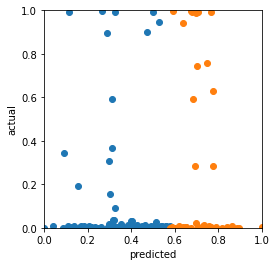

In [13]:
#GAIN
tr_y,pred_tr_y,te_y,pred_te_y=imputation_missX(tr_df,te_df,target,imputer=GAIN())
visualize_result(tr_y,pred_tr_y,te_y,pred_te_y)

# Normal regression
    - Fill NaN with mean values
    - Normal regression by HuberRegressor

In [14]:
def normal_regression(tr_df,te_df,target,model=HuberRegressor()):
    te_df=te_df.fillna(te_df.mean())
    te_df=te_df.loc[:, (df != 0).any(axis=0)]

    spl_pos=tr_df.shape[0]
    tr_df=te_df[:spl_pos]
    te_df=te_df[spl_pos:]
    
    tr_X=np.array(tr_df.drop(target,axis=1))
    te_X=np.array(te_df.drop(target,axis=1))
    tr_y=np.array(tr_df[target])
    te_y=np.array(te_df[target])
    
    model.fit(tr_X,tr_y)
    
    return np.array(tr_y),model.predict(tr_X),np.array(te_y),model.predict(te_X)

MAE for train:  0.011192666383932173
MAE for test:  0.1935409277172277


/home/kh/anaconda3/envs/mcflow/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


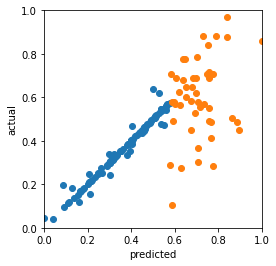

In [15]:
tr_y,pred_tr_y,te_y,pred_te_y=normal_regression(tr_df,te_df,target)
visualize_result(tr_y,pred_tr_y,te_y,pred_te_y)